In [1]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

# Function to select files
def load_files():
    root = tk.Tk()
    root.withdraw()
    return filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])

# Butterworth Filters
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

def low_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Remove Outliers
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Load datasets
file_paths = load_files()
if file_paths:
    all_data = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        file_name = os.path.basename(file_path)

        numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
        if not numeric_columns:
            continue

        for col in numeric_columns:
            signal = df[col].fillna(0)[:300]
            baseline_wandering = low_pass_filter(signal)
            filtered_signal = high_pass_filter(signal)
            outlier_removed_signal = remove_outliers(filtered_signal)

        all_data.append(df)

    combined_df = pd.concat(all_data, ignore_index=True)
    scaler = MinMaxScaler()
    processed_data = scaler.fit_transform(combined_df[numeric_columns].fillna(0))

    # Prepare Data for Models
    X, y = [], []
    seq_length = 10
    for i in range(len(processed_data) - seq_length):
        X.append(processed_data[i:i+seq_length])
        y.append(processed_data[i+seq_length])
    X, y = np.array(X), np.array(y)

    train_size = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

    # Build and Train LSTM Model
    lstm_model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
        LSTM(50, activation='relu'),
        Dense(len(numeric_columns), activation='sigmoid')
    ])
    lstm_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    history_lstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

    y_pred_lstm = lstm_model.predict(X_test)
    y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

    # Transformer Model
    class TransformerModel(nn.Module):
        def __init__(self, input_dim):
            super(TransformerModel, self).__init__()
            self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
            self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
            self.fc = nn.Linear(input_dim, input_dim)

        def forward(self, x):
            x = self.transformer_encoder(x)
            return torch.sigmoid(self.fc(x[:, -1, :]))  

    X_train_torch = torch.tensor(X_train, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32)
    X_test_torch = torch.tensor(X_test, dtype=torch.float32)
    y_test_torch = torch.tensor(y_test, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=16, shuffle=True)
    transformer_model = TransformerModel(input_dim=len(numeric_columns))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

    transformer_losses = []
    for epoch in range(100):
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = transformer_model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        transformer_losses.append(total_loss / len(train_loader))

    y_pred_transformer = transformer_model(X_test_torch).detach().numpy()
    y_pred_transformer = (y_pred_transformer > 0.5).astype(int)

    # Calculate Metrics
    def calculate_metrics(y_true, y_pred):
        accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
        specificity = recall_score(y_true.flatten(), y_pred.flatten(), pos_label=0)
        f1 = f1_score(y_true.flatten(), y_pred.flatten())
        loss = np.mean((y_true - y_pred) ** 2)
        return accuracy, specificity, f1, loss

    lstm_accuracy, lstm_specificity, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)
    transformer_accuracy, transformer_specificity, transformer_f1, transformer_loss = calculate_metrics(y_test, y_pred_transformer)

    # Performance Table
    epochs = [10, 30, 50, 75, 100]
    lstm_losses = [history_lstm.history['loss'][e-1] for e in epochs]
    transformer_losses_epoch = [transformer_losses[e-1] for e in epochs]

    print("\nModel Performance Table\n")
    print("Epoch | LSTM Loss | Transformer Loss | LSTM Acc | Trans Acc | LSTM F1 | Trans F1 | LSTM Spec | Trans Spec")
    print("--------------------------------------------------------------------------------------------")
    for i in range(len(epochs)):
        print(f"{epochs[i]:<5} | {lstm_losses[i]:<10.4f} | {transformer_losses_epoch[i]:<10.4f} | "
              f"{lstm_accuracy:<8.4f} | {transformer_accuracy:<9.4f} | {lstm_f1:<7.4f} | {transformer_f1:<8.4f} | "
              f"{lstm_specificity:<9.4f} | {transformer_specificity:<10.4f}")

    # Plot Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, lstm_losses, label='LSTM Loss', color='blue', marker='o')
    plt.plot(epochs, transformer_losses_epoch, label='Transformer Loss', color='red', marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Model Loss Comparison")
    plt.show()
else:
    print("No file selected. Please upload a valid dataset.")


No file selected. Please upload a valid dataset.


In [4]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    return file_paths

# Butterworth high-pass filter
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Butterworth low-pass filter
def low_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Remove outliers using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Load dataset
file_paths = load_files()
if not file_paths:
    print("No file selected. Please upload a valid dataset.")
    exit()

dataframes = [pd.read_csv(file) for file in file_paths]
df = pd.concat(dataframes, ignore_index=True)

print("\n Dataset Loaded Successfully!\n")
print(df.head())

# Select only numeric columns
numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
if not numeric_columns:
    print("No numeric columns found in the dataset.")
    exit()

scaler = MinMaxScaler()
processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

# Create sequences for training
X, y = [], []
seq_length = 10
for i in range(len(processed_data) - seq_length):
    X.append(processed_data[i:i+seq_length])
    y.append(processed_data[i+seq_length])

X, y = np.array(X), np.array(y)

# Split data (80% train, 20% test)
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
        LSTM(50, activation='relu'),
        Dense(len(numeric_columns))
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        return self.fc(x[:, -1, :])

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    if len(y_true) == 0 or len(y_pred) == 0:
        return 0, 0, 0, 0
    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    specificity = recall_score(y_true.flatten(), y_pred.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), zero_division=1)
    loss = np.mean((y_true - y_pred) ** 2)
    return accuracy, specificity, f1, loss

# Training loop for different epochs
epochs_list = [10, 30, 50, 75, 100]
performance_data = []

for num_epochs in epochs_list:
    print(f"\nTraining models for {num_epochs} epochs...\n")

    # Train LSTM
    lstm_model = build_lstm_model()
    history_lstm = lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, validation_data=(X_test, y_test), verbose=0)
    y_pred_lstm = lstm_model.predict(X_test)
    lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)

    # Train Transformer
    X_train_torch = torch.tensor(X_train, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=16, shuffle=True)

    transformer_model = TransformerModel(input_dim=len(numeric_columns))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

    transformer_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = transformer_model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        transformer_losses.append(total_loss / len(train_loader))

    y_pred_transformer = transformer_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
    transformer_acc, transformer_spec, transformer_f1, transformer_loss = calculate_metrics(y_test, y_pred_transformer)

    performance_data.append([num_epochs, lstm_loss, lstm_acc, lstm_spec, lstm_f1, transformer_loss, transformer_acc, transformer_spec, transformer_f1])

# Convert performance data to DataFrame
performance_df = pd.DataFrame(performance_data, columns=["Epochs", "LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score", "Transformer Loss", "Transformer Accuracy", "Transformer Specificity", "Transformer F1 Score"])
print(performance_df)

# Plot individual metrics
metrics = ["Loss", "Accuracy", "Specificity", "F1 Score"]
lstm_metrics = ["LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score"]
transformer_metrics = ["Transformer Loss", "Transformer Accuracy", "Transformer Specificity", "Transformer F1 Score"]
colors = ["blue", "green", "orange", "red"]

plt.figure(figsize=(12, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.plot(epochs_list, performance_df[lstm_metrics[i]], marker='o', label=f"LSTM {metric}", color=colors[i])
    plt.plot(epochs_list, performance_df[transformer_metrics[i]], marker='o', label=f"Transformer {metric}", color=colors[i], linestyle='dashed')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"{metric} Across Epochs")
    plt.legend()

plt.tight_layout()
plt.show()



 Dataset Loaded Successfully!

   Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.97          909.5364             78.81         33.96   
1         33.96          909.5364             78.81         33.95   
2         33.95          909.5324             78.99         33.94   
3         33.95          909.5289             79.12         33.94   
4         33.95          909.5289             79.18         33.94   

   Sensor2_Pressure  Sensor2_Humidity  
0          909.4451             87.90  
1          909.4553             87.90  
2          909.4709             87.99  
3          909.4604             88.01  
4          909.4604             88.01  

Training models for 10 epochs...



ValueError: continuous is not supported


 Dataset Loaded Successfully!

   Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.97          909.5364             78.81         33.96   
1         33.96          909.5364             78.81         33.95   
2         33.95          909.5324             78.99         33.94   
3         33.95          909.5289             79.12         33.94   
4         33.95          909.5289             79.18         33.94   

   Sensor2_Pressure  Sensor2_Humidity  
0          909.4451             87.90  
1          909.4553             87.90  
2          909.4709             87.99  
3          909.4604             88.01  
4          909.4604             88.01  

Training models for 10 epochs...


Training models for 30 epochs...


Training models for 50 epochs...


Training models for 75 epochs...


Training models for 100 epochs...

   Epochs  LSTM Loss  LSTM Accuracy  LSTM Specificity  LSTM F1 Score  \
0      10   0.070077       0.903404          0.821725       0.917

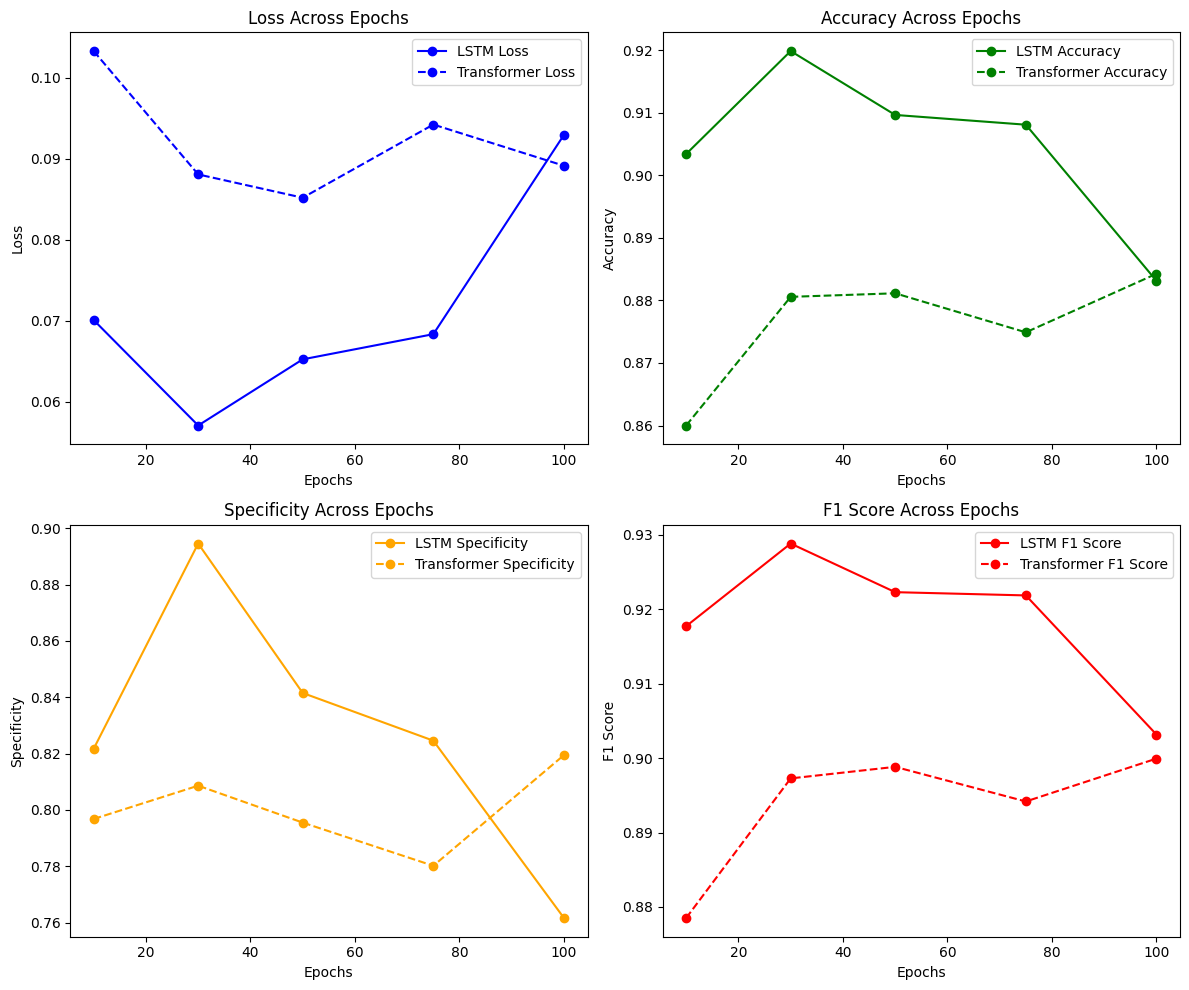

In [6]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    return file_paths

# Butterworth high-pass filter
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Butterworth low-pass filter
def low_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Remove outliers using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Load dataset
file_paths = load_files()
if not file_paths:
    print("No file selected. Please upload a valid dataset.")
    exit()

dataframes = [pd.read_csv(file) for file in file_paths]
df = pd.concat(dataframes, ignore_index=True)

print("\n Dataset Loaded Successfully!\n")
print(df.head())

# Select only numeric columns
numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
if not numeric_columns:
    print("No numeric columns found in the dataset.")
    exit()

scaler = MinMaxScaler()
processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

# Create sequences for training
X, y = [], []
seq_length = 10
for i in range(len(processed_data) - seq_length):
    X.append(processed_data[i:i+seq_length])
    y.append(processed_data[i+seq_length])

X, y = np.array(X), np.array(y)

# Convert target variable to binary classification (0 or 1)
threshold = 0.5
y = (y > threshold).astype(int)

# Split data (80% train, 20% test)
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
        LSTM(50, activation='relu'),
        Dense(len(numeric_columns), activation='sigmoid')  # Use sigmoid for binary output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        return torch.sigmoid(self.fc(x[:, -1, :]))  # Use sigmoid activation

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert continuous predictions to binary labels
    accuracy = accuracy_score(y_true.flatten(), y_pred_binary.flatten())
    specificity = recall_score(y_true.flatten(), y_pred_binary.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten(), zero_division=1)
    loss = mean_squared_error(y_true, y_pred)  # Regression loss
    return accuracy, specificity, f1, loss

# Training loop for different epochs
epochs_list = [10, 30, 50, 75, 100]
performance_data = []

for num_epochs in epochs_list:
    print(f"\nTraining models for {num_epochs} epochs...\n")

    # Train LSTM
    lstm_model = build_lstm_model()
    history_lstm = lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, validation_data=(X_test, y_test), verbose=0)
    y_pred_lstm = lstm_model.predict(X_test)
    lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)

    # Train Transformer
    X_train_torch = torch.tensor(X_train, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=16, shuffle=True)

    transformer_model = TransformerModel(input_dim=len(numeric_columns))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = transformer_model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

    y_pred_transformer = transformer_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
    transformer_acc, transformer_spec, transformer_f1, transformer_loss = calculate_metrics(y_test, y_pred_transformer)

    performance_data.append([num_epochs, lstm_loss, lstm_acc, lstm_spec, lstm_f1, transformer_loss, transformer_acc, transformer_spec, transformer_f1])

# Convert performance data to DataFrame
performance_df = pd.DataFrame(performance_data, columns=["Epochs", "LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score", "Transformer Loss", "Transformer Accuracy", "Transformer Specificity", "Transformer F1 Score"])
print(performance_df)

# Plot individual metrics
metrics = ["Loss", "Accuracy", "Specificity", "F1 Score"]
lstm_metrics = ["LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score"]
transformer_metrics = ["Transformer Loss", "Transformer Accuracy", "Transformer Specificity", "Transformer F1 Score"]
colors = ["blue", "green", "orange", "red"]

plt.figure(figsize=(12, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.plot(epochs_list, performance_df[lstm_metrics[i]], marker='o', label=f"LSTM {metric}", color=colors[i])
    plt.plot(epochs_list, performance_df[transformer_metrics[i]], marker='o', label=f"Transformer {metric}", color=colors[i], linestyle='dashed')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"{metric} Across Epochs")
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Function to select multiple files
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    return file_paths

# Butterworth high-pass filter
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Remove outliers using Z-score
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Load dataset
file_paths = load_files()
if not file_paths:
    print("No file selected. Please upload a valid dataset.")
    exit()

dataframes = [pd.read_csv(file) for file in file_paths]
df = pd.concat(dataframes, ignore_index=True)

print("\n Dataset Loaded Successfully!\n")
print(df.head())

# Select only numeric columns
numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
if not numeric_columns:
    print("No numeric columns found in the dataset.")
    exit()

scaler = MinMaxScaler()
processed_data = scaler.fit_transform(df[numeric_columns].fillna(0))

# Create sequences for training
X, y = [], []
seq_length = 10
for i in range(len(processed_data) - seq_length):
    X.append(processed_data[i:i+seq_length])
    y.append(processed_data[i+seq_length])

X, y = np.array(X), np.array(y)

# Convert target variable to binary classification (0 or 1)
threshold = 0.5
y = (y > threshold).astype(int)

# Split data (80% train, 20% test)
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(numeric_columns))),
        LSTM(50, activation='relu'),
        Dense(len(numeric_columns), activation='sigmoid')  # Use sigmoid for binary output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        return torch.sigmoid(self.fc(x[:, -1, :]))  # Use sigmoid activation

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert continuous predictions to binary labels
    accuracy = accuracy_score(y_true.flatten(), y_pred_binary.flatten())
    specificity = recall_score(y_true.flatten(), y_pred_binary.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten(), zero_division=1)
    loss = mean_squared_error(y_true, y_pred)  # Regression loss
    return accuracy, specificity, f1, loss

# Training loop for different epochs
epochs_list = [10, 30, 50, 75, 100]
performance_data = []
training_history = {}

for num_epochs in epochs_list:
    print(f"\nTraining models for {num_epochs} epochs...\n")

    # Train LSTM
    lstm_model = build_lstm_model()
    history_lstm = lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, validation_data=(X_test, y_test), verbose=1)
    y_pred_lstm = lstm_model.predict(X_test)
    lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)

    # Train Transformer
    X_train_torch = torch.tensor(X_train, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=16, shuffle=True)

    transformer_model = TransformerModel(input_dim=len(numeric_columns))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

    transformer_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = transformer_model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        transformer_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{num_epochs} - Transformer Loss: {transformer_losses[-1]:.4f}")

    y_pred_transformer = transformer_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
    transformer_acc, transformer_spec, transformer_f1, transformer_loss = calculate_metrics(y_test, y_pred_transformer)

    performance_data.append([num_epochs, lstm_loss, lstm_acc, lstm_spec, lstm_f1, transformer_loss, transformer_acc, transformer_spec, transformer_f1])

    # Save training history
    training_history[num_epochs] = {
        "LSTM Loss": history_lstm.history['loss'],
        "LSTM Accuracy": history_lstm.history['accuracy'],
        "Transformer Loss": transformer_losses
    }

# Convert performance data to DataFrame
performance_df = pd.DataFrame(performance_data, columns=["Epochs", "LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score", "Transformer Loss", "Transformer Accuracy", "Transformer Specificity", "Transformer F1 Score"])
print(performance_df)

# Plot individual metrics
plt.figure(figsize=(12, 5))
for num_epochs in epochs_list:
    plt.plot(range(1, num_epochs + 1), training_history[num_epochs]["LSTM Loss"], label=f"LSTM ({num_epochs} epochs)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Training Loss Across Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for num_epochs in epochs_list:
    plt.plot(range(1, num_epochs + 1), training_history[num_epochs]["Transformer Loss"], label=f"Transformer ({num_epochs} epochs)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Transformer Training Loss Across Epochs")
plt.legend()
plt.show()



 Dataset Loaded Successfully!

   Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0         33.97          909.5364             78.81         33.96   
1         33.96          909.5364             78.81         33.95   
2         33.95          909.5324             78.99         33.94   
3         33.95          909.5289             79.12         33.94   
4         33.95          909.5289             79.18         33.94   

   Sensor2_Pressure  Sensor2_Humidity  
0          909.4451             87.90  
1          909.4553             87.90  
2          909.4709             87.99  
3          909.4604             88.01  
4          909.4604             88.01  

Training models for 10 epochs...

Epoch 1/10
4182/4182 [==============================] - 32s 7ms/step - loss: 0.0400 - accuracy: 0.4981 - val_loss: 0.0181 - val_accuracy: 0.2775
Epoch 2/10
3204/4182 [=====================>........] - ETA: 6s - loss: 0.0245 - accuracy: 0.1301     


===== Training for 10 epochs =====
LSTM Training - Epoch 1/10 completed.
LSTM Training - Epoch 2/10 completed.
LSTM Training - Epoch 3/10 completed.
LSTM Training - Epoch 4/10 completed.
LSTM Training - Epoch 5/10 completed.
LSTM Training - Epoch 6/10 completed.
LSTM Training - Epoch 7/10 completed.
LSTM Training - Epoch 8/10 completed.
LSTM Training - Epoch 9/10 completed.
LSTM Training - Epoch 10/10 completed.
Transformer Training - Epoch 1/10 completed.
Transformer Training - Epoch 2/10 completed.
Transformer Training - Epoch 3/10 completed.
Transformer Training - Epoch 4/10 completed.
Transformer Training - Epoch 5/10 completed.
Transformer Training - Epoch 6/10 completed.
Transformer Training - Epoch 7/10 completed.
Transformer Training - Epoch 8/10 completed.
Transformer Training - Epoch 9/10 completed.
Transformer Training - Epoch 10/10 completed.

===== Training for 30 epochs =====
LSTM Training - Epoch 1/30 completed.
LSTM Training - Epoch 2/30 completed.
LSTM Training - Epoc

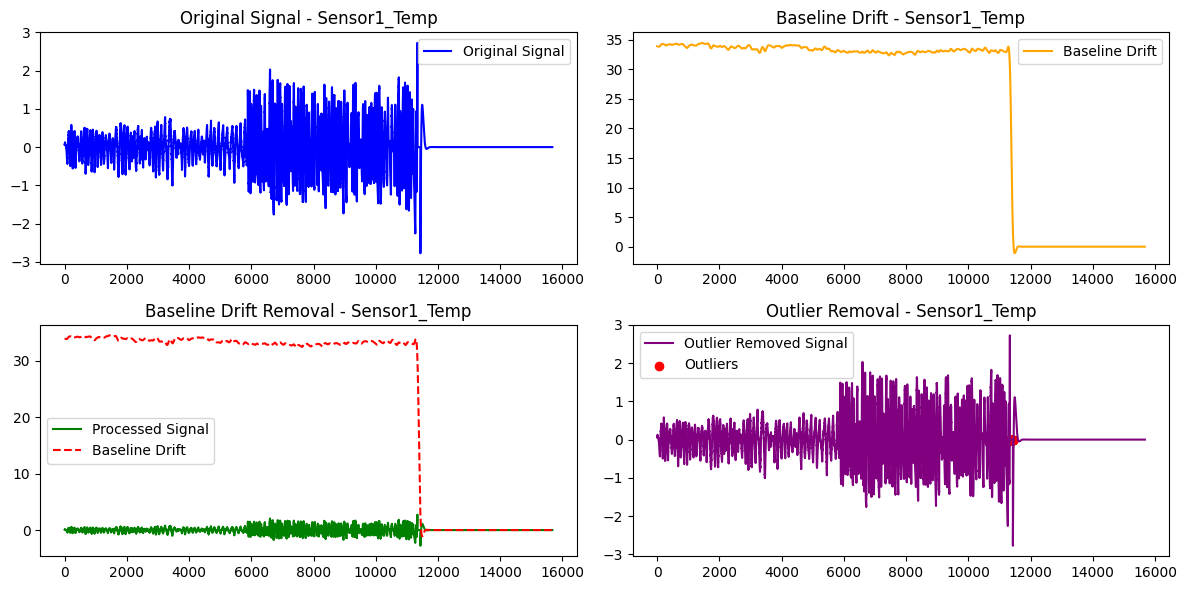

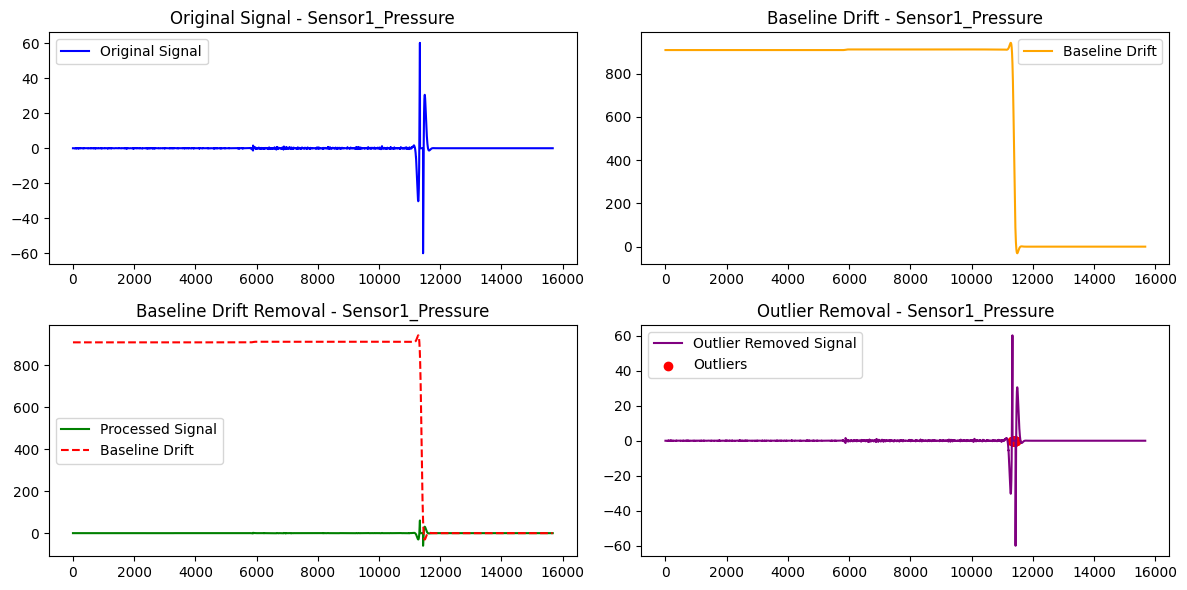

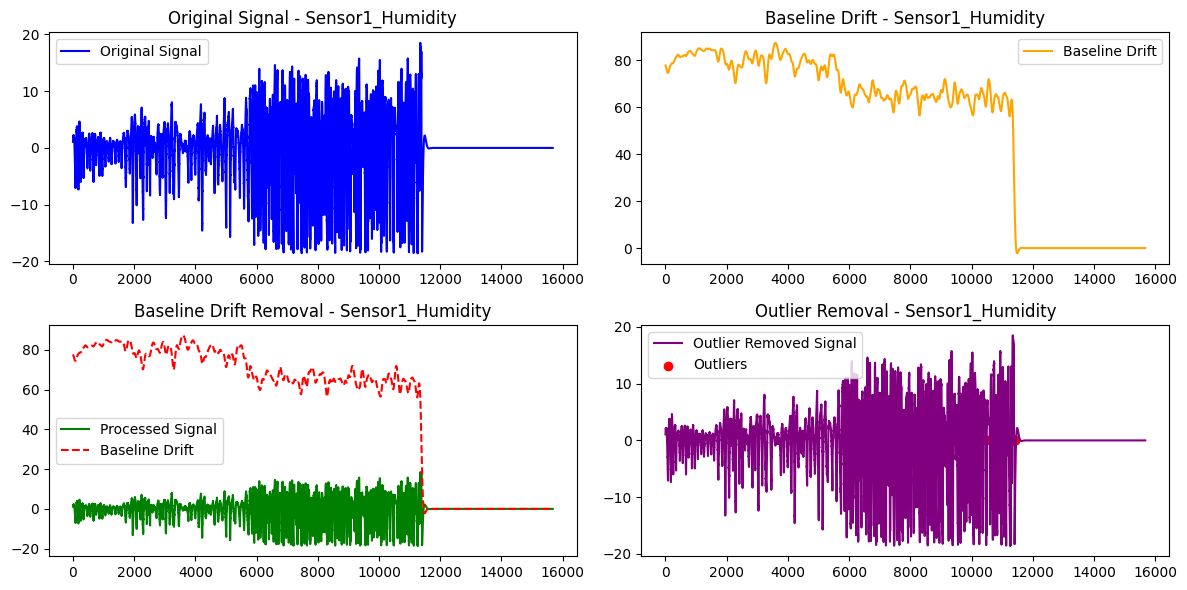

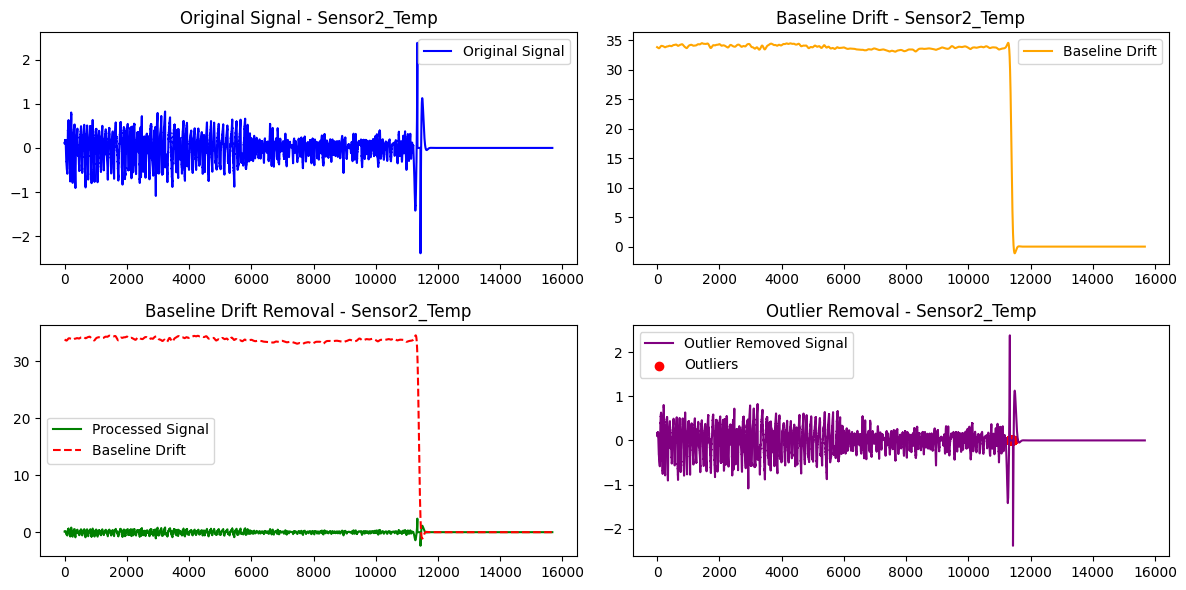

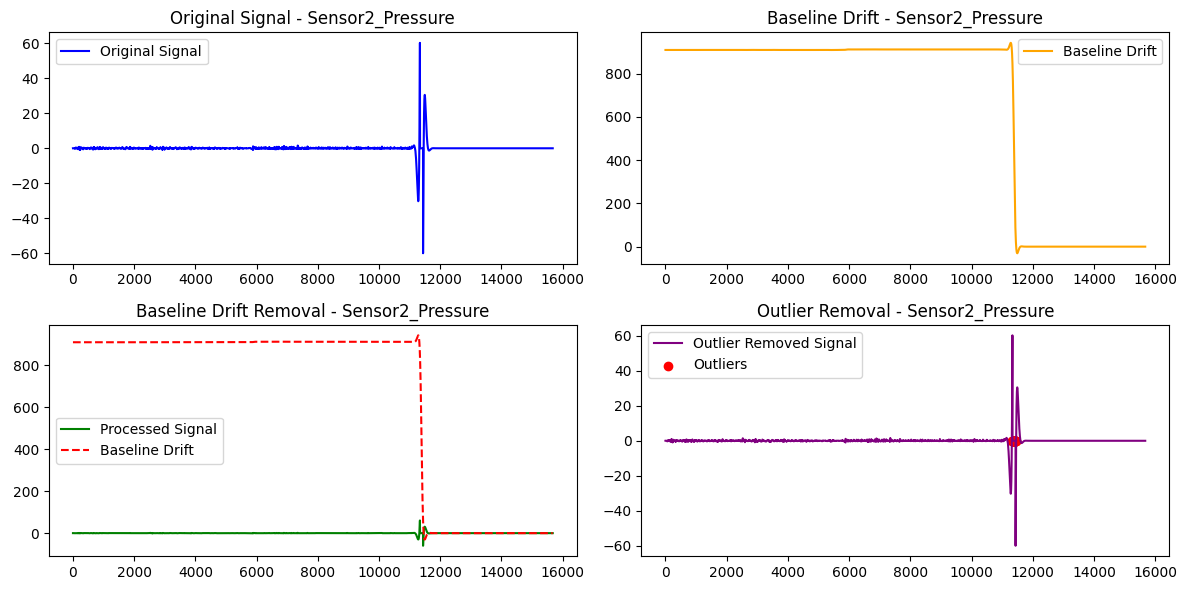

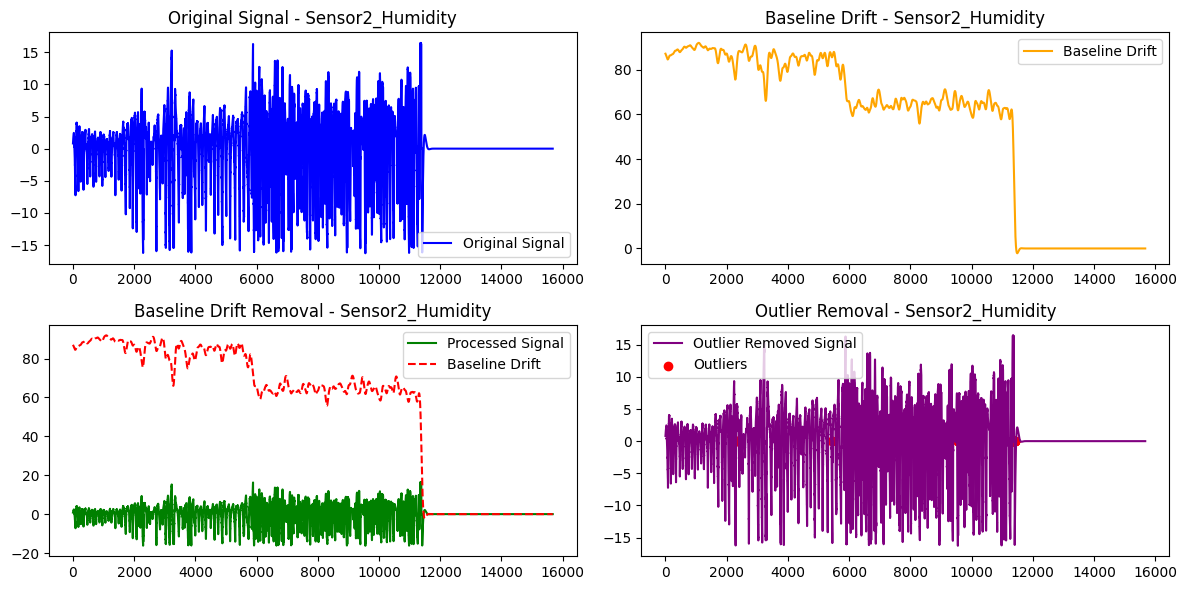

No file selected. Exiting...


ValueError: No objects to concatenate

In [1]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to load files using Tkinter
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score method
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Data Preprocessing Function
def preprocess_data(df):
    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    df[numeric_columns] = df[numeric_columns].fillna(0)
    
    baseline_drift = df[numeric_columns].apply(lambda x: x - high_pass_filter(x))
    df[numeric_columns] = df[numeric_columns].apply(high_pass_filter)
    
    outliers = df[numeric_columns].apply(lambda x: np.abs(zscore(x)) > 3)
    df[numeric_columns] = df[numeric_columns].apply(remove_outliers)

    return df, numeric_columns, baseline_drift, outliers

# Function to plot signals
def plot_signals(df, numeric_columns, baseline_drift, outliers):
    for col in numeric_columns:
        plt.figure(figsize=(12, 6))
        
        # Original Signal
        plt.subplot(2, 2, 1)
        plt.plot(df[col], label="Original Signal", color="blue")
        plt.title(f"Original Signal - {col}")
        plt.legend()

        # Baseline Drift
        plt.subplot(2, 2, 2)
        plt.plot(baseline_drift[col], label="Baseline Drift", color="orange")
        plt.title(f"Baseline Drift - {col}")
        plt.legend()

        # Baseline Drift Removal
        plt.subplot(2, 2, 3)
        plt.plot(df[col], label="Processed Signal", color="green")
        plt.plot(baseline_drift[col], label="Baseline Drift", color="red", linestyle="dashed")
        plt.title(f"Baseline Drift Removal - {col}")
        plt.legend()

        # Outlier Removal
        plt.subplot(2, 2, 4)
        plt.plot(df[col], label="Outlier Removed Signal", color="purple")
        outlier_points = df[col][outliers[col]]
        plt.scatter(outlier_points.index, outlier_points, color="red", label="Outliers")
        plt.title(f"Outlier Removal - {col}")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Load and Process Data
file_paths = load_files()
if not file_paths:
    print("No file selected. Exiting...")
    exit()

dataframes = [pd.read_csv(file) for file in file_paths]
df = pd.concat(dataframes, ignore_index=True)
df, numeric_columns, baseline_drift, outliers = preprocess_data(df)

# Plot the signals
plot_signals(df, numeric_columns, baseline_drift, outliers)

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(50, activation='relu'),
        Dense(input_shape[1], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Transformer Model using PyTorch
class TransformerModel(nn.Module):
    def __init__(self, input_dim):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        return torch.sigmoid(self.fc(x[:, -1, :]))

# Function to Calculate Performance Metrics
def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true.flatten(), y_pred_binary.flatten())
    specificity = recall_score(y_true.flatten(), y_pred_binary.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten(), zero_division=1)
    loss = mean_squared_error(y_true, y_pred)
    return accuracy, specificity, f1, loss

# Load and Process Data
file_paths = load_files()
if not file_paths:
    print("No file selected. Exiting...")
    exit()

dataframes = [pd.read_csv(file) for file in file_paths]
df = pd.concat(dataframes, ignore_index=True)
df, numeric_columns = preprocess_data(df)

# Scaling Data
scaler = MinMaxScaler()
processed_data = scaler.fit_transform(df[numeric_columns])

# Prepare Data for Training
X, y = [], []
seq_length = 10
for i in range(len(processed_data) - seq_length):
    X.append(processed_data[i:i+seq_length])
    y.append(processed_data[i+seq_length])
X, y = np.array(X), np.array(y)
y = (y > 0.5).astype(int)

# Split Data into Train & Test
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Training for Different Epochs
performance_data = []
epochs_list = [10, 30, 50, 75, 100]

for num_epochs in epochs_list:
    print(f"\n===== Training for {num_epochs} epochs =====")

    # Train LSTM
    lstm_model = build_lstm_model((seq_length, len(numeric_columns)))
    for epoch in range(1, num_epochs + 1):
        lstm_model.fit(X_train, y_train, epochs=1, batch_size=16, verbose=0)
        print(f"LSTM Training - Epoch {epoch}/{num_epochs} completed.")

    y_pred_lstm = lstm_model.predict(X_test)
    lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)

    # Train Transformer
    transformer_model = TransformerModel(len(numeric_columns)).cuda()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float().cuda(), torch.tensor(y_train).float().cuda()), batch_size=16, shuffle=True)

    for epoch in range(1, num_epochs + 1):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = transformer_model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Transformer Training - Epoch {epoch}/{num_epochs} completed.")

    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test).float().cuda()
        y_pred_transformer = transformer_model(X_test_tensor).cpu().numpy()
    transformer_acc, transformer_spec, transformer_f1, transformer_loss = calculate_metrics(y_test, y_pred_transformer)

    performance_data.append([num_epochs, lstm_loss, lstm_acc, lstm_spec, lstm_f1, transformer_loss, transformer_acc, transformer_spec, transformer_f1])

# Store Performance in a DataFrame
performance_df = pd.DataFrame(performance_data, columns=["Epochs", "LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score", "Transformer Loss", "Transformer Accuracy", "Transformer Specificity", "Transformer F1 Score"])
print(performance_df)

# Plot Model Performance
plt.figure(figsize=(12, 10))
metrics = ["Loss", "Accuracy", "Specificity", "F1 Score"]
lstm_metrics = ["LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score"]
transformer_metrics = ["Transformer Loss", "Transformer Accuracy", "Transformer Specificity", "Transformer F1 Score"]
colors = ["blue", "green", "orange", "red"]

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.plot(epochs_list, performance_df[lstm_metrics[i]], marker='o', label=f"LSTM {metric}", color=colors[i])
    plt.plot(epochs_list, performance_df[transformer_metrics[i]], marker='o', label=f"Transformer {metric}", color=colors[i], linestyle='dashed')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"{metric} Across Epochs")
    plt.legend()

plt.tight_layout()
plt.show()


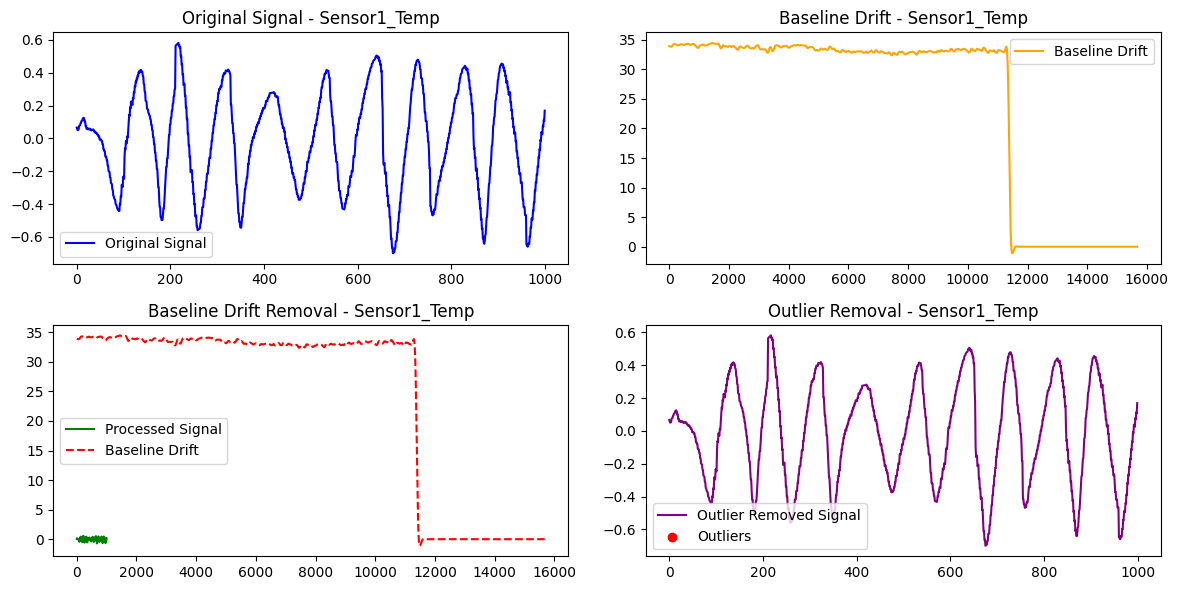

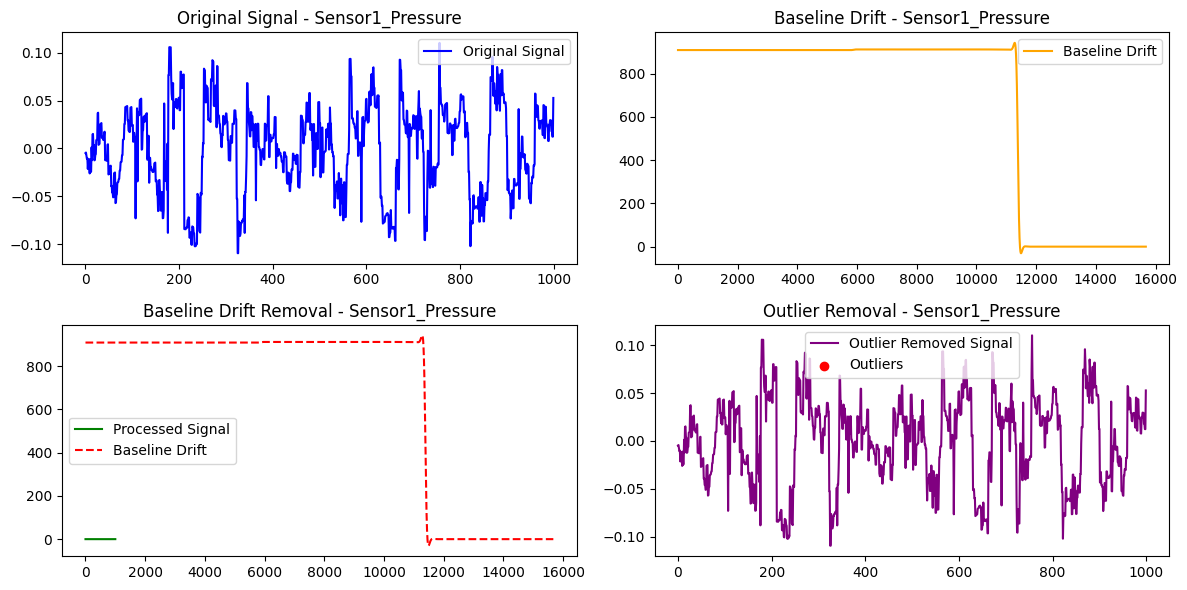

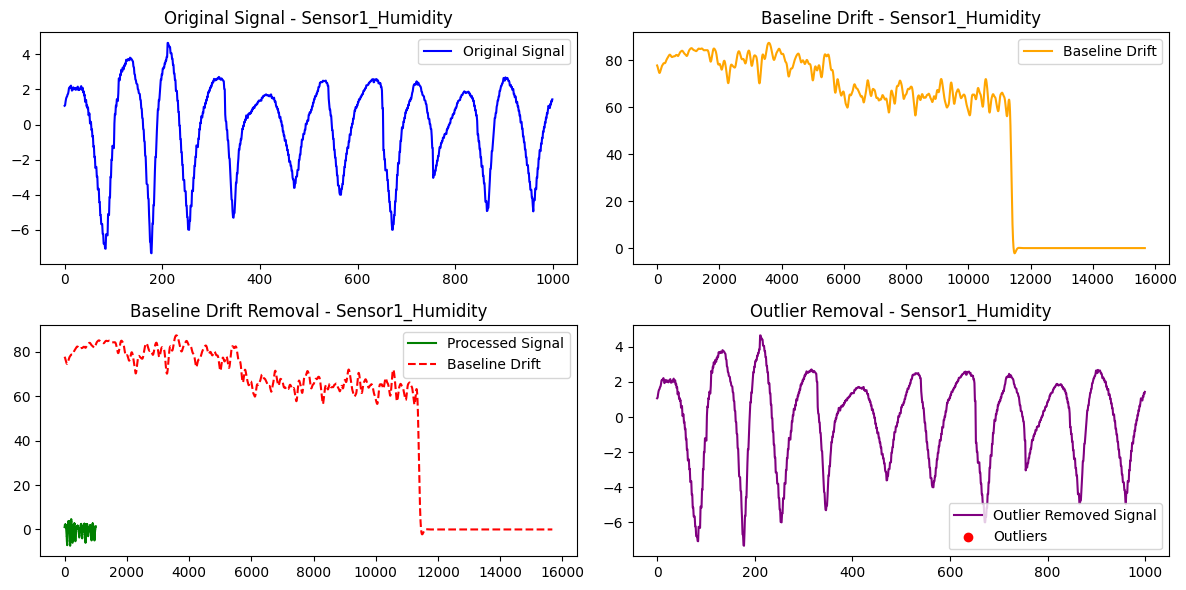

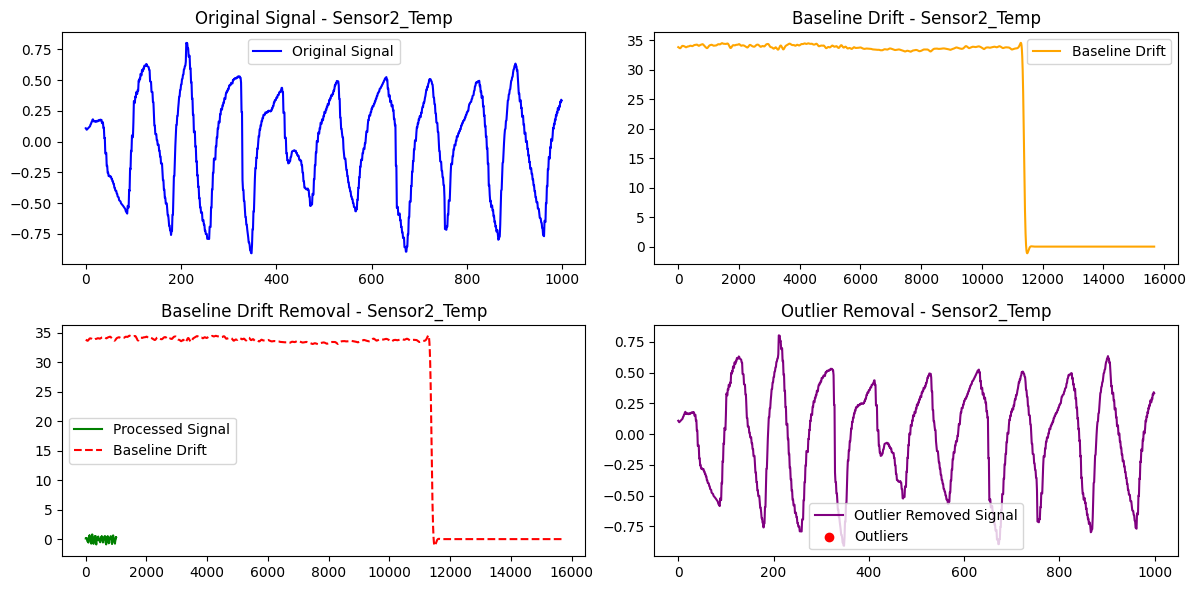

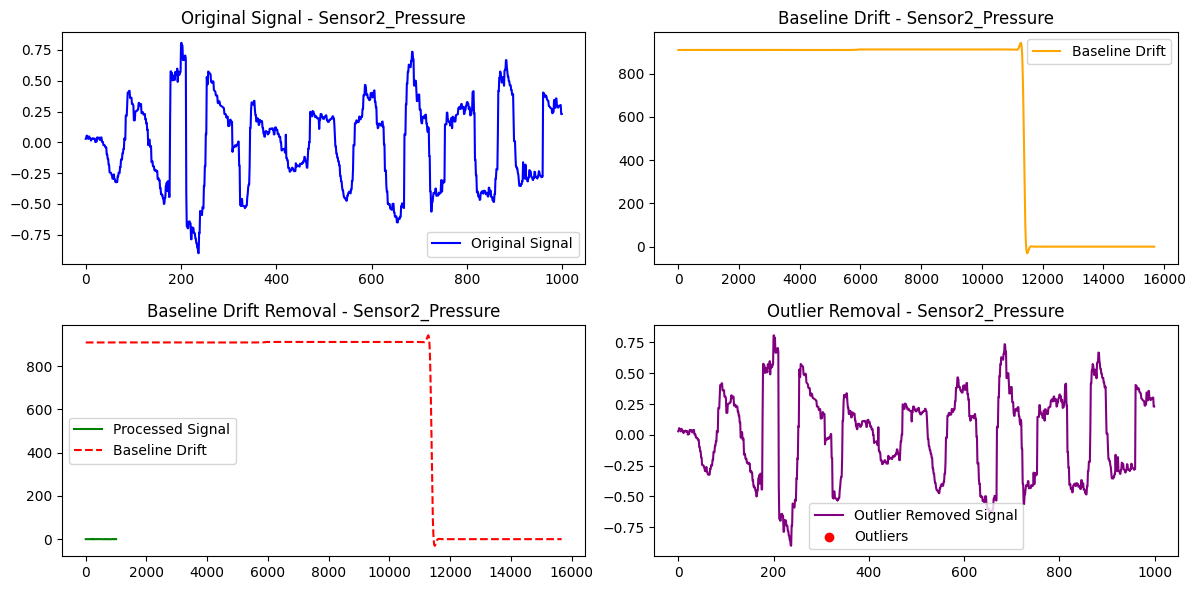

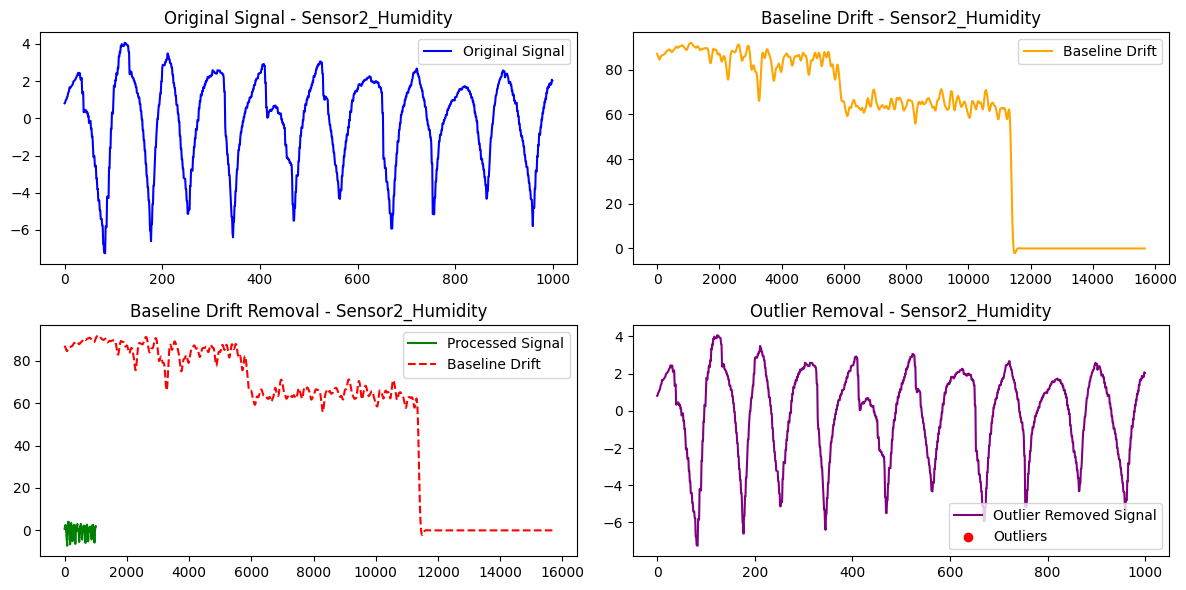


===== Training for 10 epochs =====
Epoch 1/10
784/784 [==============================] - 12s 10ms/step - loss: nan - accuracy: 0.9740
Epoch 2/10
784/784 [==============================] - 7s 9ms/step - loss: nan - accuracy: 0.9740
Epoch 3/10
784/784 [==============================] - 7s 9ms/step - loss: nan - accuracy: 0.9740
Epoch 4/10
784/784 [==============================] - 7s 9ms/step - loss: nan - accuracy: 0.9740
Epoch 5/10
784/784 [==============================] - 7s 9ms/step - loss: nan - accuracy: 0.9740
Epoch 6/10
784/784 [==============================] - 8s 10ms/step - loss: nan - accuracy: 0.9740
Epoch 7/10
784/784 [==============================] - 8s 10ms/step - loss: nan - accuracy: 0.9740
Epoch 8/10
784/784 [==============================] - 10s 12ms/step - loss: nan - accuracy: 0.9740
Epoch 9/10
784/784 [==============================] - 10s 12ms/step - loss: nan - accuracy: 0.9740
Epoch 10/10
784/784 [==============================] - 10s 12ms/step - loss: nan - 

ValueError: Input contains NaN.

In [1]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to load files using Tkinter
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    if not file_paths:
        print("No file selected. Exiting...")
        exit()
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score method
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Function to ensure all signals have 1000 samples
def ensure_1000_samples(df, numeric_columns):
    for col in numeric_columns:
        if len(df[col]) > 1000:
            df[col] = df[col][:1000]  # Trim
        elif len(df[col]) < 1000:
            df[col] = np.pad(df[col], (0, 1000 - len(df[col])), mode='constant')  # Pad
    return df

# Data Preprocessing Function
def preprocess_data(df):
    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    df[numeric_columns] = df[numeric_columns].fillna(0)
    
    baseline_drift = df[numeric_columns].apply(lambda x: x - high_pass_filter(x))
    df[numeric_columns] = df[numeric_columns].apply(high_pass_filter)
    
    outliers = df[numeric_columns].apply(lambda x: np.abs(zscore(x)) > 3)
    df[numeric_columns] = df[numeric_columns].apply(remove_outliers)

    df = ensure_1000_samples(df, numeric_columns)

    return df, numeric_columns, baseline_drift, outliers

# Function to plot signals
def plot_signals(df, numeric_columns, baseline_drift, outliers):
    for col in numeric_columns:
        plt.figure(figsize=(12, 6))
        
        # Original Signal
        plt.subplot(2, 2, 1)
        plt.plot(df[col], label="Original Signal", color="blue")
        plt.title(f"Original Signal - {col}")
        plt.legend()

        # Baseline Drift
        plt.subplot(2, 2, 2)
        plt.plot(baseline_drift[col], label="Baseline Drift", color="orange")
        plt.title(f"Baseline Drift - {col}")
        plt.legend()

        # Baseline Drift Removal
        plt.subplot(2, 2, 3)
        plt.plot(df[col], label="Processed Signal", color="green")
        plt.plot(baseline_drift[col], label="Baseline Drift", color="red", linestyle="dashed")
        plt.title(f"Baseline Drift Removal - {col}")
        plt.legend()

        # Outlier Removal
        plt.subplot(2, 2, 4)
        plt.plot(df[col], label="Outlier Removed Signal", color="purple")
        outlier_points = df[col][outliers[col]]
        plt.scatter(outlier_points.index, outlier_points, color="red", label="Outliers")
        plt.title(f"Outlier Removal - {col}")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Load and Process Data
file_paths = load_files()
dataframes = [pd.read_csv(file) for file in file_paths]
df = pd.concat(dataframes, ignore_index=True)
df, numeric_columns, baseline_drift, outliers = preprocess_data(df)

# Plot the signals
plot_signals(df, numeric_columns, baseline_drift, outliers)

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(50, activation='relu'),
        Dense(input_shape[1], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Transformer Model using PyTorch
class TransformerModel(nn.Module):
    def __init__(self, input_dim):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=2, dim_feedforward=64, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        return torch.sigmoid(self.fc(x[:, -1, :]))

# Function to Calculate Performance Metrics
def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true.flatten(), y_pred_binary.flatten())
    specificity = recall_score(y_true.flatten(), y_pred_binary.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten(), zero_division=1)
    loss = mean_squared_error(y_true, y_pred)
    return accuracy, specificity, f1, loss

# Scaling Data
scaler = MinMaxScaler()
processed_data = scaler.fit_transform(df[numeric_columns])

# Prepare Data for Training
X, y = [], []
seq_length = 10
for i in range(len(processed_data) - seq_length):
    X.append(processed_data[i:i+seq_length])
    y.append(processed_data[i+seq_length])
X, y = np.array(X), np.array(y)
y = (y > 0.5).astype(int)

# Split Data into Train & Test
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Training for Different Epochs
performance_data = []
epochs_list = [10, 30, 50, 75, 100]

for num_epochs in epochs_list:
    print(f"\n===== Training for {num_epochs} epochs =====")

    # Train LSTM
    lstm_model = build_lstm_model((seq_length, len(numeric_columns)))
    lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, verbose=1)
    y_pred_lstm = lstm_model.predict(X_test)
    lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)

    performance_data.append([num_epochs, lstm_loss, lstm_acc, lstm_spec, lstm_f1])

# Store Performance in a DataFrame
performance_df = pd.DataFrame(performance_data, columns=["Epochs", "LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score"])
print(performance_df)

# Plot Model Performance
plt.figure(figsize=(10, 6))
plt.plot(epochs_list, performance_df["LSTM Accuracy"], marker='o', label="LSTM Accuracy", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("LSTM Accuracy Across Epochs")
plt.legend()
plt.show()


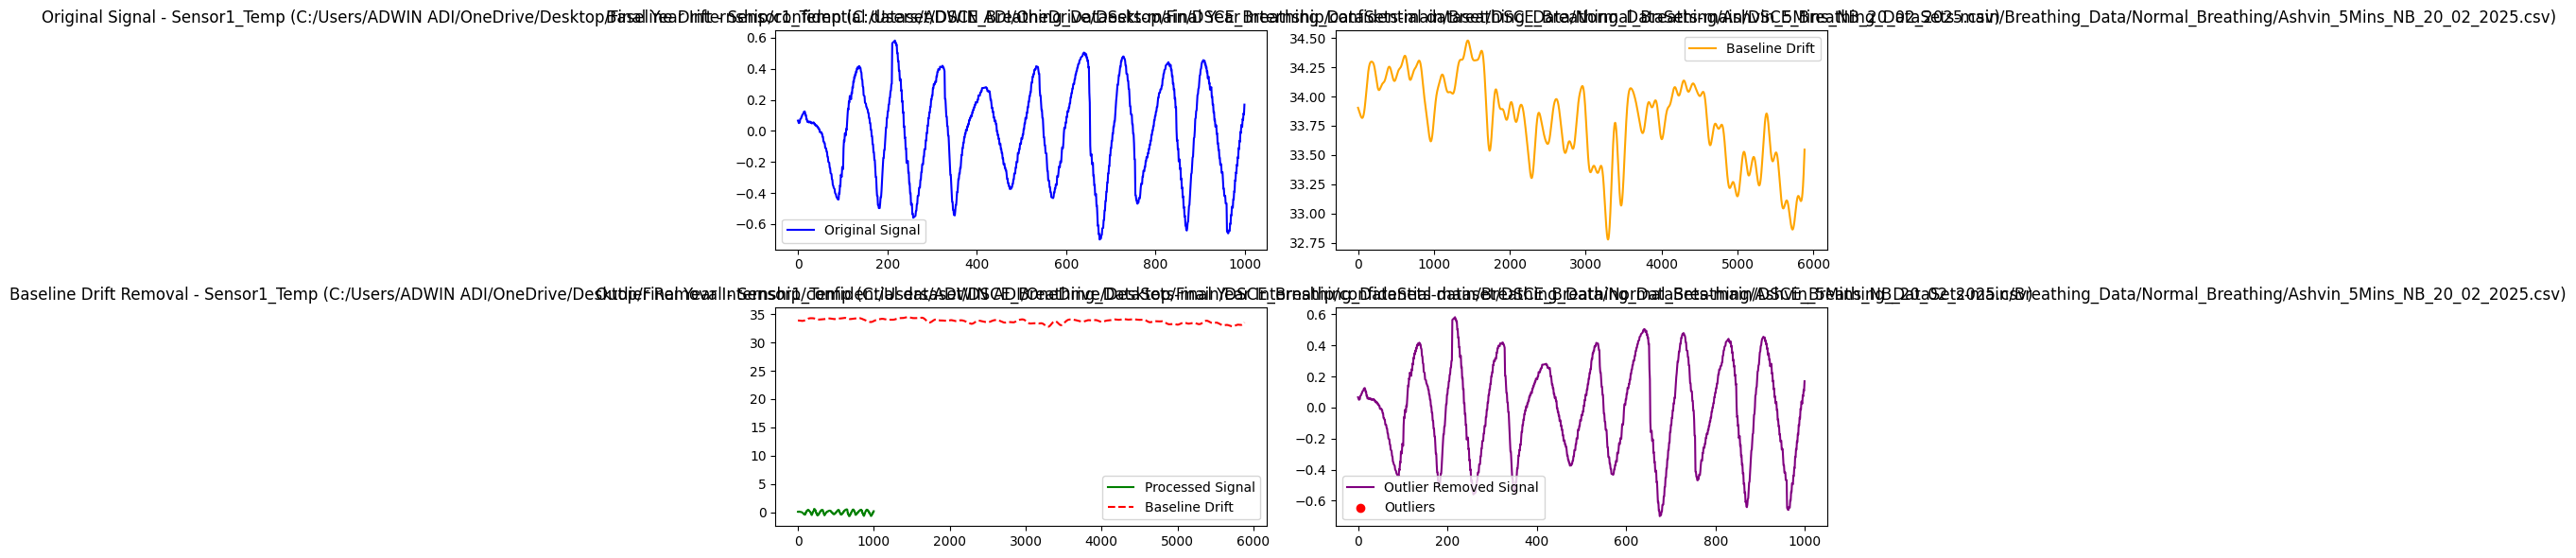

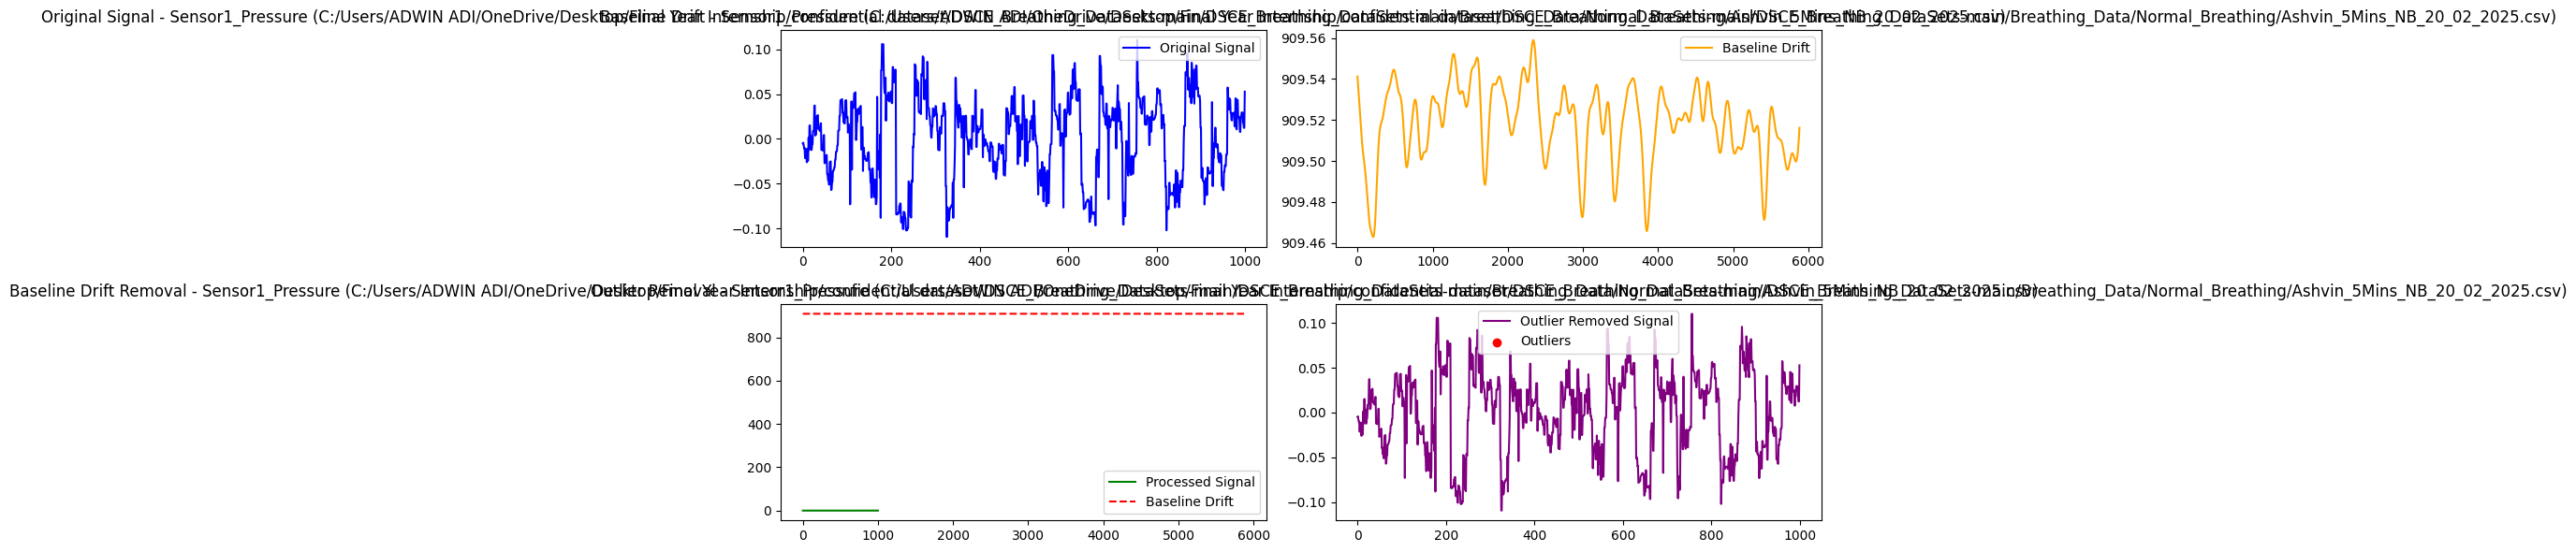

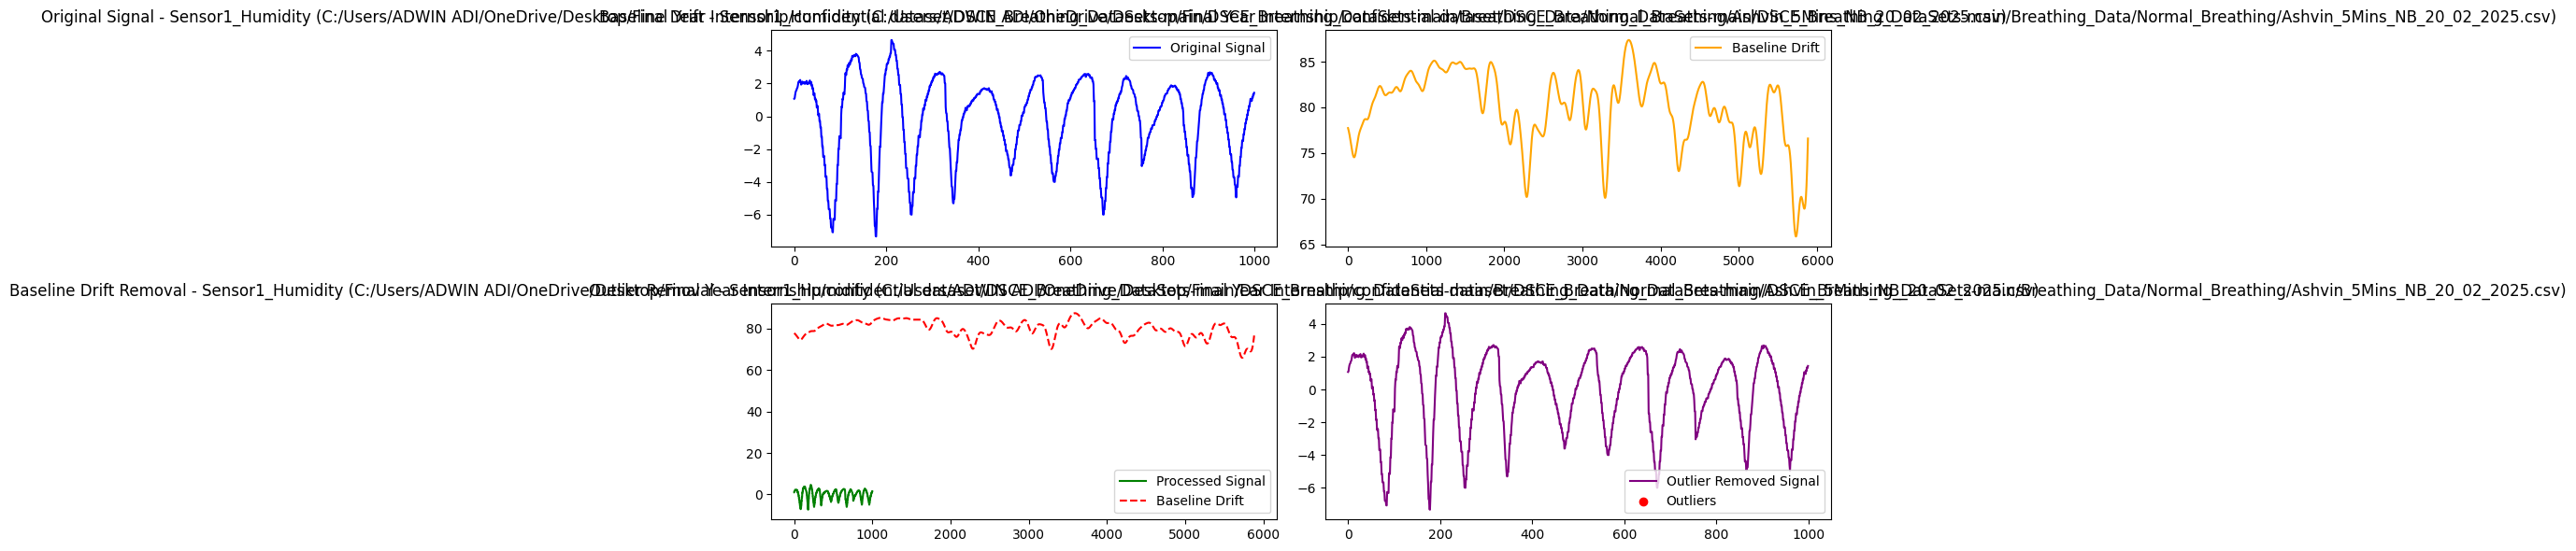

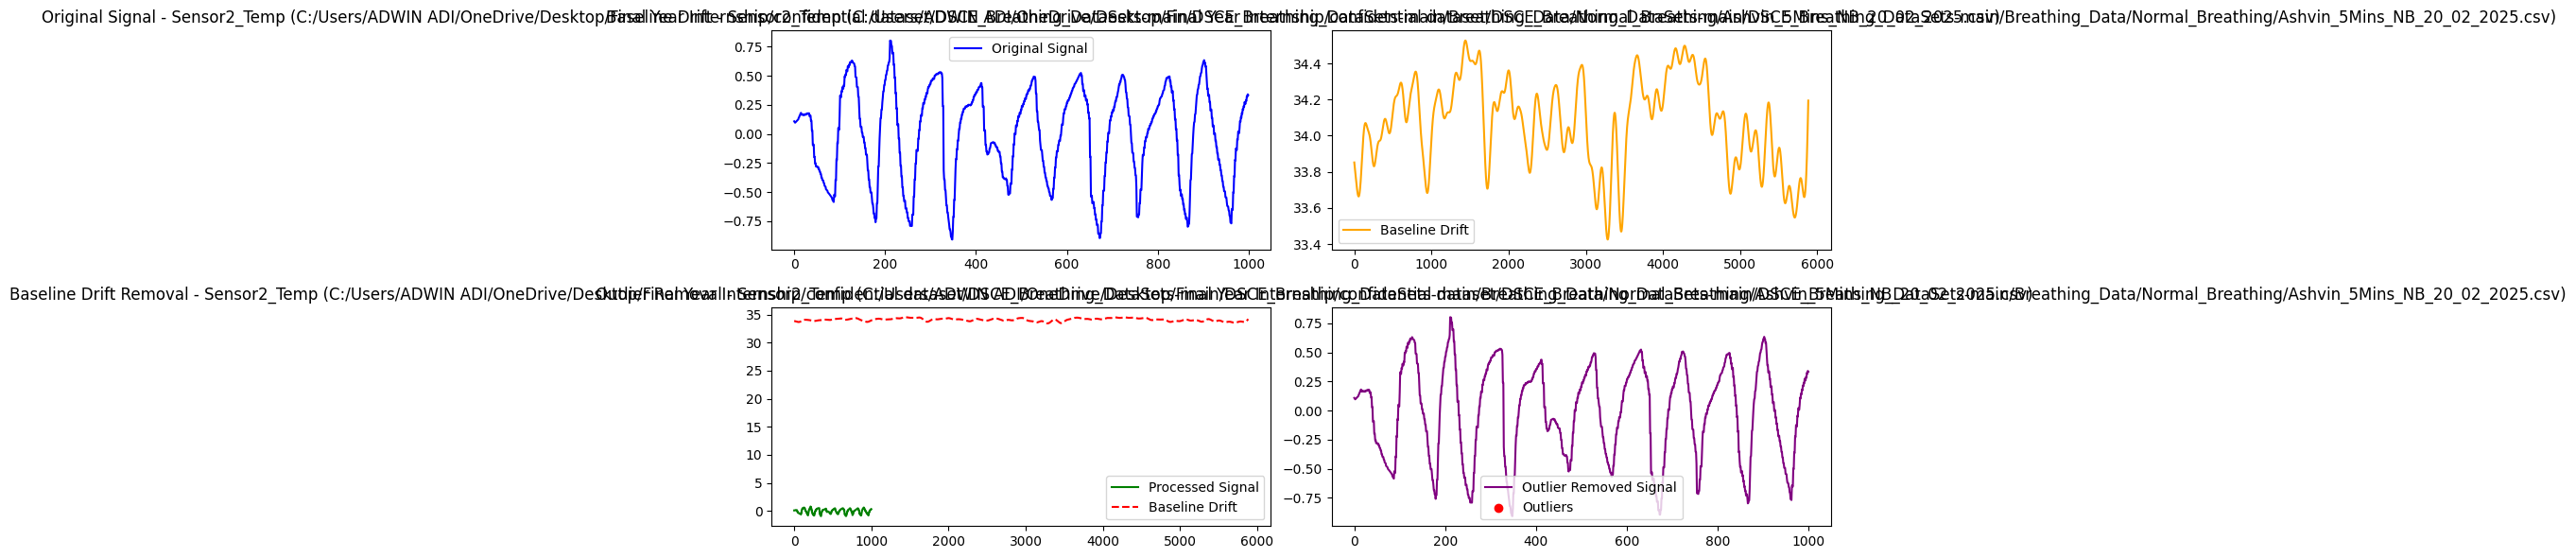

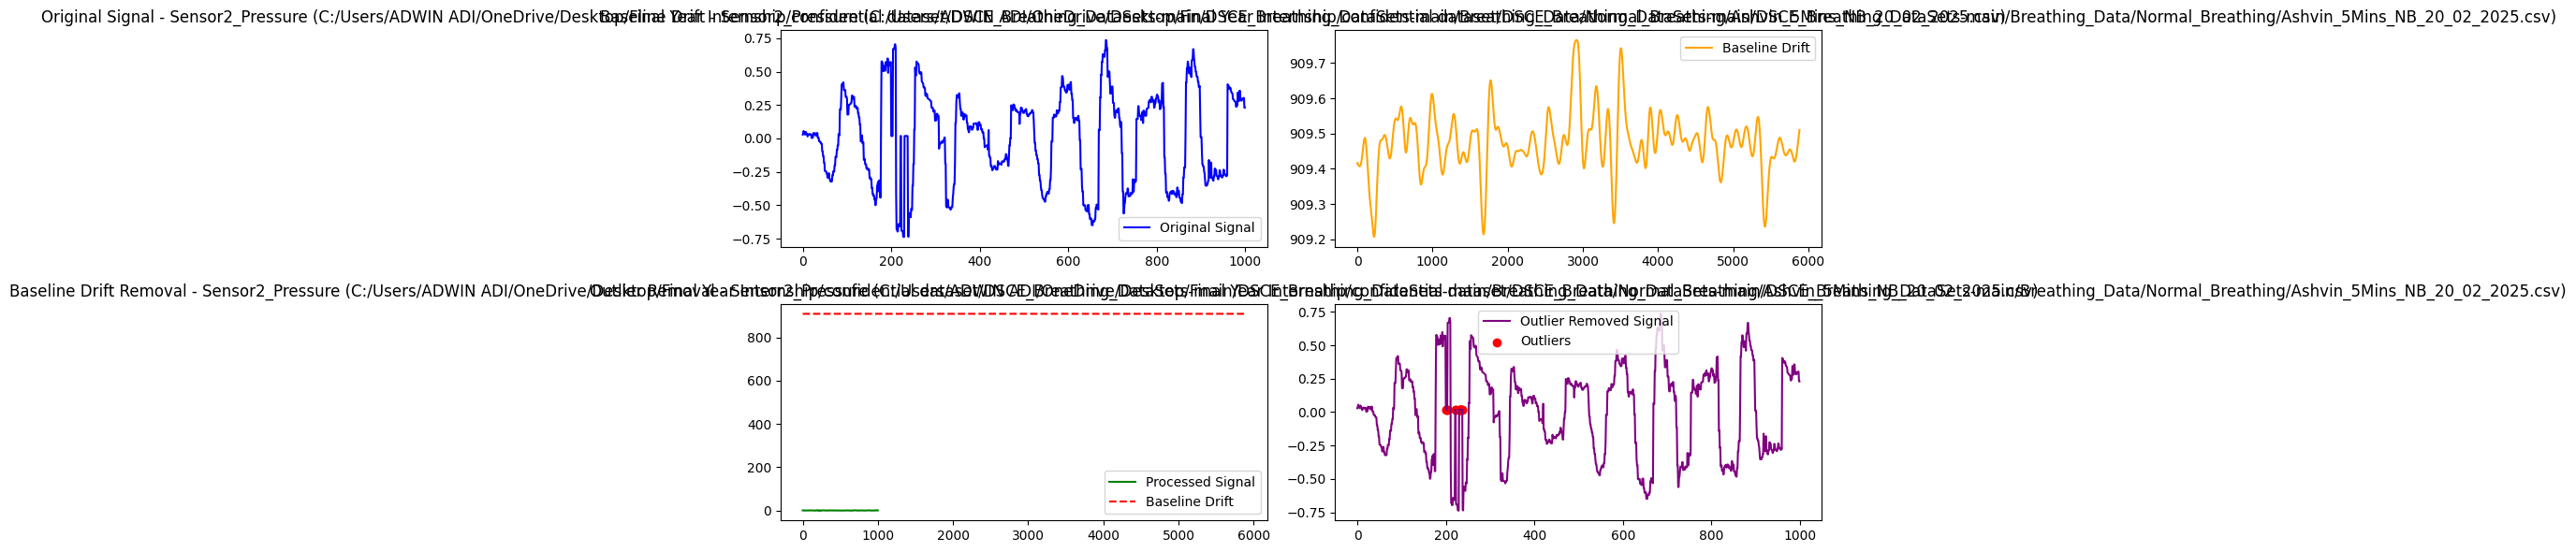

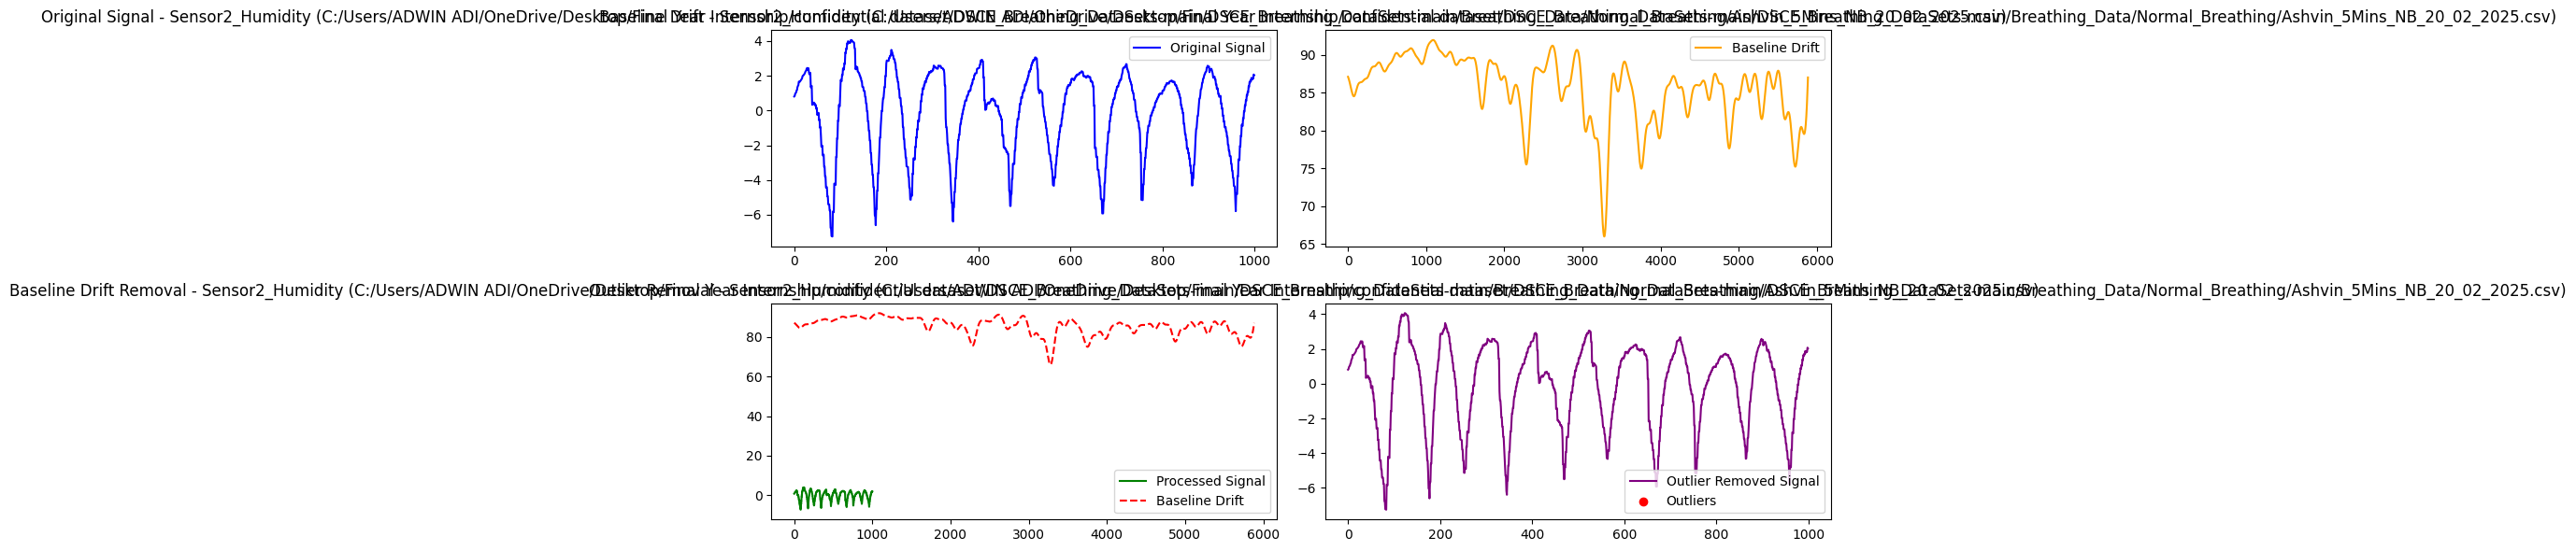


===== Training for 10 epochs on C:/Users/ADWIN ADI/OneDrive/Desktop/Final Year Internship/confidential dataset/DSCE_Breathing_DataSets-main/DSCE_Breathing_DataSets-main/Breathing_Data/Normal_Breathing/Ashvin_5Mins_NB_20_02_2025.csv =====
Epoch 1/10
294/294 [==============================] - 6s 11ms/step - loss: nan - accuracy: 0.9302
Epoch 2/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 3/10
294/294 [==============================] - 3s 12ms/step - loss: nan - accuracy: 0.9308
Epoch 4/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 5/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 6/10
294/294 [==============================] - 3s 12ms/step - loss: nan - accuracy: 0.9308
Epoch 7/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 8/10
294/294 [==============================] - 3s 12ms/step - loss: 

ValueError: Input contains NaN.

In [2]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to load files using Tkinter
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    if not file_paths:
        print("No file selected. Exiting...")
        exit()
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score method
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Function to ensure all signals have 1000 samples
def ensure_1000_samples(df, numeric_columns):
    for col in numeric_columns:
        if len(df[col]) > 1000:
            df[col] = df[col][:1000]  # Trim
        elif len(df[col]) < 1000:
            df[col] = np.pad(df[col], (0, 1000 - len(df[col])), mode='constant')  # Pad
    return df

# Data Preprocessing Function
def preprocess_data(df):
    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    # Fill NaN values using interpolation
    df[numeric_columns] = df[numeric_columns].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
    
    baseline_drift = df[numeric_columns].apply(lambda x: x - high_pass_filter(x))
    df[numeric_columns] = df[numeric_columns].apply(high_pass_filter)
    
    outliers = df[numeric_columns].apply(lambda x: np.abs(zscore(x)) > 3)
    df[numeric_columns] = df[numeric_columns].apply(remove_outliers)

    df = ensure_1000_samples(df, numeric_columns)

    return df, numeric_columns, baseline_drift, outliers

# Function to plot signals with file name annotation
def plot_signals(df, numeric_columns, baseline_drift, outliers, file_name):
    for col in numeric_columns:
        plt.figure(figsize=(12, 6))
        
        # Original Signal
        plt.subplot(2, 2, 1)
        plt.plot(df[col], label="Original Signal", color="blue")
        plt.title(f"Original Signal - {col} ({file_name})")
        plt.legend()

        # Baseline Drift
        plt.subplot(2, 2, 2)
        plt.plot(baseline_drift[col], label="Baseline Drift", color="orange")
        plt.title(f"Baseline Drift - {col} ({file_name})")
        plt.legend()

        # Baseline Drift Removal
        plt.subplot(2, 2, 3)
        plt.plot(df[col], label="Processed Signal", color="green")
        plt.plot(baseline_drift[col], label="Baseline Drift", color="red", linestyle="dashed")
        plt.title(f"Baseline Drift Removal - {col} ({file_name})")
        plt.legend()

        # Outlier Removal
        plt.subplot(2, 2, 4)
        plt.plot(df[col], label="Outlier Removed Signal", color="purple")
        outlier_points = df[col][outliers[col]]
        plt.scatter(outlier_points.index, outlier_points, color="red", label="Outliers")
        plt.title(f"Outlier Removal - {col} ({file_name})")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Load and Process Data
file_paths = load_files()
dataframes = [(pd.read_csv(file), file) for file in file_paths]
processed_data = []

for df, file_name in dataframes:
    df, numeric_columns, baseline_drift, outliers = preprocess_data(df)
    processed_data.append((df, numeric_columns, baseline_drift, outliers, file_name))
    plot_signals(df, numeric_columns, baseline_drift, outliers, file_name)

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(50, activation='relu'),
        Dense(input_shape[1], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to Calculate Performance Metrics
def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    accuracy = accuracy_score(y_true.flatten(), y_pred_binary.flatten())
    specificity = recall_score(y_true.flatten(), y_pred_binary.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten(), zero_division=1)
    loss = mean_squared_error(y_true.flatten(), y_pred.flatten())  # Ensure correct shape

    return accuracy, specificity, f1, loss

# Scaling Data and Training
for df, numeric_columns, _, _, file_name in processed_data:
    scaler = MinMaxScaler()
    processed_values = scaler.fit_transform(df[numeric_columns])

    # Prepare Data for Training
    X, y = [], []
    seq_length = 10
    for i in range(len(processed_values) - seq_length):
        X.append(processed_values[i:i+seq_length])
        y.append(processed_values[i+seq_length])
    
    X, y = np.array(X), np.array(y)
    y = (y > 0.5).astype(int)  # Binary classification

    # Split Data into Train & Test
    train_size = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

    # Training for Different Epochs
    performance_data = []
    epochs_list = [10, 30, 50, 75, 100]

    for num_epochs in epochs_list:
        print(f"\n===== Training for {num_epochs} epochs on {file_name} =====")

        # Train LSTM
        lstm_model = build_lstm_model((seq_length, len(numeric_columns)))
        lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, verbose=1)
        y_pred_lstm = lstm_model.predict(X_test)
        
        lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)
        performance_data.append([num_epochs, lstm_loss, lstm_acc, lstm_spec, lstm_f1])

    # Store Performance in a DataFrame
    performance_df = pd.DataFrame(performance_data, columns=["Epochs", "LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score"])
    print(performance_df)

    # Plot Model Performance
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_list, performance_df["LSTM Accuracy"], marker='o', label=f"LSTM Accuracy ({file_name})", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"LSTM Accuracy Across Epochs ({file_name})")
    plt.legend()
    plt.show()


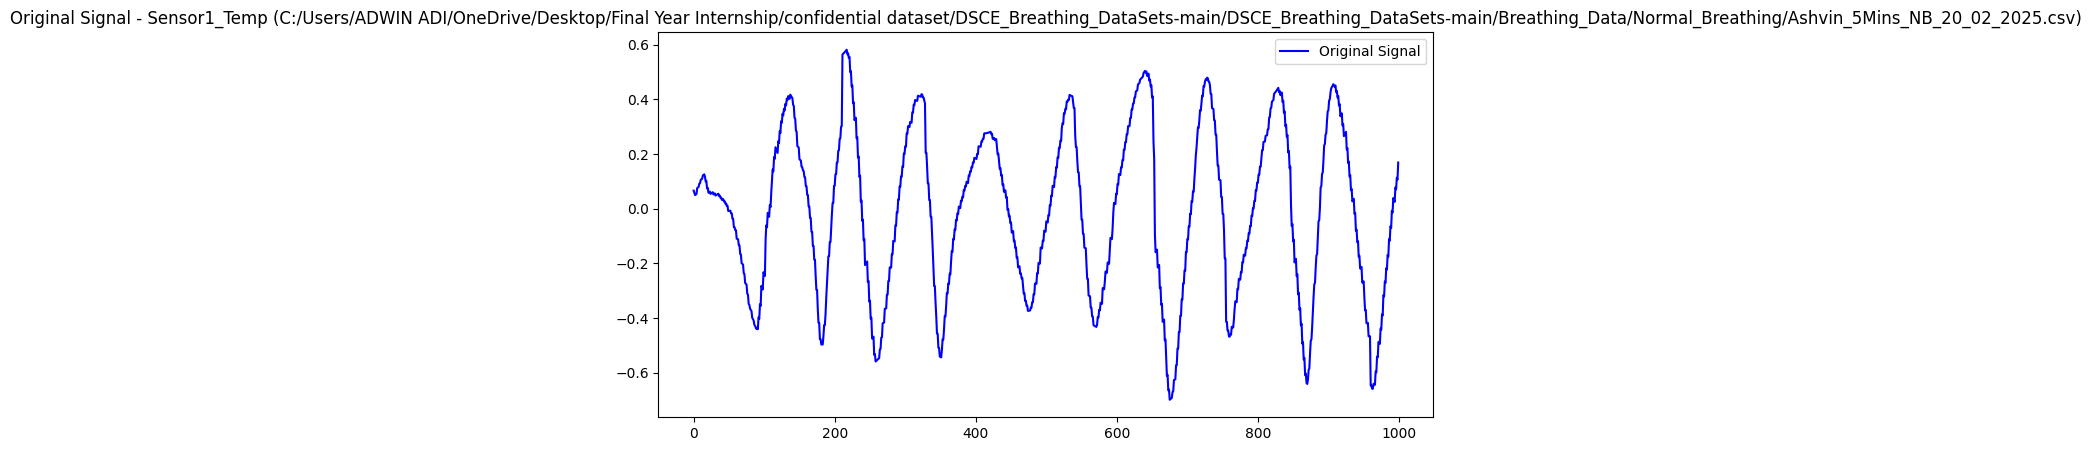

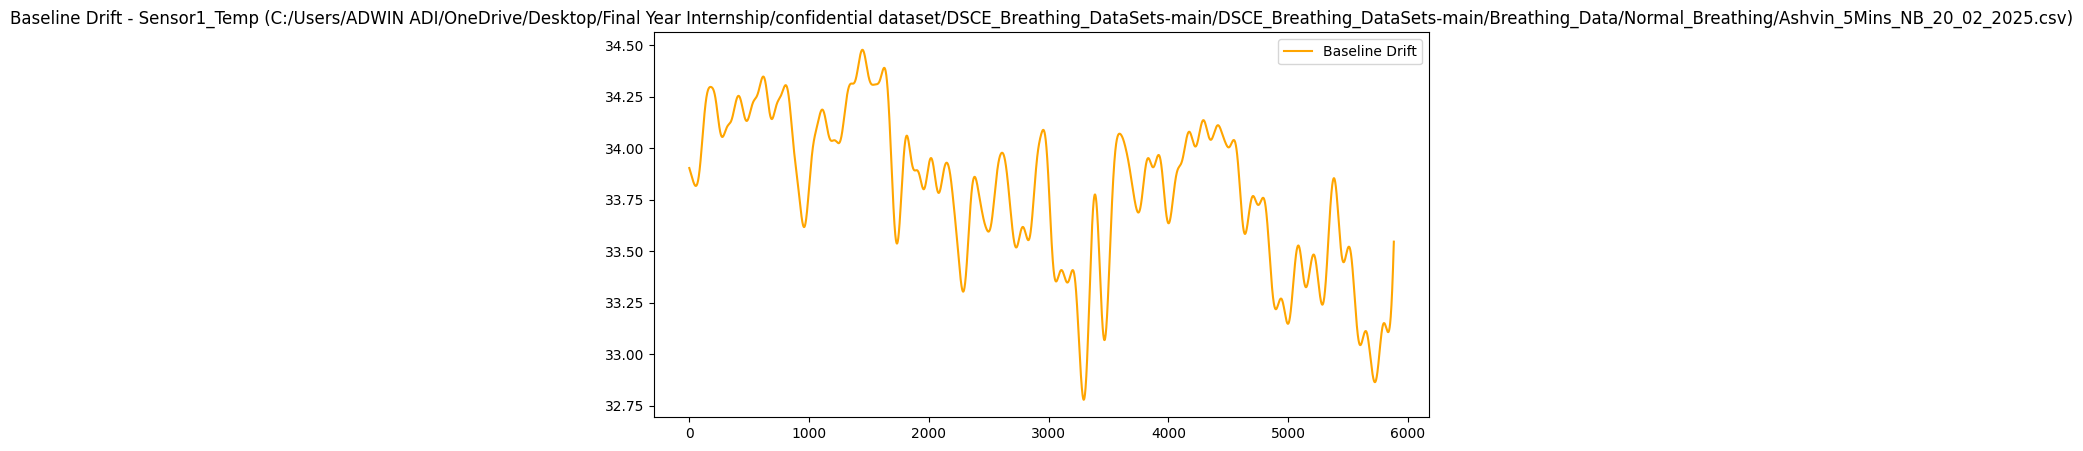

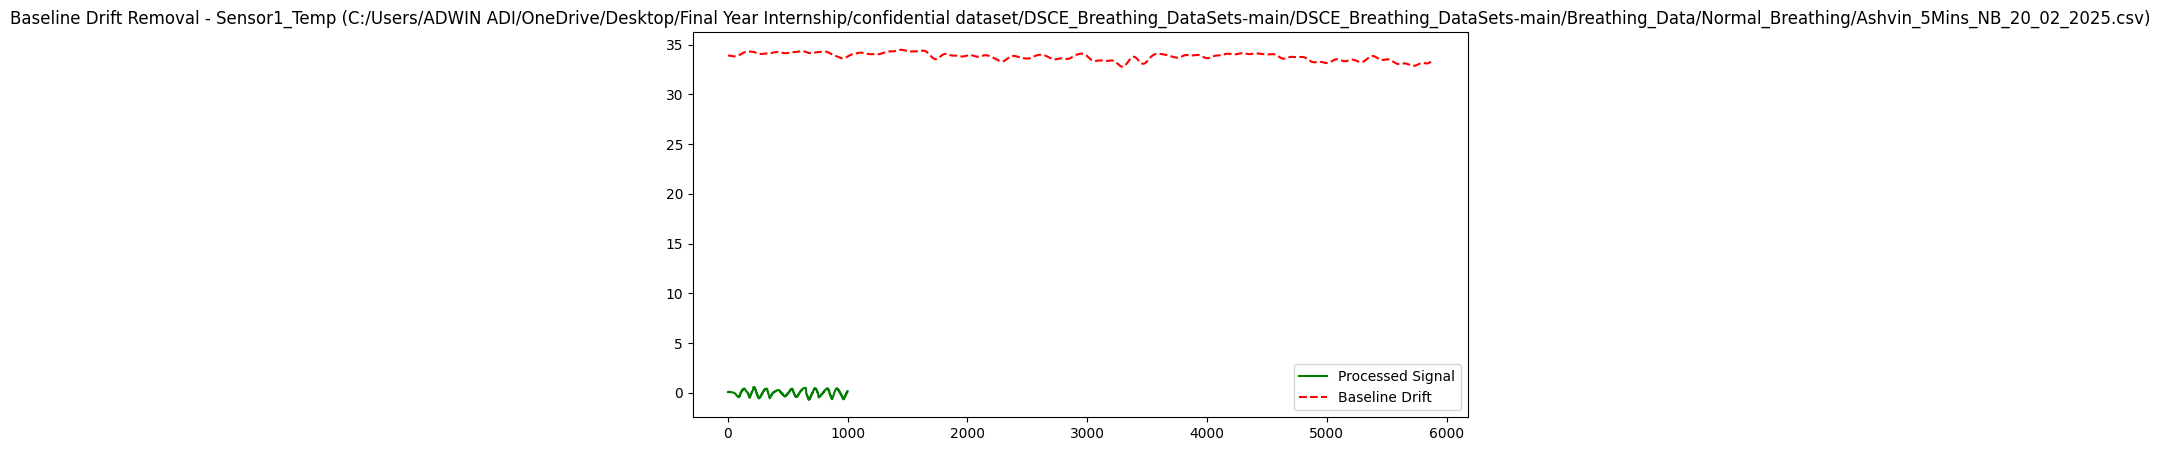

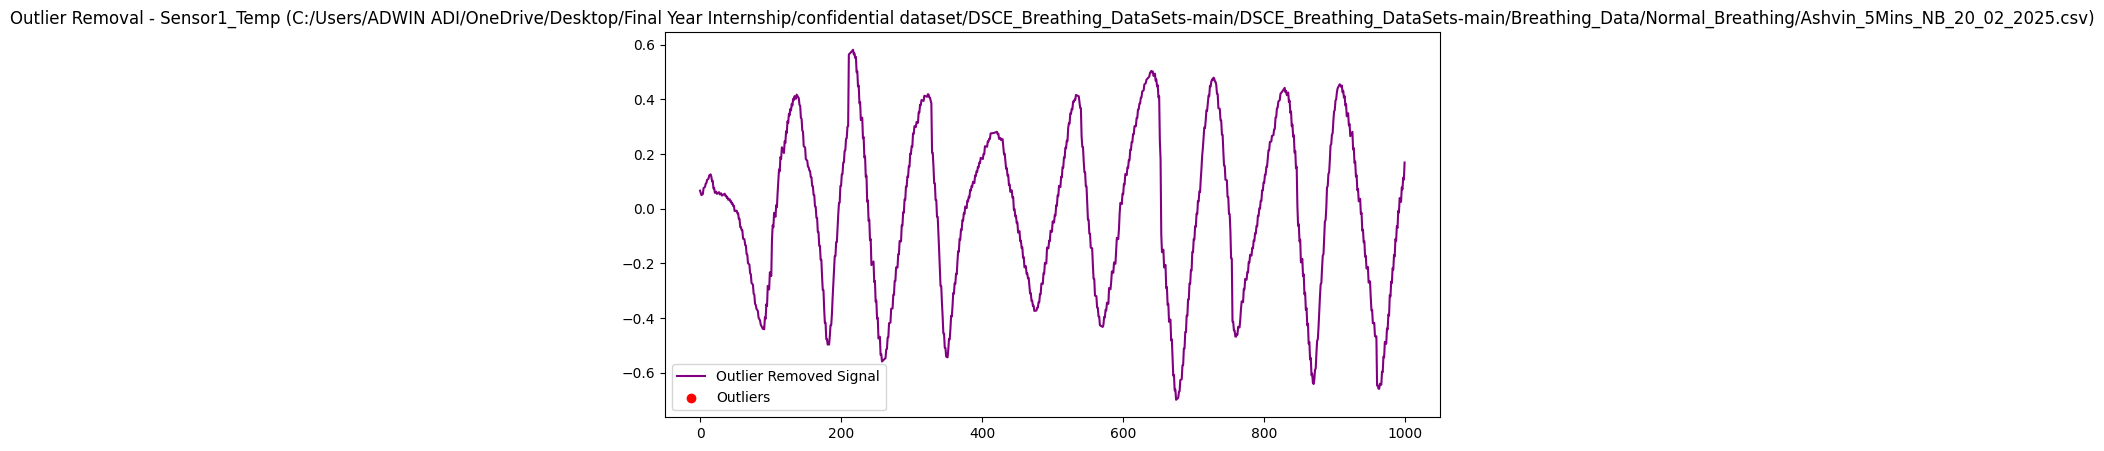

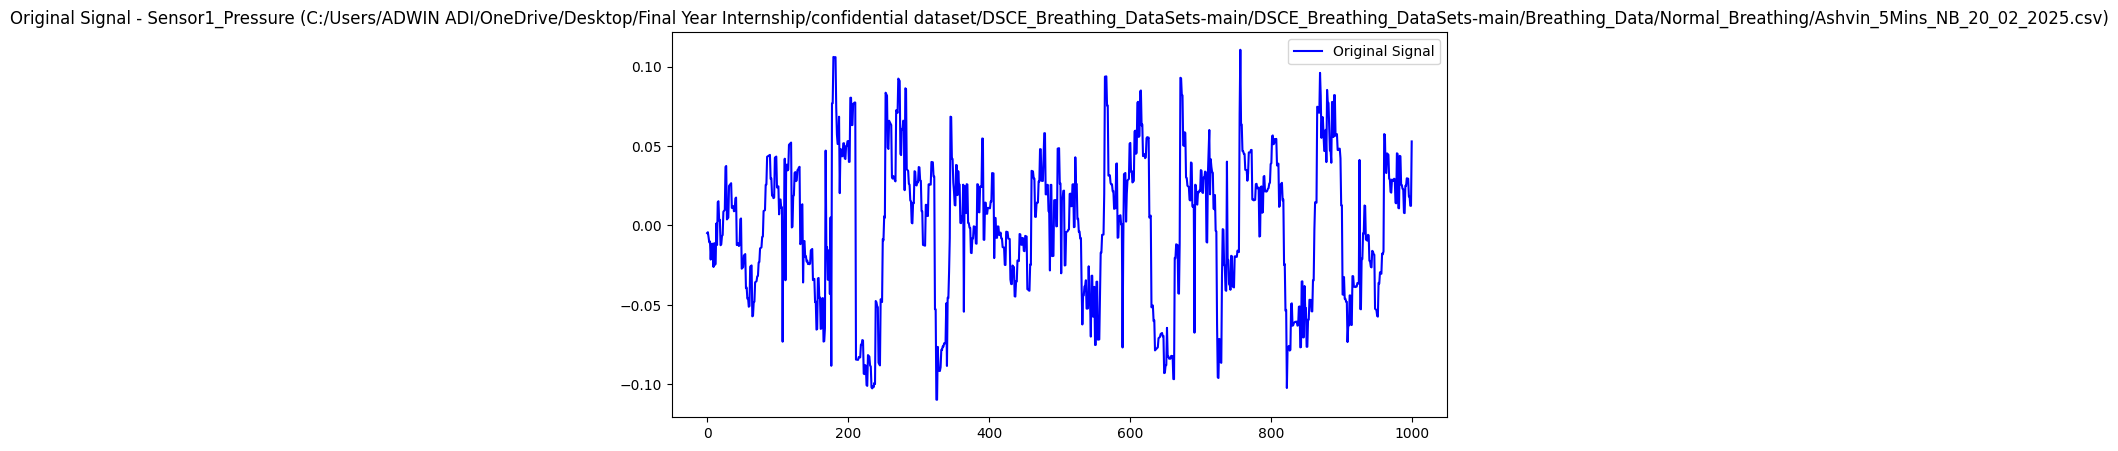

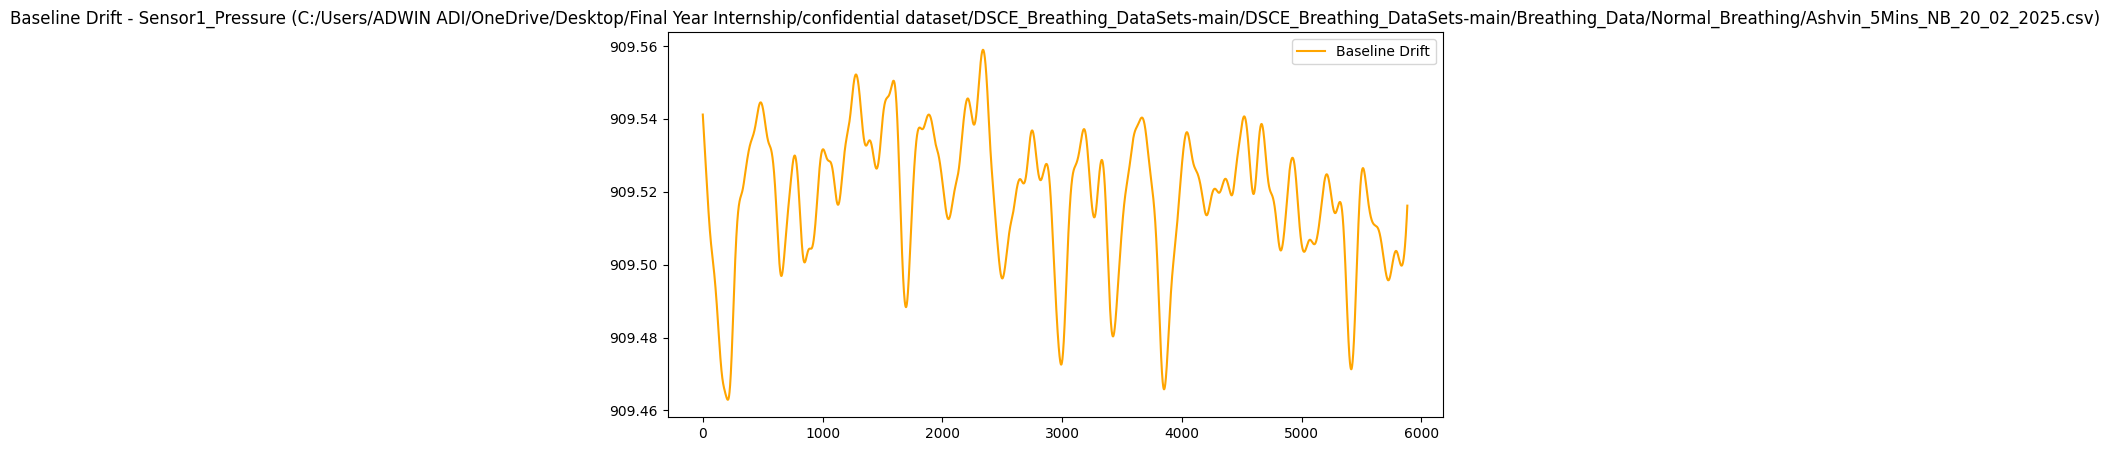

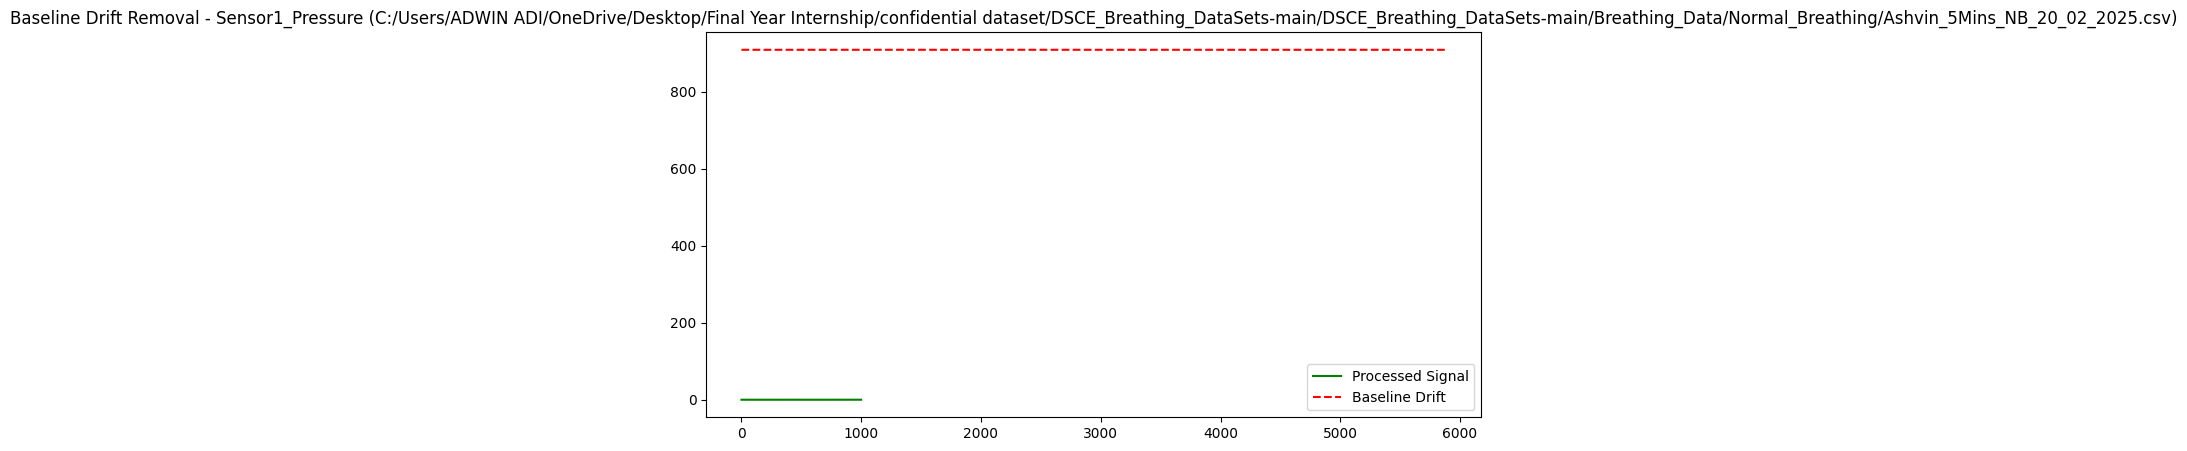

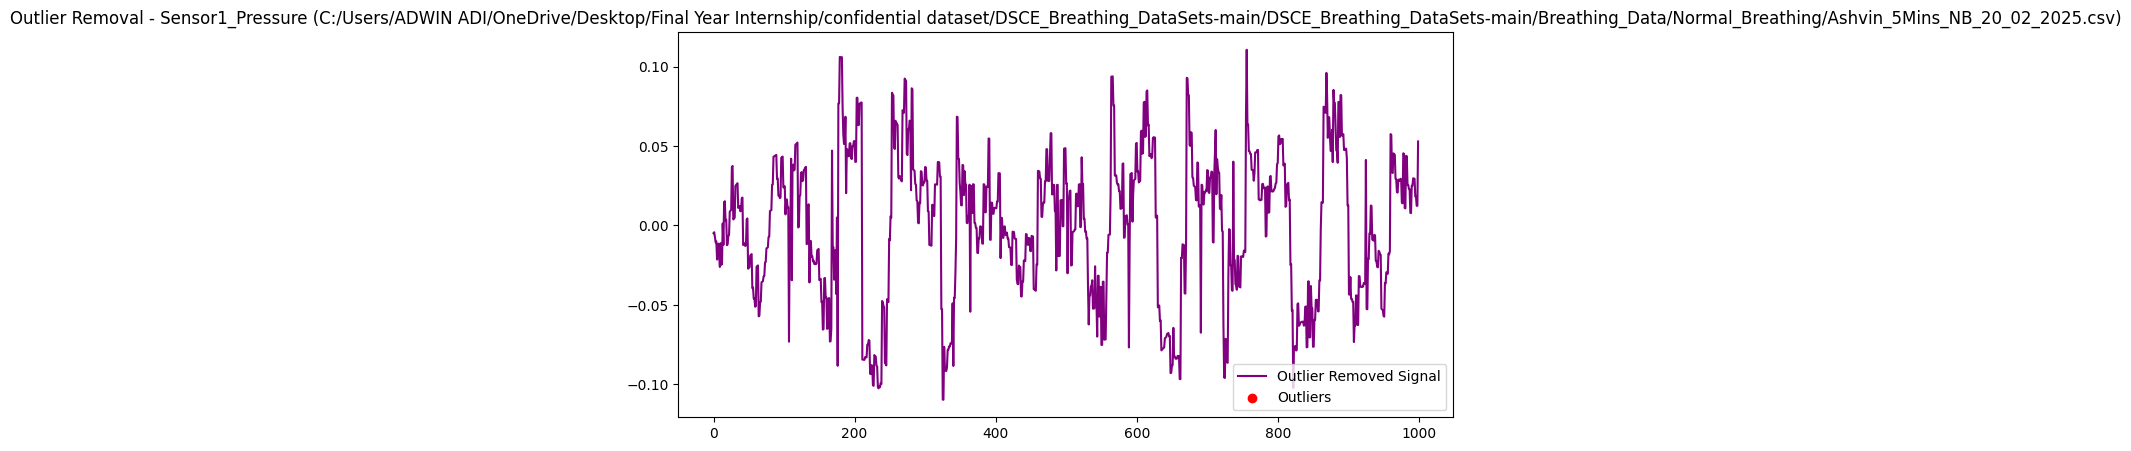

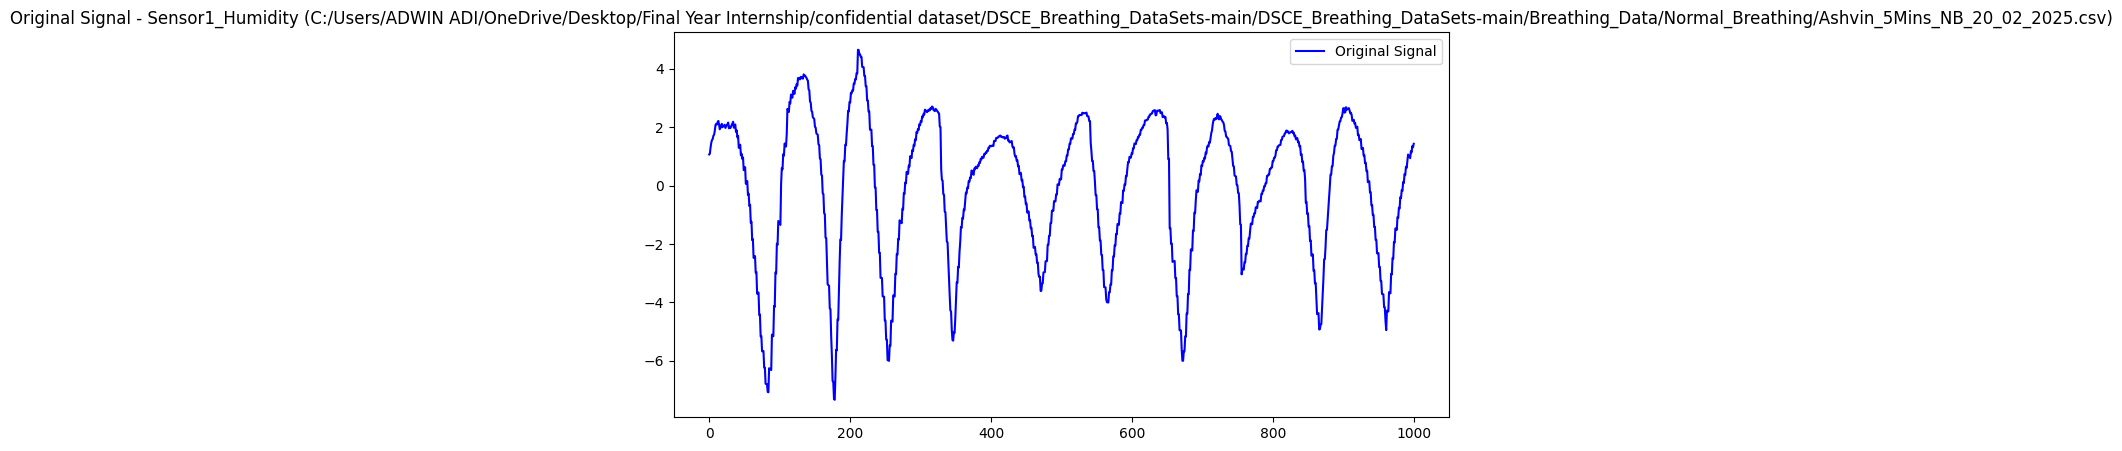

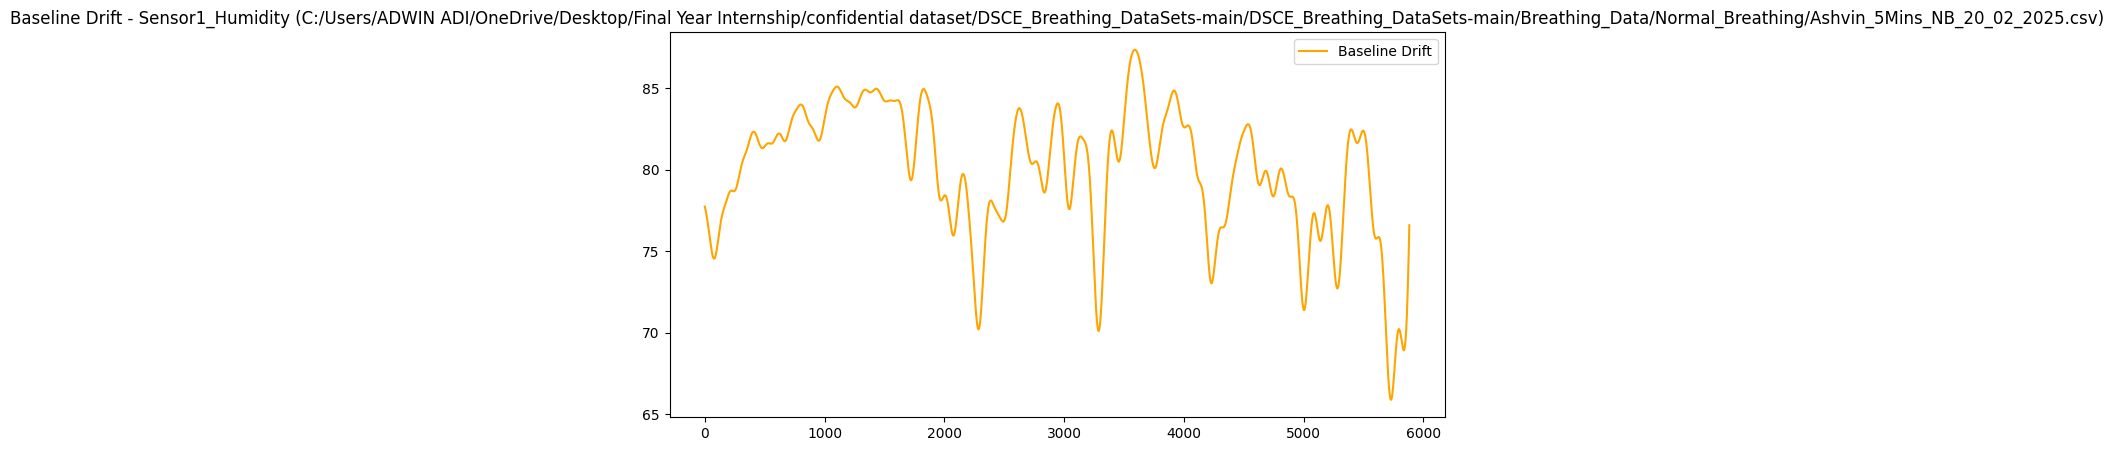

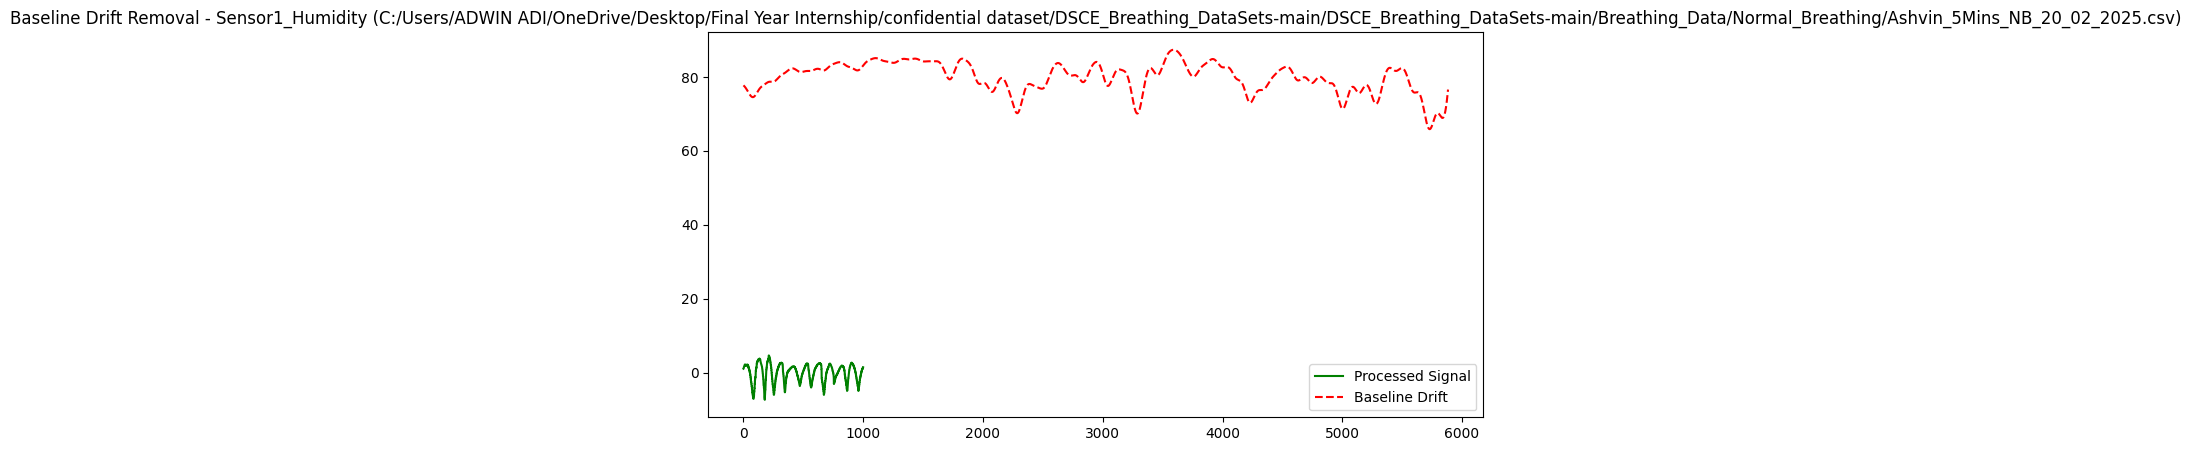

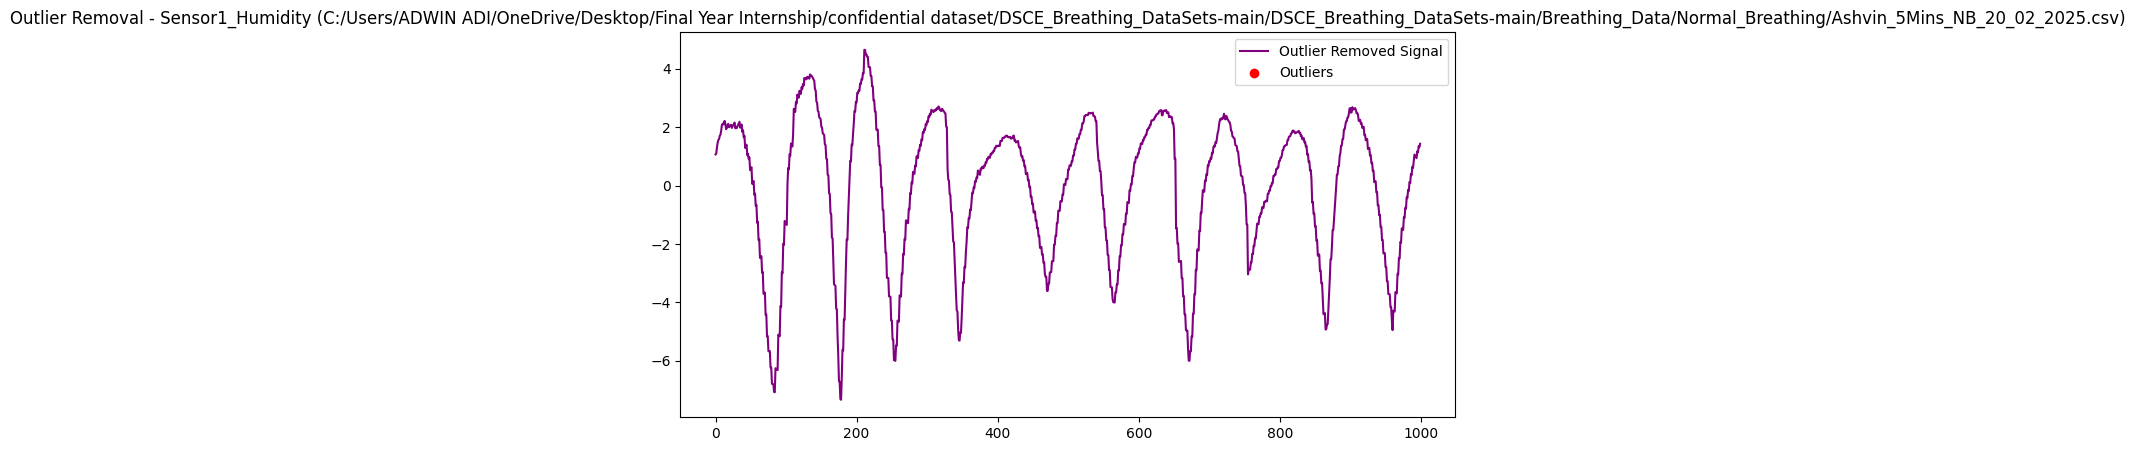

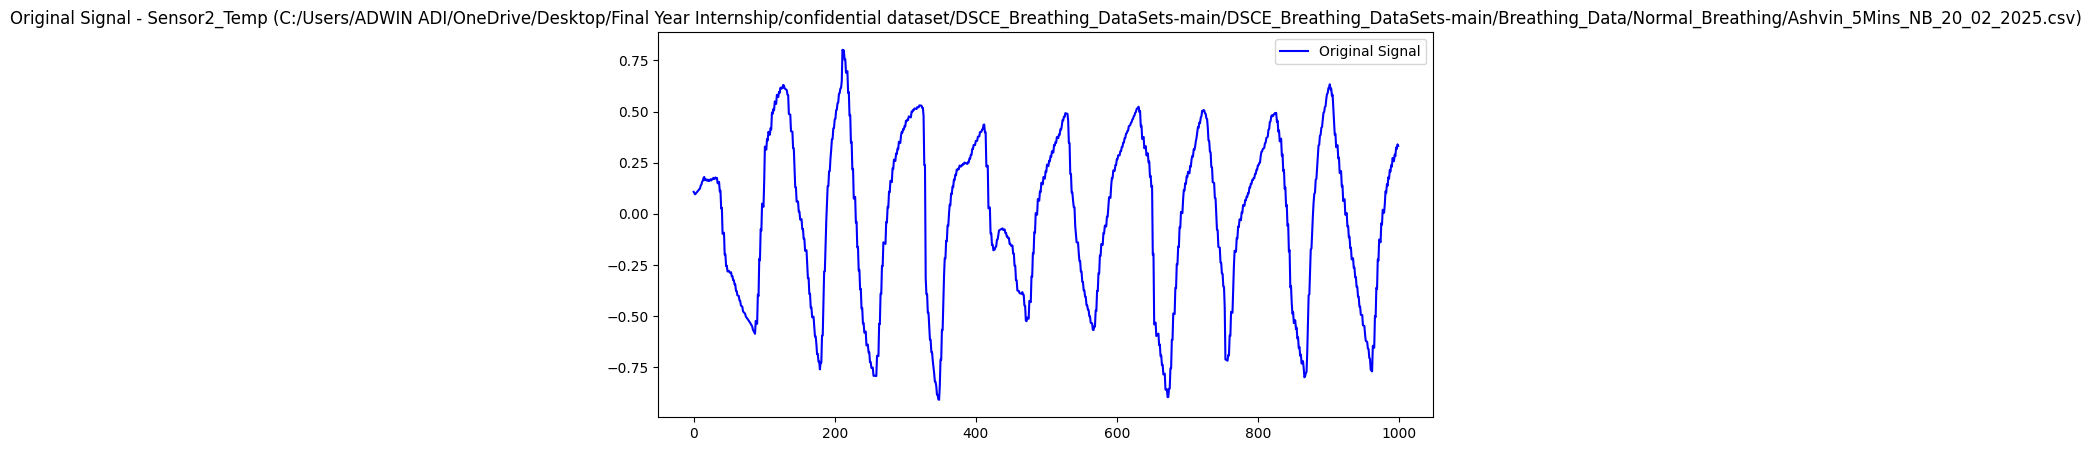

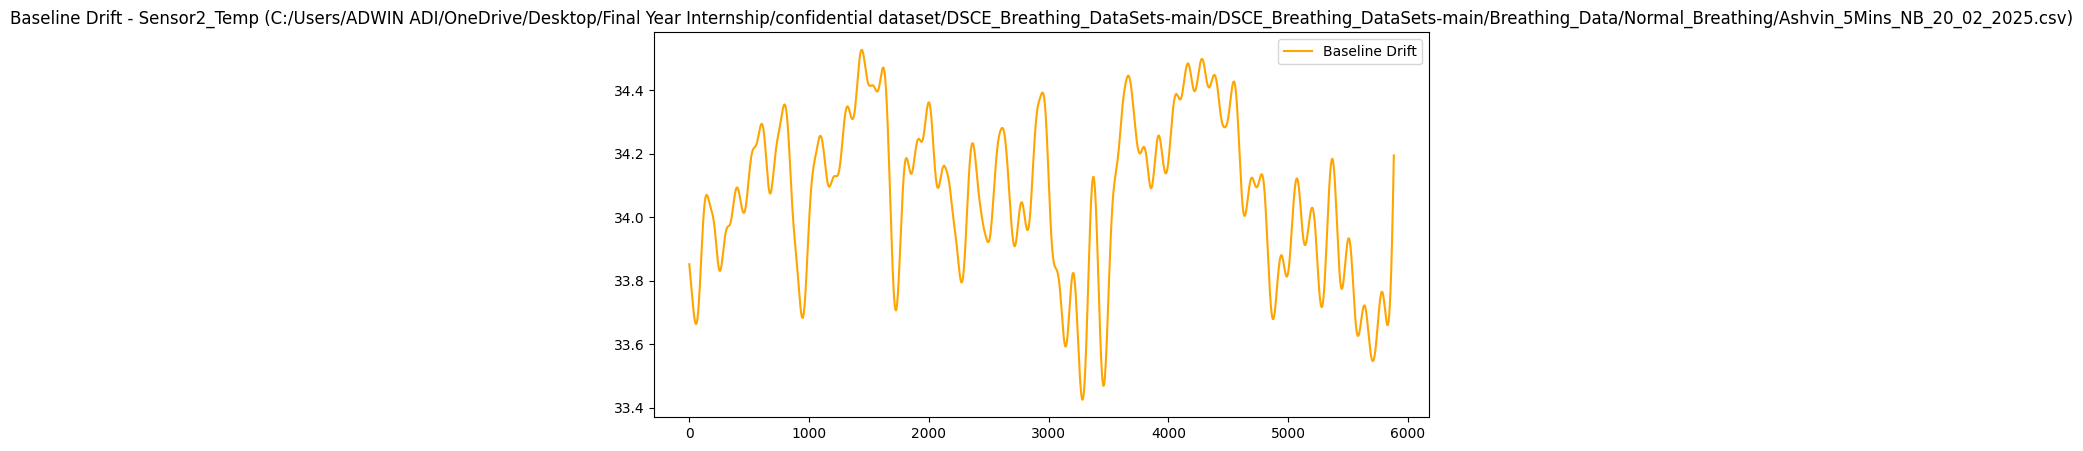

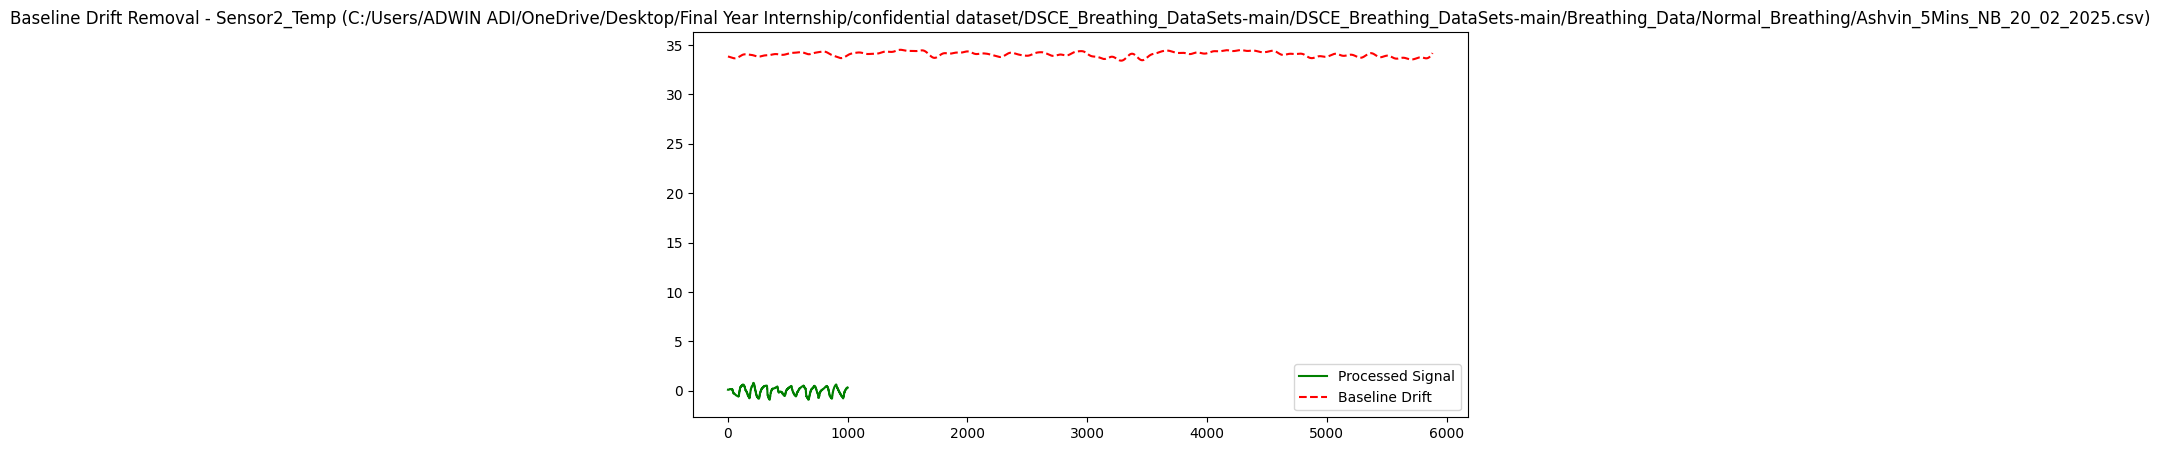

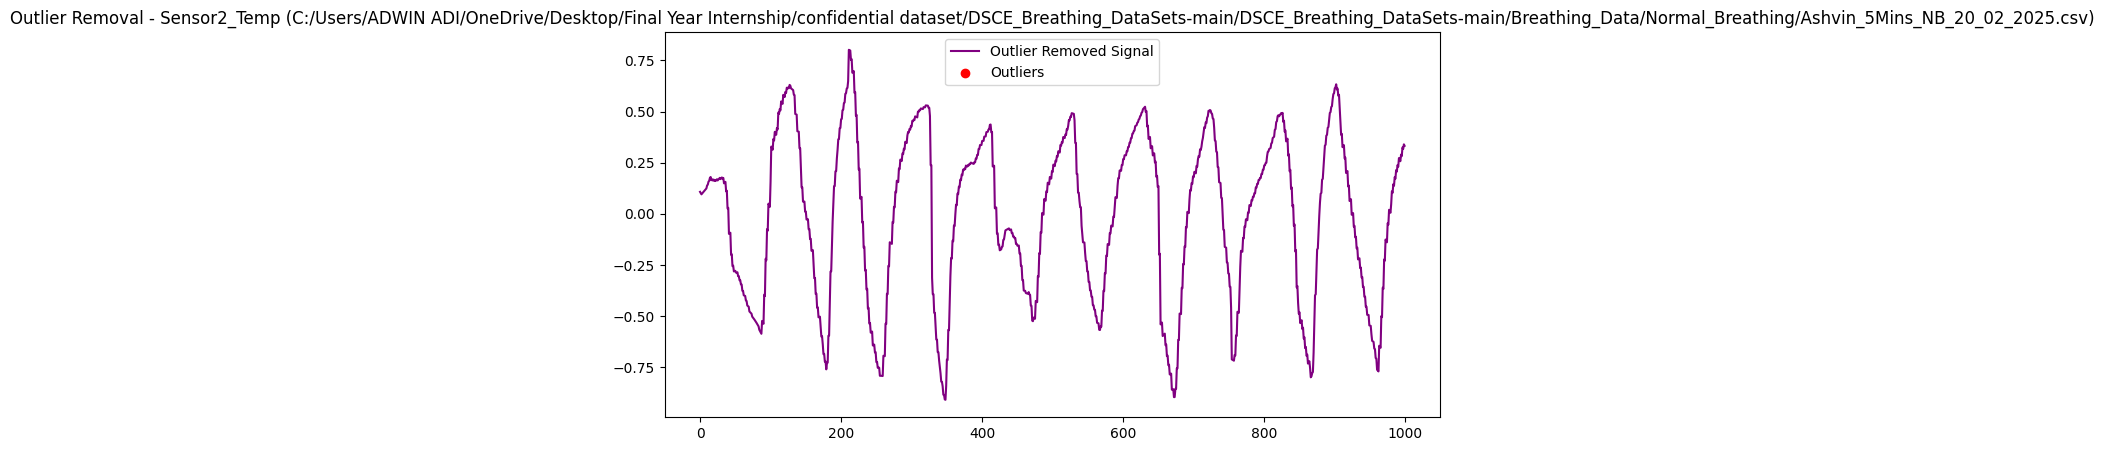

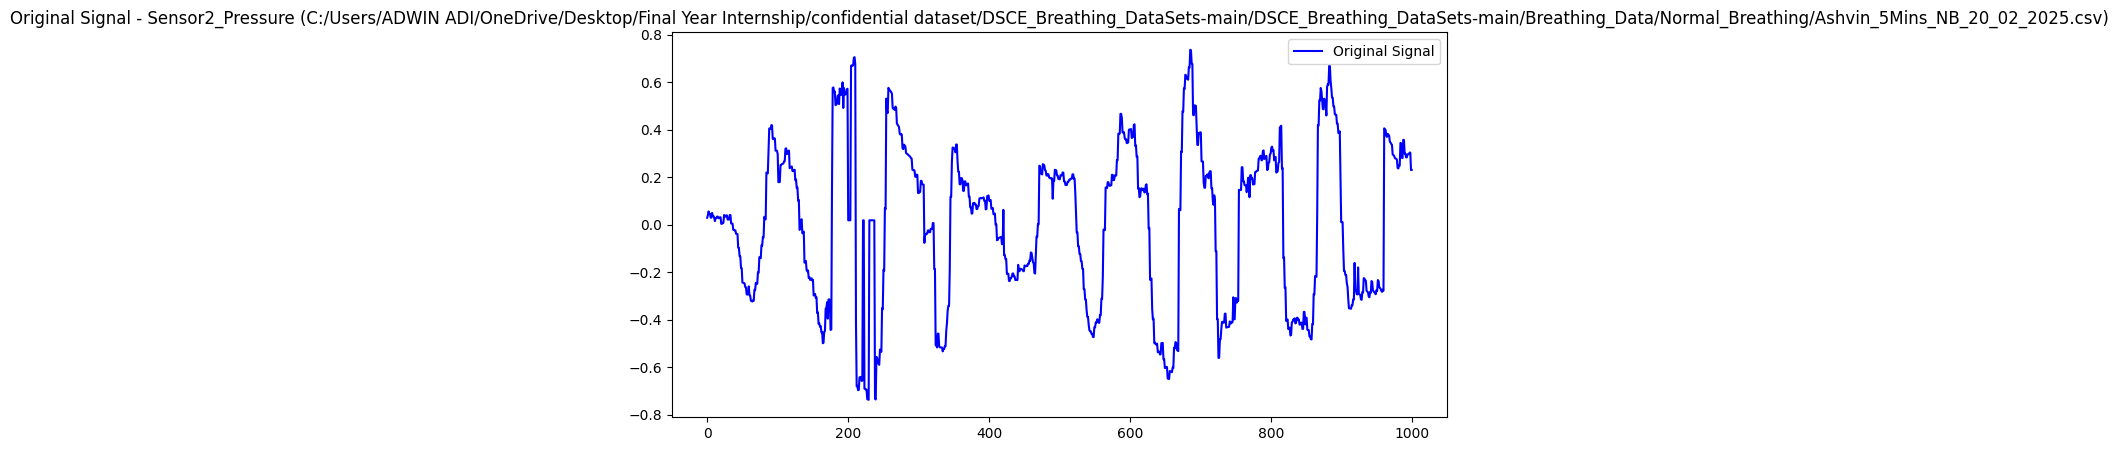

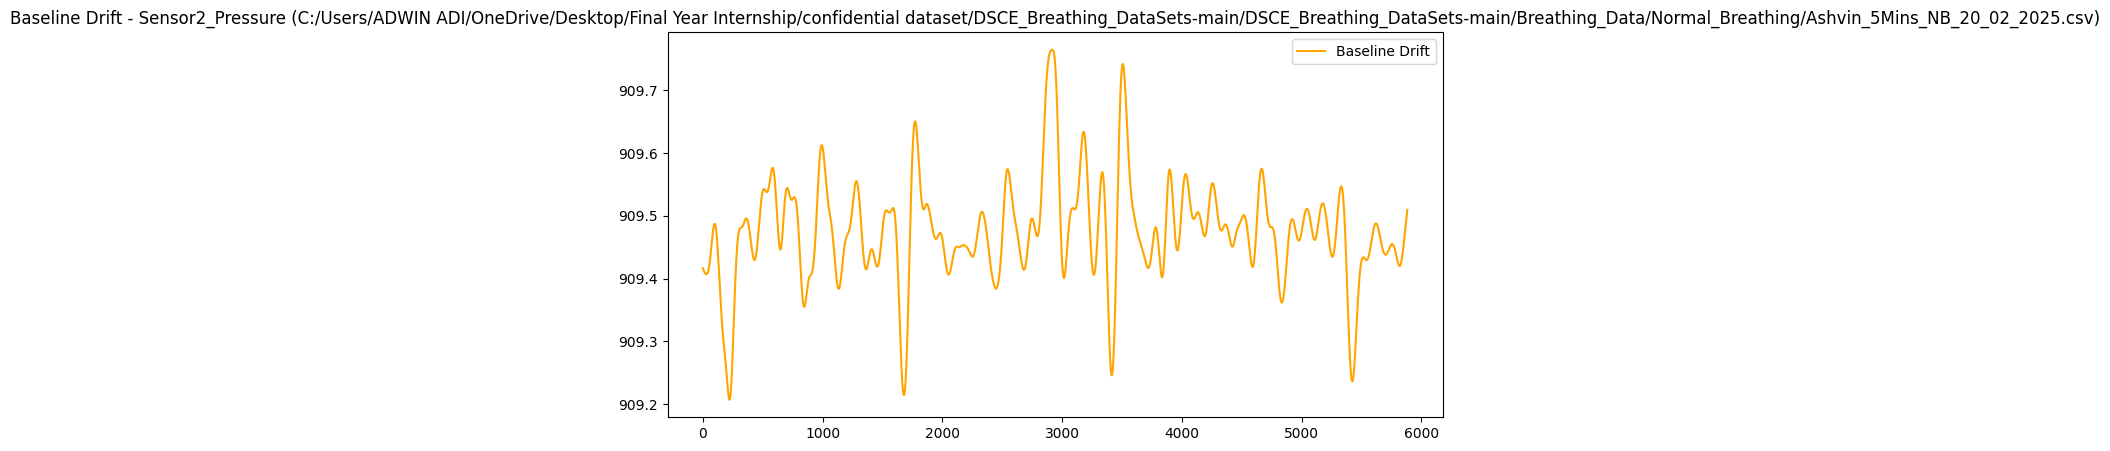

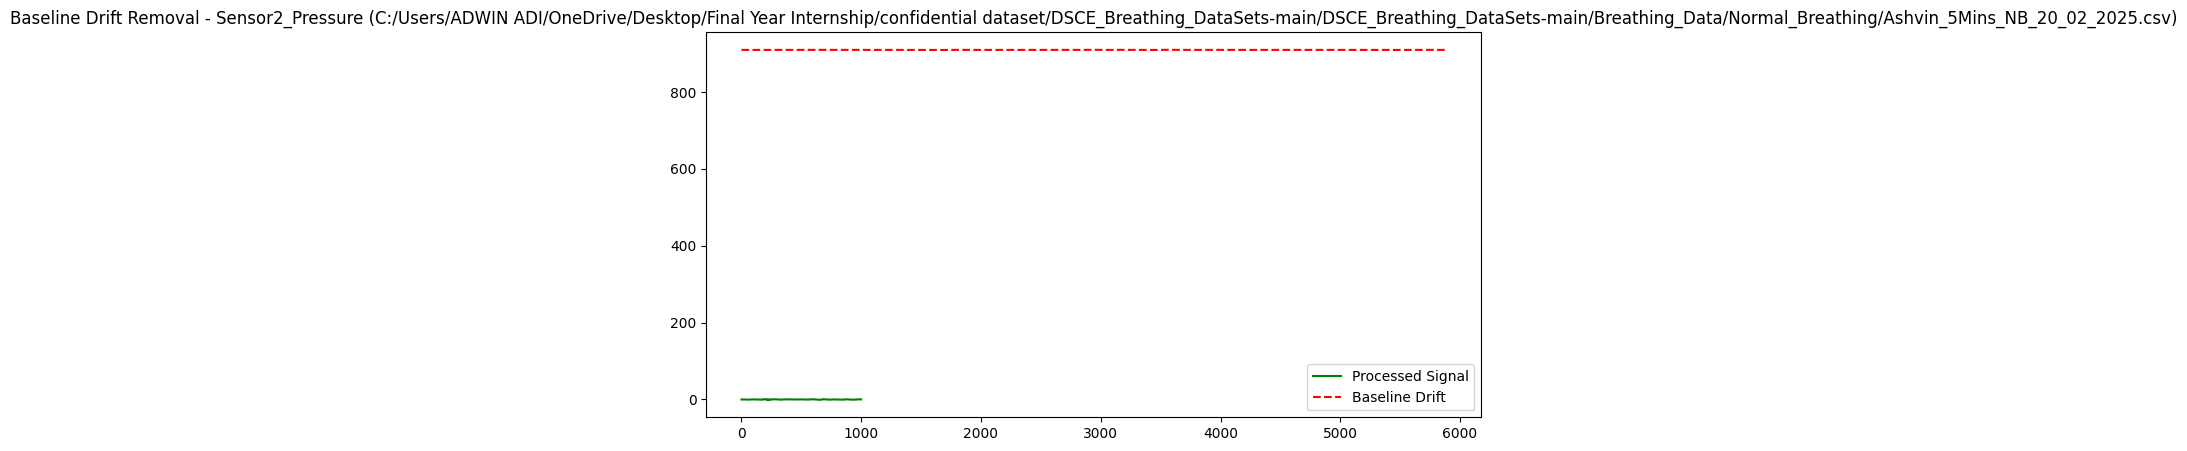

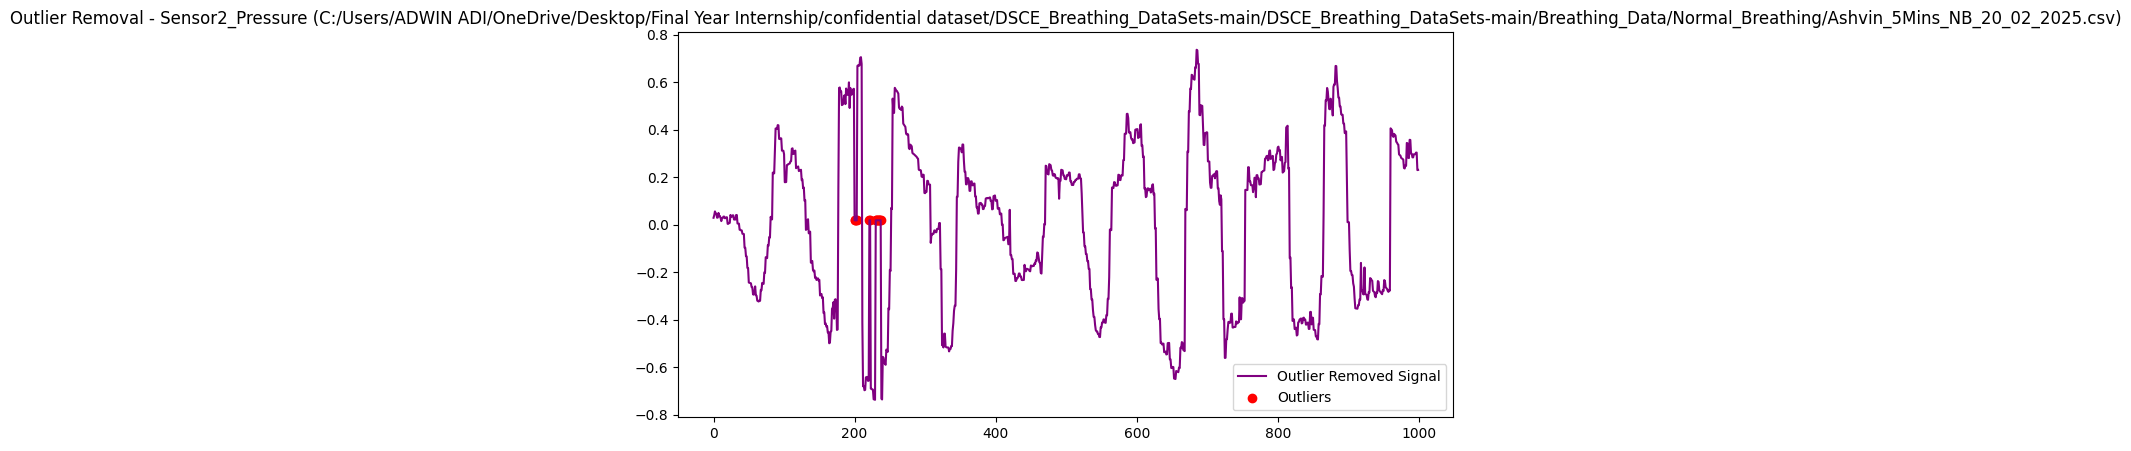

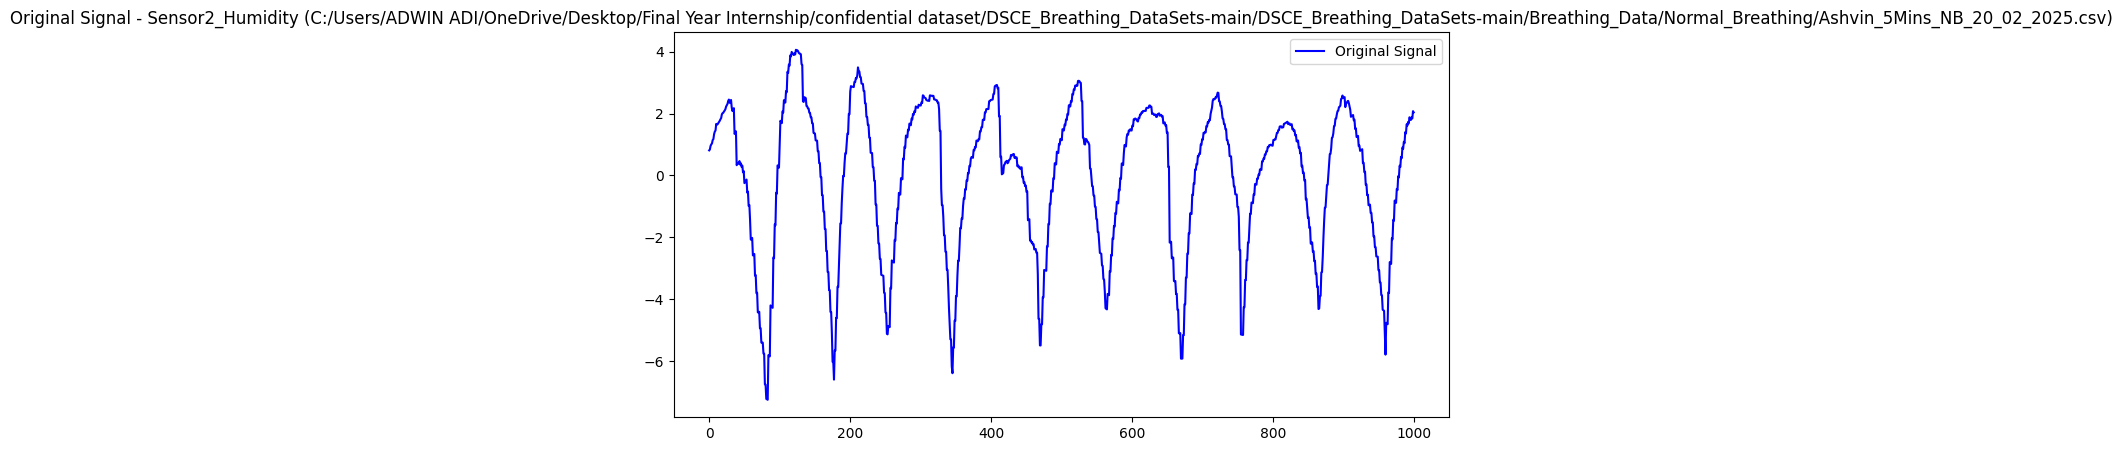

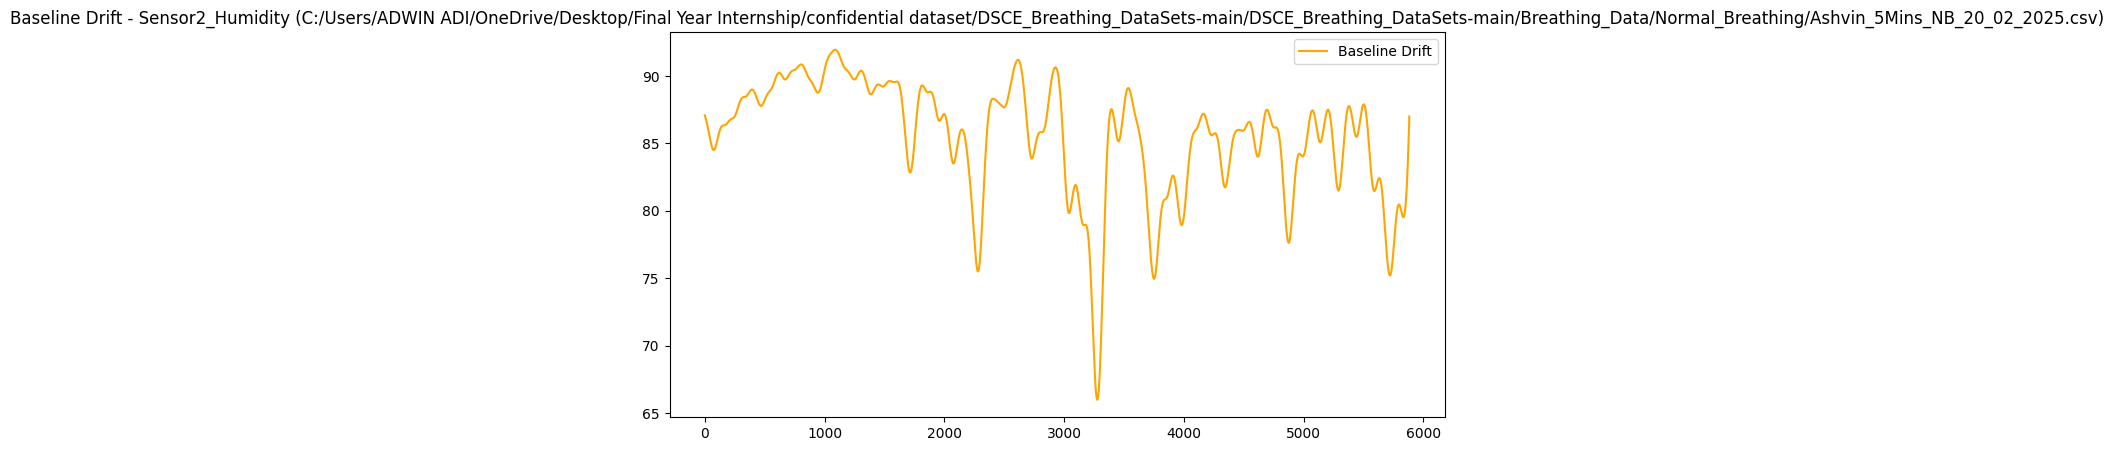

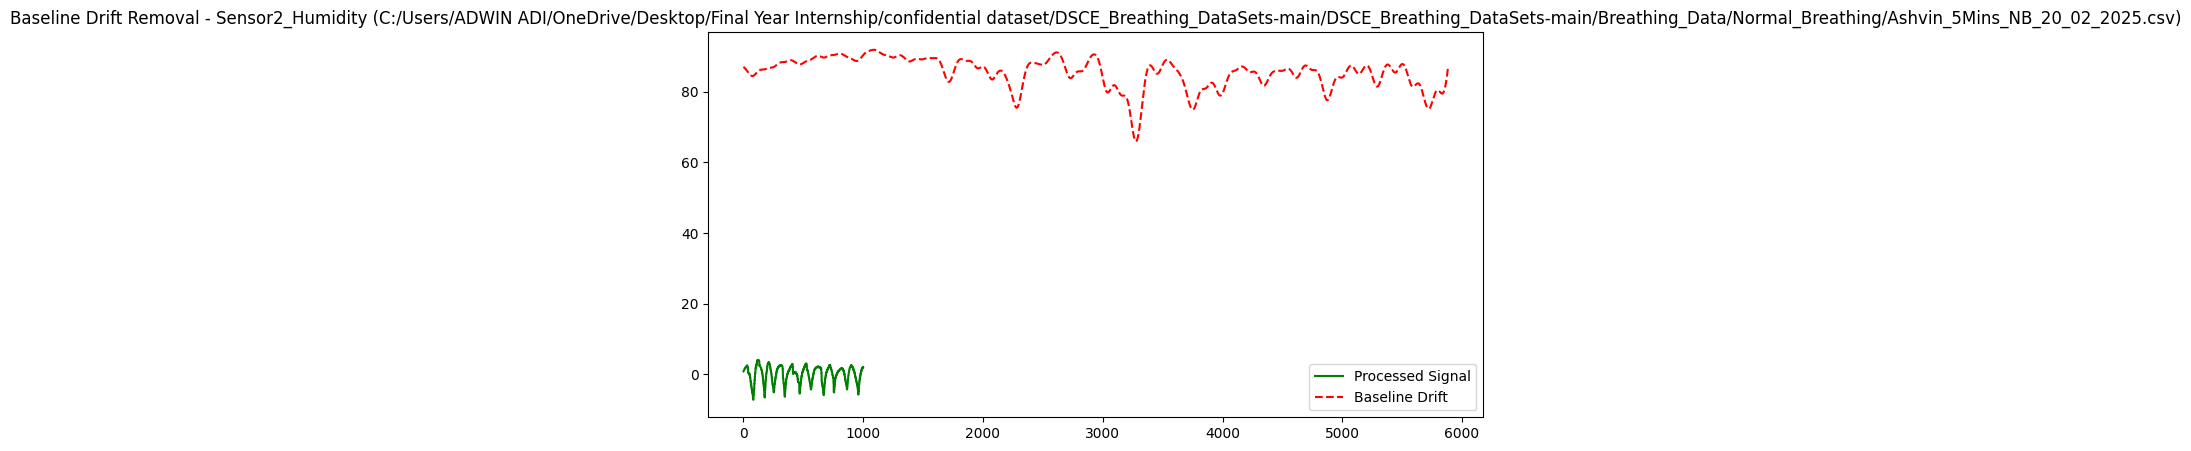

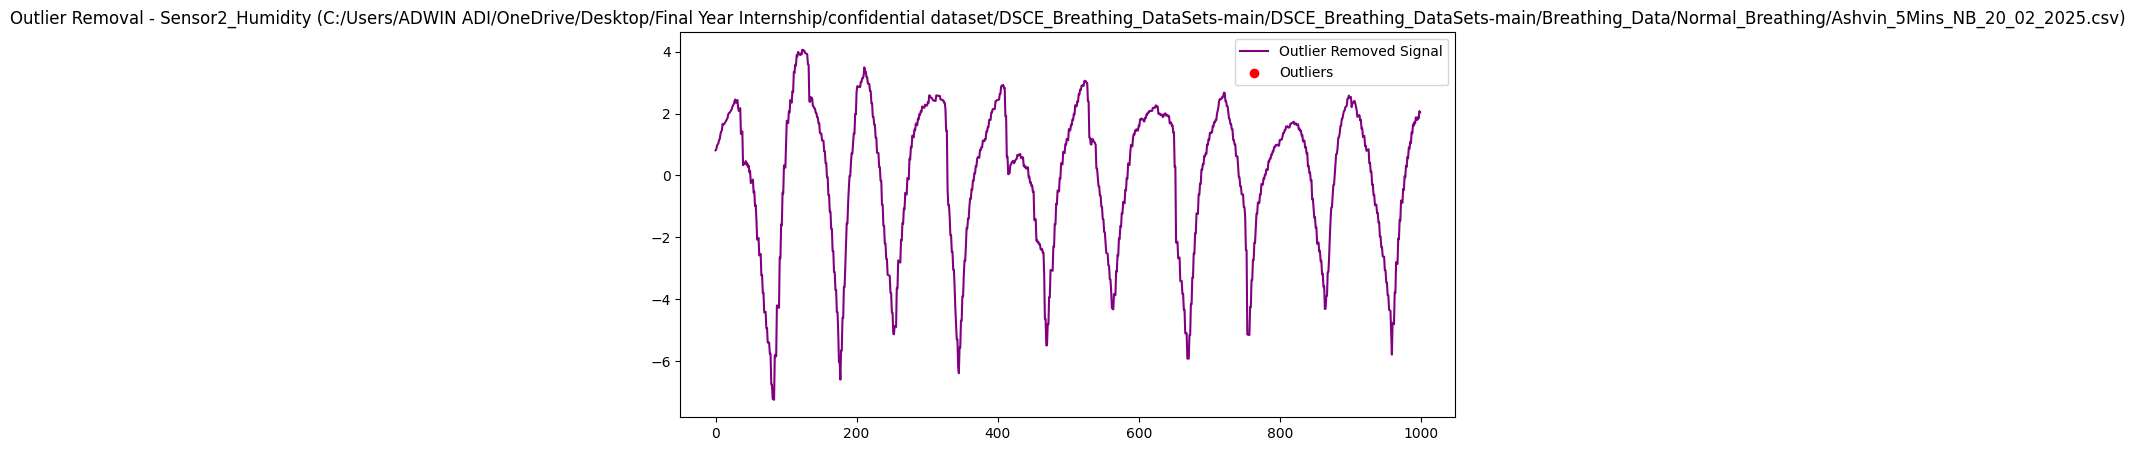


===== Training for 10 epochs on C:/Users/ADWIN ADI/OneDrive/Desktop/Final Year Internship/confidential dataset/DSCE_Breathing_DataSets-main/DSCE_Breathing_DataSets-main/Breathing_Data/Normal_Breathing/Ashvin_5Mins_NB_20_02_2025.csv =====
Epoch 1/10
294/294 [==============================] - 8s 12ms/step - loss: nan - accuracy: 0.9306
Epoch 2/10
294/294 [==============================] - 3s 12ms/step - loss: nan - accuracy: 0.9308
Epoch 3/10
294/294 [==============================] - 3s 12ms/step - loss: nan - accuracy: 0.9308
Epoch 4/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 5/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 6/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 7/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 8/10
294/294 [==============================] - 3s 11ms/step - loss: 

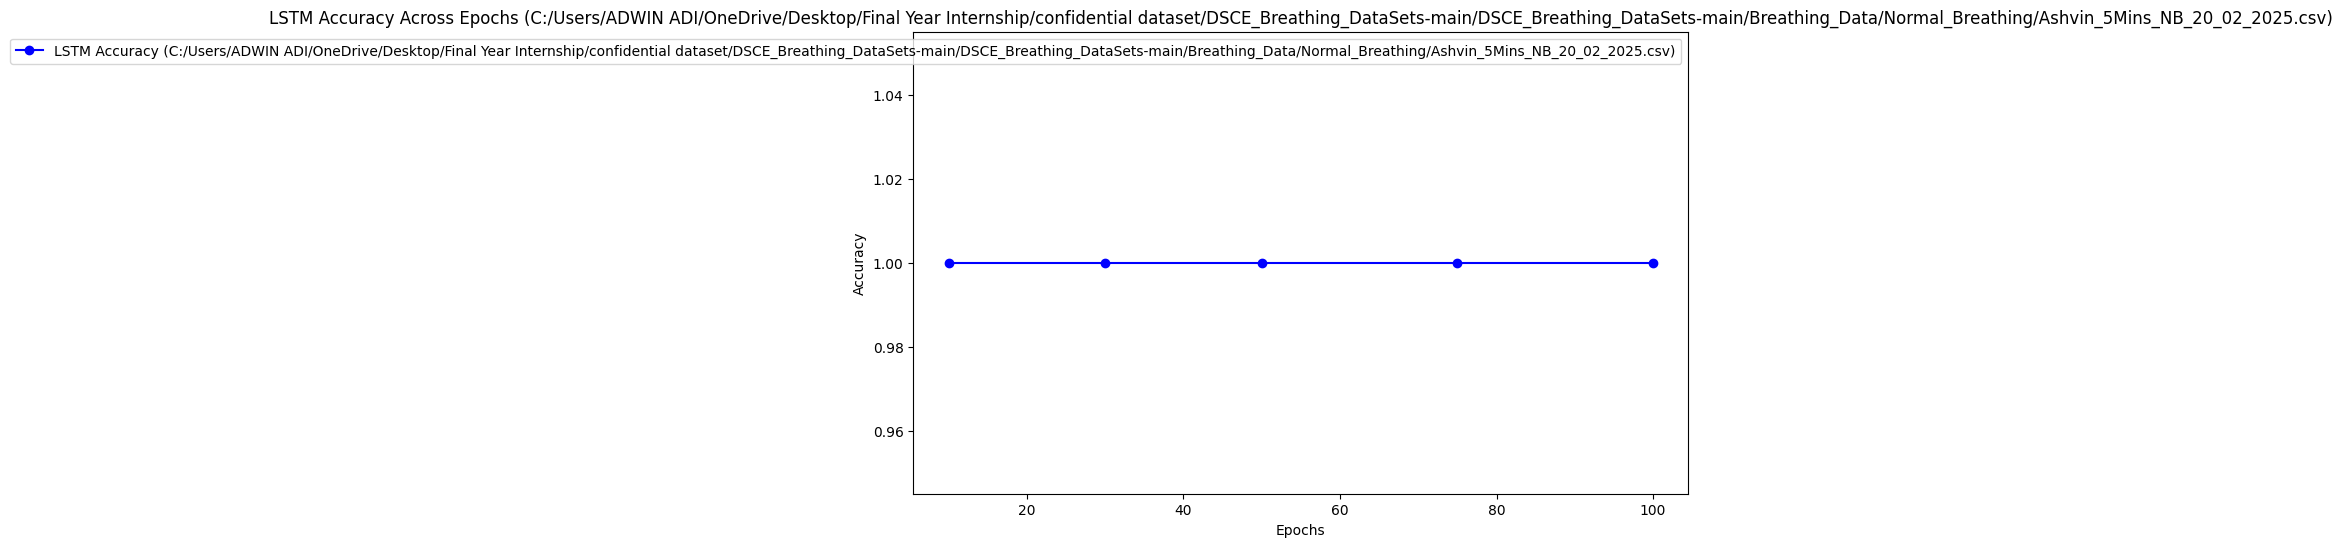

In [3]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import BinaryCrossentropy

# Function to load files using Tkinter
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    if not file_paths:
        print("No file selected. Exiting...")
        exit()
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score method
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Function to ensure all signals have 1000 samples
def ensure_1000_samples(df, numeric_columns):
    for col in numeric_columns:
        if len(df[col]) > 1000:
            df[col] = df[col][:1000]  # Trim
        elif len(df[col]) < 1000:
            df[col] = np.pad(df[col], (0, 1000 - len(df[col])), mode='constant')  # Pad
    return df

# Data Preprocessing Function
def preprocess_data(df):
    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    # Fill NaN values using interpolation
    df[numeric_columns] = df[numeric_columns].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
    
    baseline_drift = df[numeric_columns].apply(lambda x: x - high_pass_filter(x))
    df[numeric_columns] = df[numeric_columns].apply(high_pass_filter)
    
    outliers = df[numeric_columns].apply(lambda x: np.abs(zscore(x)) > 3)
    df[numeric_columns] = df[numeric_columns].apply(remove_outliers)

    df = ensure_1000_samples(df, numeric_columns)

    return df, numeric_columns, baseline_drift, outliers

# Function to plot signals with file name annotation
def plot_signals(df, numeric_columns, baseline_drift, outliers, file_name):
    for col in numeric_columns:
        plt.figure(figsize=(10, 5))
        plt.plot(df[col], label="Original Signal", color="blue")
        plt.title(f"Original Signal - {col} ({file_name})")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(baseline_drift[col], label="Baseline Drift", color="orange")
        plt.title(f"Baseline Drift - {col} ({file_name})")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(df[col], label="Processed Signal", color="green")
        plt.plot(baseline_drift[col], label="Baseline Drift", color="red", linestyle="dashed")
        plt.title(f"Baseline Drift Removal - {col} ({file_name})")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(df[col], label="Outlier Removed Signal", color="purple")
        outlier_points = df[col][outliers[col]]
        plt.scatter(outlier_points.index, outlier_points, color="red", label="Outliers")
        plt.title(f"Outlier Removal - {col} ({file_name})")
        plt.legend()
        plt.show()

# Load and Process Data
file_paths = load_files()
dataframes = [(pd.read_csv(file), file) for file in file_paths]
processed_data = []

for df, file_name in dataframes:
    df, numeric_columns, baseline_drift, outliers = preprocess_data(df)
    processed_data.append((df, numeric_columns, baseline_drift, outliers, file_name))
    plot_signals(df, numeric_columns, baseline_drift, outliers, file_name)

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(50, activation='relu'),
        Dense(input_shape[1], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])
    return model

# Function to Calculate Performance Metrics
def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    accuracy = accuracy_score(y_true.flatten(), y_pred_binary.flatten())
    specificity = recall_score(y_true.flatten(), y_pred_binary.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten(), zero_division=1)
    loss = BinaryCrossentropy()(tf.convert_to_tensor(y_true, dtype=tf.float32), 
                                tf.convert_to_tensor(y_pred, dtype=tf.float32)).numpy()

    return accuracy, specificity, f1, loss

# Scaling Data and Training
for df, numeric_columns, _, _, file_name in processed_data:
    scaler = MinMaxScaler()
    processed_values = scaler.fit_transform(df[numeric_columns])

    # Prepare Data for Training
    X, y = [], []
    seq_length = 10
    for i in range(len(processed_values) - seq_length):
        X.append(processed_values[i:i+seq_length])
        y.append(processed_values[i+seq_length])
    
    X, y = np.array(X), np.array(y)
    y = (y > 0.5).astype(int)  # Binary classification

    # Split Data into Train & Test
    train_size = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

    # Training for Different Epochs
    performance_data = []
    epochs_list = [10, 30, 50, 75, 100]

    for num_epochs in epochs_list:
        print(f"\n===== Training for {num_epochs} epochs on {file_name} =====")

        # Train LSTM
        lstm_model = build_lstm_model((seq_length, len(numeric_columns)))
        lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, verbose=1)
        y_pred_lstm = lstm_model.predict(X_test)
        
        lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)
        performance_data.append([num_epochs, lstm_loss, lstm_acc, lstm_spec, lstm_f1])

    # Store Performance in a DataFrame
    performance_df = pd.DataFrame(performance_data, columns=["Epochs", "LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score"])
    print(performance_df)

    # Plot Model Performance
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_list, performance_df["LSTM Accuracy"], marker='o', label=f"LSTM Accuracy ({file_name})", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"LSTM Accuracy Across Epochs ({file_name})")
    plt.legend()
    plt.show()


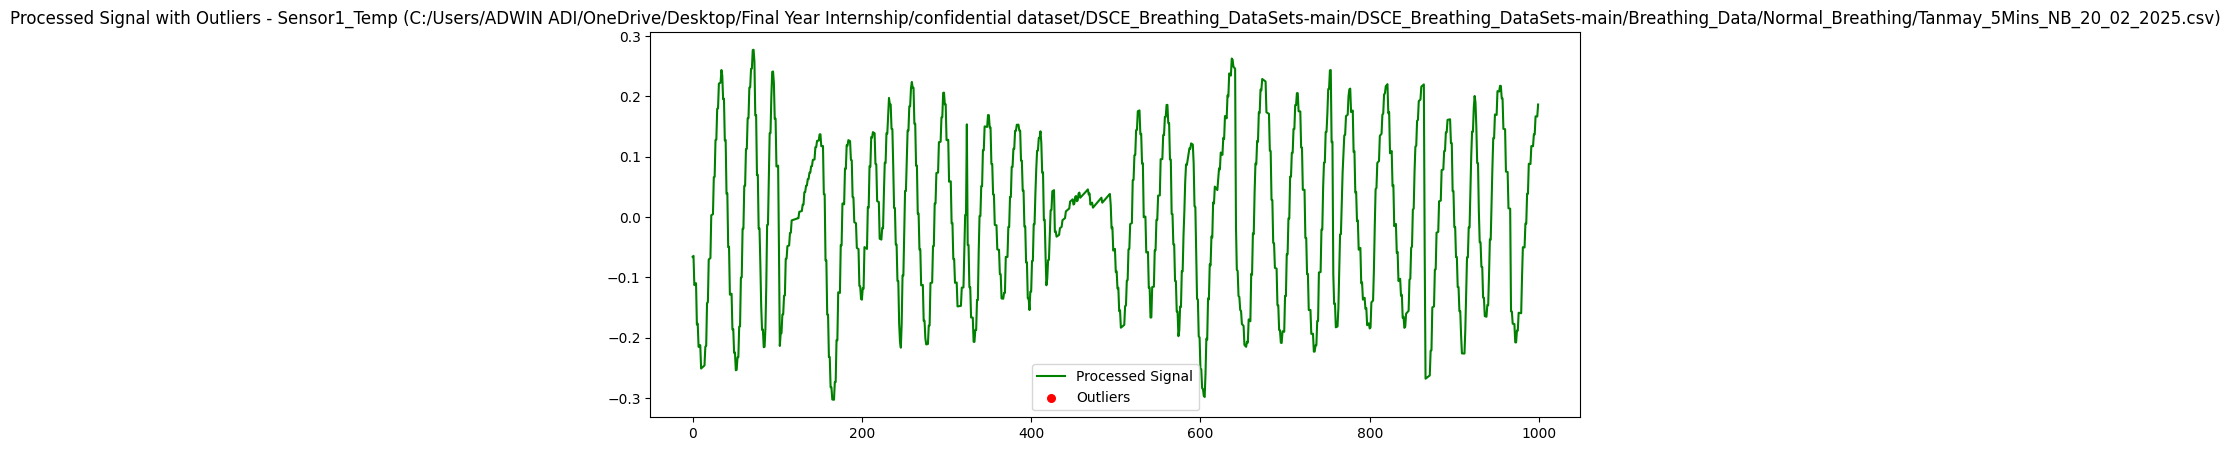

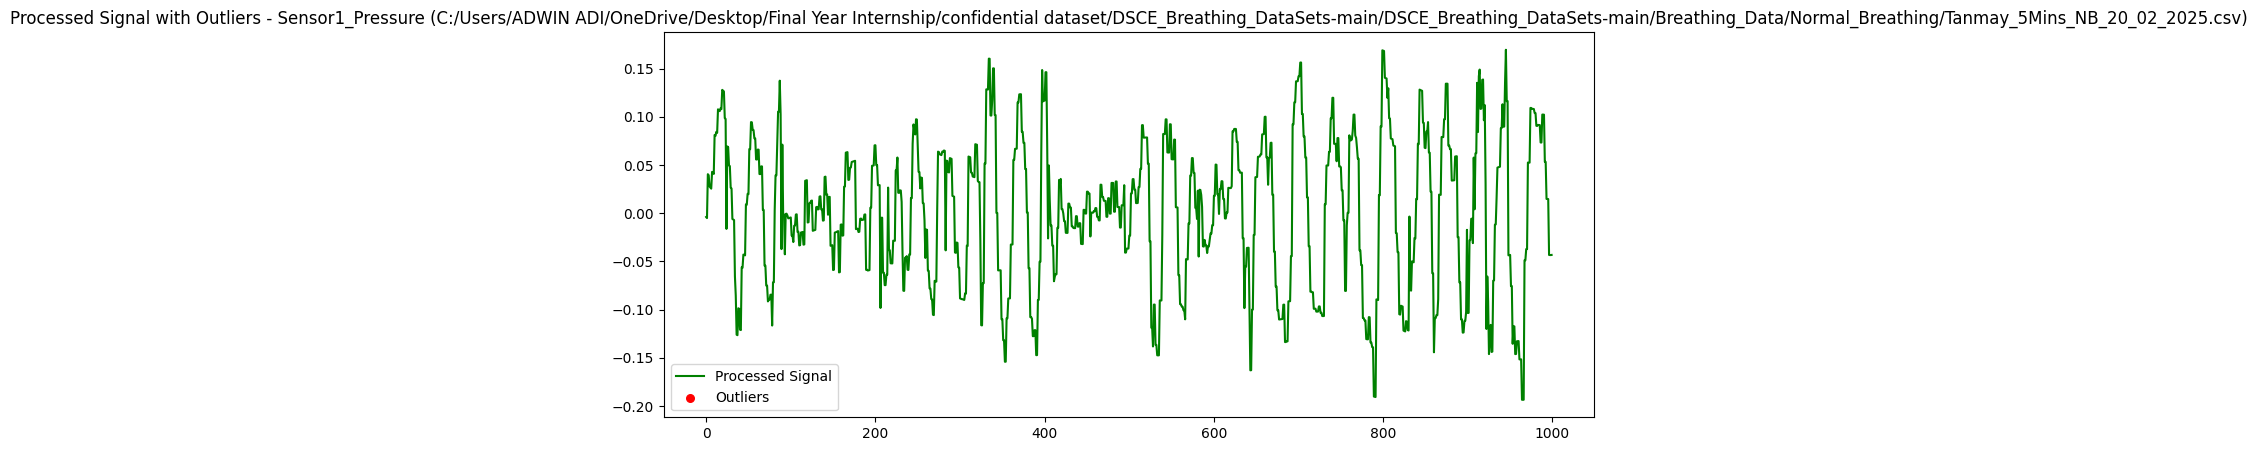

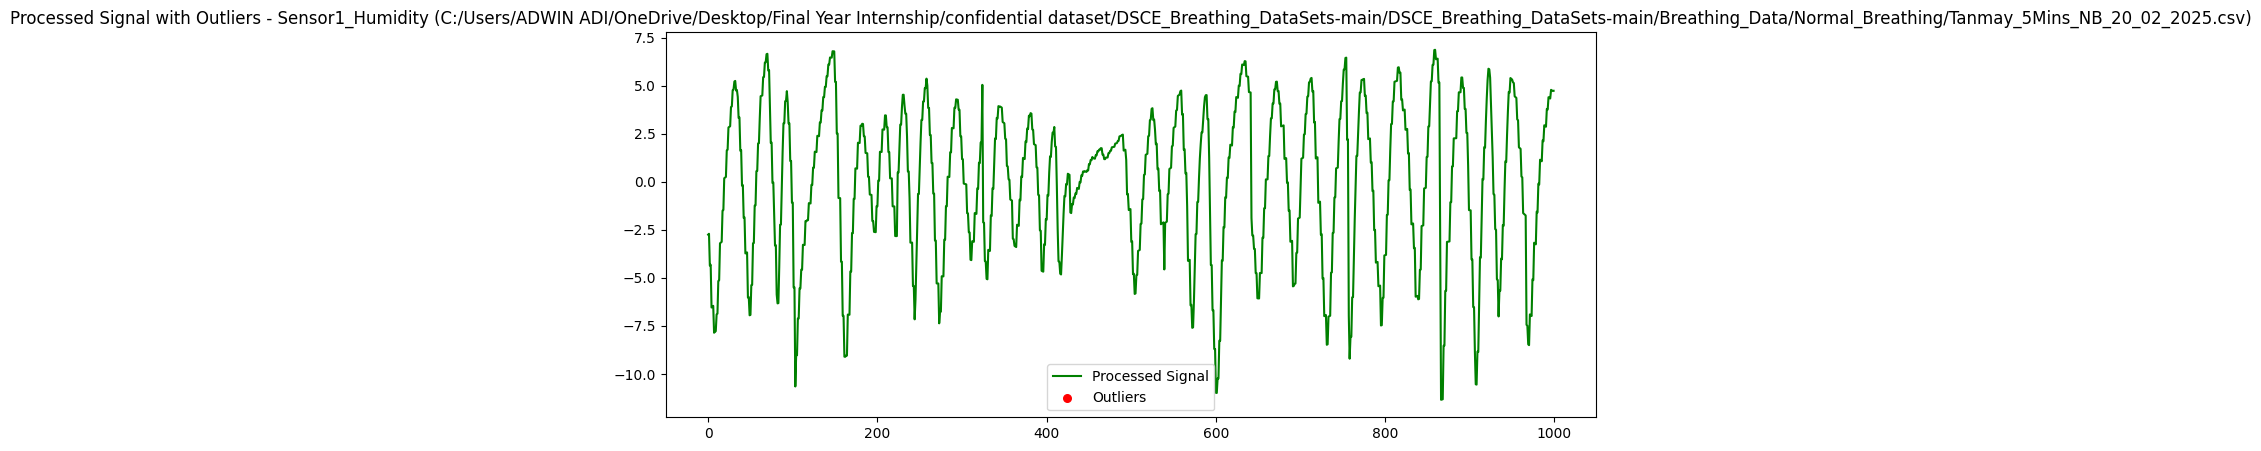

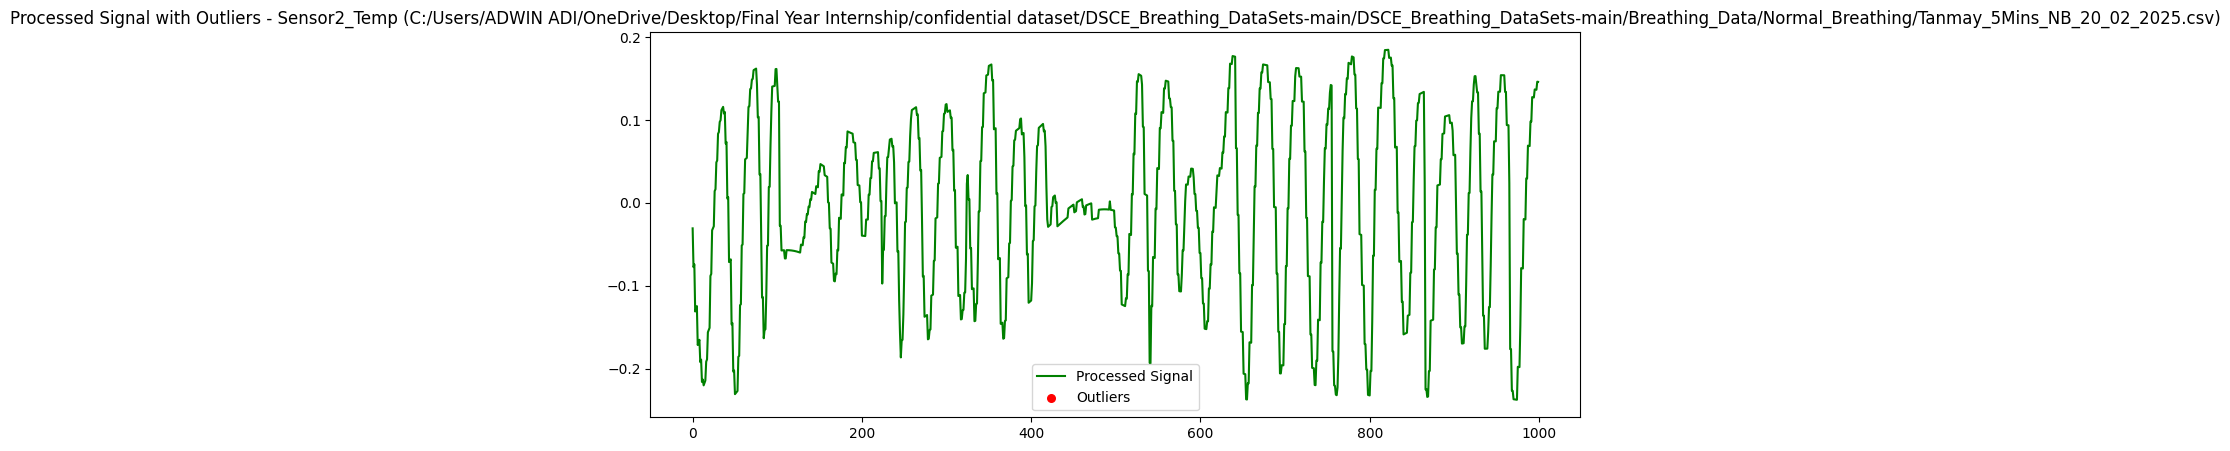

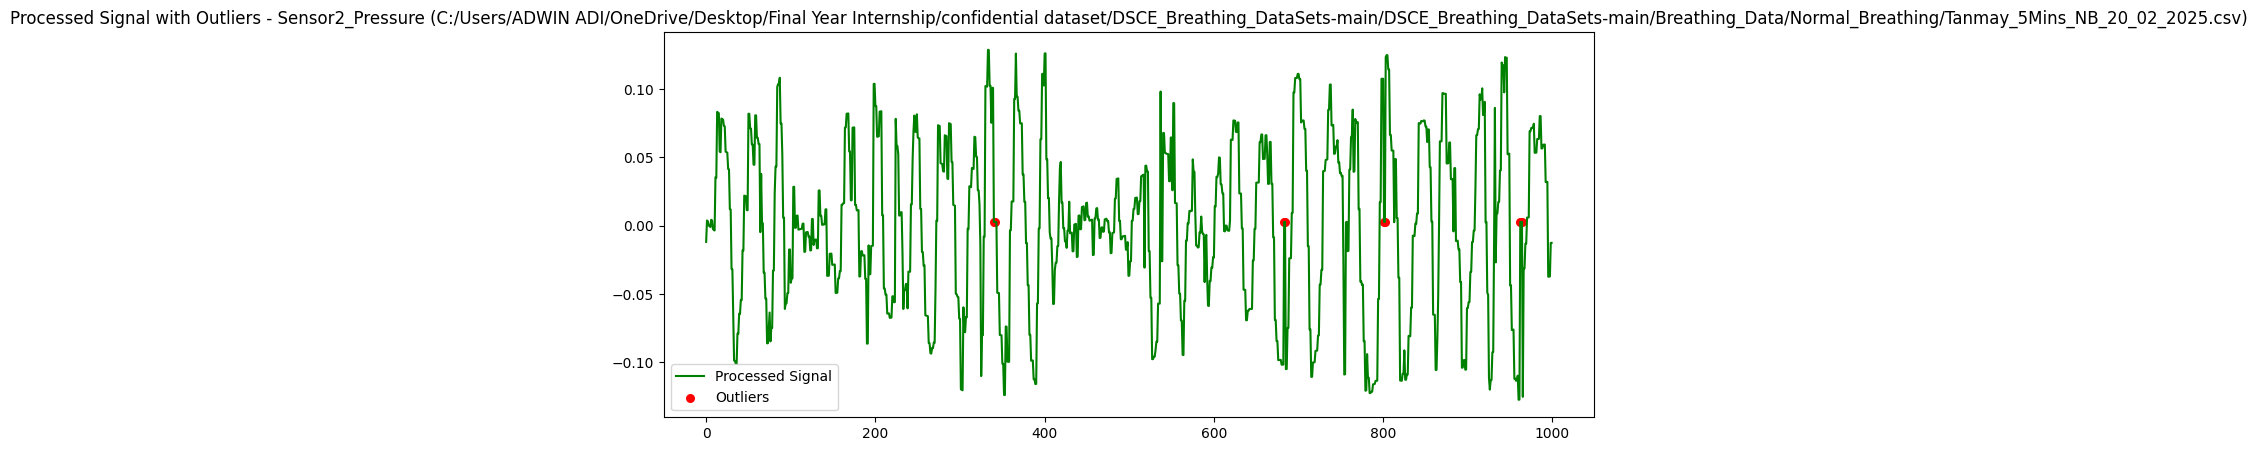

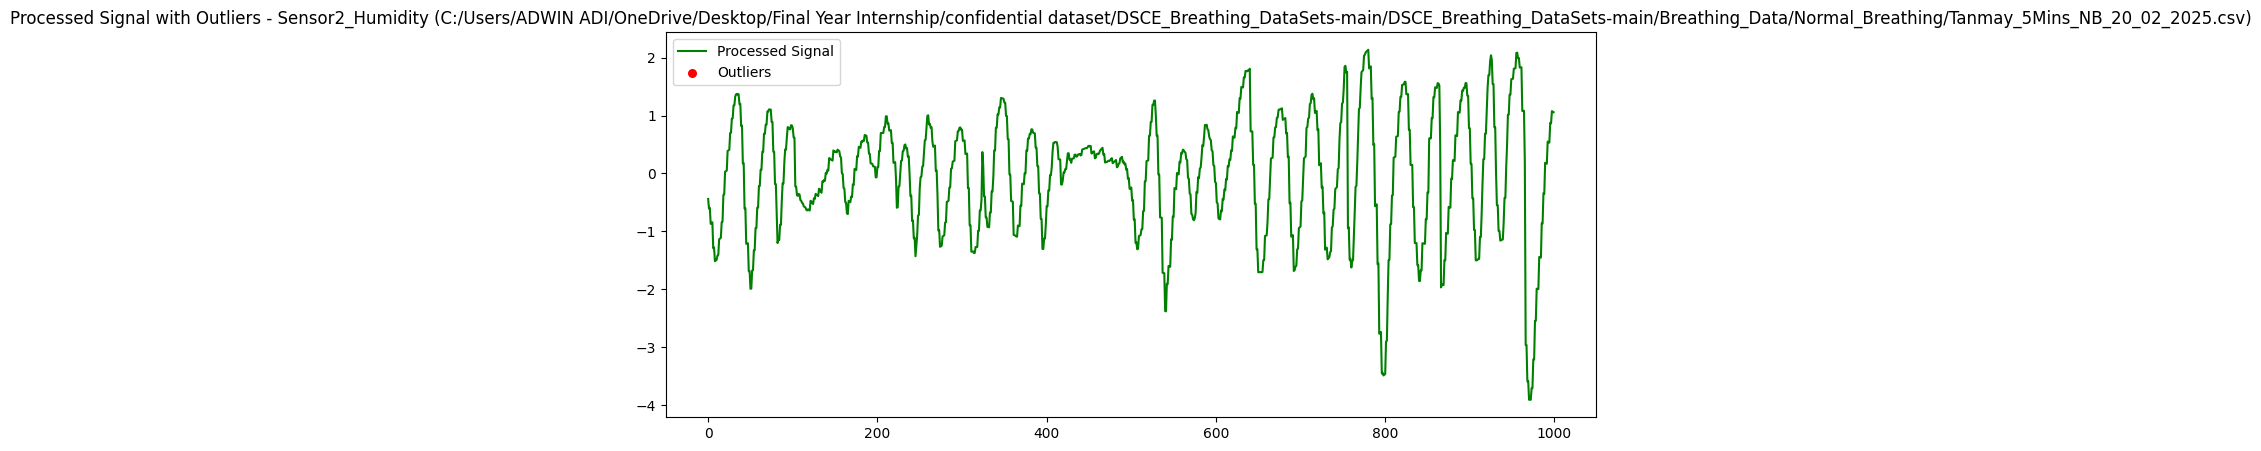


===== Training for 10 epochs on C:/Users/ADWIN ADI/OneDrive/Desktop/Final Year Internship/confidential dataset/DSCE_Breathing_DataSets-main/DSCE_Breathing_DataSets-main/Breathing_Data/Normal_Breathing/Tanmay_5Mins_NB_20_02_2025.csv =====
Epoch 1/10
289/289 [==============================] - 8s 16ms/step - loss: nan - accuracy: 0.9067
Epoch 2/10
289/289 [==============================] - 4s 15ms/step - loss: nan - accuracy: 0.9076
Epoch 3/10
289/289 [==============================] - 4s 14ms/step - loss: nan - accuracy: 0.9076
Epoch 4/10
289/289 [==============================] - 4s 15ms/step - loss: nan - accuracy: 0.9076
Epoch 5/10
289/289 [==============================] - 4s 15ms/step - loss: nan - accuracy: 0.9076
Epoch 6/10
289/289 [==============================] - 5s 16ms/step - loss: nan - accuracy: 0.9076
Epoch 7/10
289/289 [==============================] - 5s 16ms/step - loss: nan - accuracy: 0.9076
Epoch 8/10
289/289 [==============================] - 4s 15ms/step - loss: 

ValueError: Input contains NaN.

In [5]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Function to load files using Tkinter
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    if not file_paths:
        print("No file selected. Exiting...")
        exit()
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score method
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Function to ensure all signals have 1000 samples
def ensure_1000_samples(df, numeric_columns):
    for col in numeric_columns:
        if len(df[col]) > 1000:
            df[col] = df[col][:1000]  # Trim
        elif len(df[col]) < 1000:
            df[col] = np.pad(df[col], (0, 1000 - len(df[col])), mode='constant')  # Pad
    return df

# Data Preprocessing Function
def preprocess_data(df):
    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    # Fill NaN values using interpolation
    df[numeric_columns] = df[numeric_columns].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
    
    baseline_drift = df[numeric_columns].apply(lambda x: x - high_pass_filter(x))
    df[numeric_columns] = df[numeric_columns].apply(high_pass_filter)
    
    outliers = df[numeric_columns].apply(lambda x: np.abs(zscore(x)) > 3)
    df[numeric_columns] = df[numeric_columns].apply(remove_outliers)

    df = ensure_1000_samples(df, numeric_columns)

    return df, numeric_columns, baseline_drift, outliers

# Function to plot signals separately with outliers
def plot_signals(df, numeric_columns, baseline_drift, outliers, file_name):
    for col in numeric_columns:
        plt.figure(figsize=(12, 5))
        plt.plot(df[col], label="Processed Signal", color="green")

        # Get correct outlier indices and values
        outlier_indices = df.index[outliers[col]]
        outlier_values = df[col][outliers[col]]

        plt.scatter(outlier_indices, outlier_values, color="red", label="Outliers", s=30)
        plt.title(f"Processed Signal with Outliers - {col} ({file_name})")
        plt.legend()
        plt.show()

# Load and Process Data
file_paths = load_files()
dataframes = [(pd.read_csv(file), file) for file in file_paths]
processed_data = []

for df, file_name in dataframes:
    df, numeric_columns, baseline_drift, outliers = preprocess_data(df)
    processed_data.append((df, numeric_columns, baseline_drift, outliers, file_name))
    plot_signals(df, numeric_columns, baseline_drift, outliers, file_name)

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, activation='relu'),
        Dense(input_shape[1], activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])
    return model

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads=2, hidden_dim=64, num_layers=2):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, input_dim)
    
    def forward(self, x):
        x = self.transformer_encoder(x)
        return self.fc(x)

# Function to Calculate Performance Metrics
def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    accuracy = accuracy_score(y_true.flatten(), y_pred_binary.flatten())
    specificity = recall_score(y_true.flatten(), y_pred_binary.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten(), zero_division=1)
    loss = mean_squared_error(y_true.flatten(), y_pred.flatten())  

    return accuracy, specificity, f1, loss

# Scaling Data and Training
for df, numeric_columns, _, _, file_name in processed_data:
    scaler = MinMaxScaler()
    processed_values = scaler.fit_transform(df[numeric_columns])

    # Prepare Data for Training
    X, y = [], []
    seq_length = 10
    for i in range(len(processed_values) - seq_length):
        X.append(processed_values[i:i+seq_length])
        y.append(processed_values[i+seq_length])
    
    X, y = np.array(X), np.array(y)
    y = (y > 0.5).astype(int)

    # Split Data into Train & Test
    train_size = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

    # Training for Different Epochs
    performance_data = []
    epochs_list = [10, 30, 40, 75, 100]

    for num_epochs in epochs_list:
        print(f"\n===== Training for {num_epochs} epochs on {file_name} =====")

        # Train LSTM
        lstm_model = build_lstm_model((seq_length, len(numeric_columns)))
        lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, verbose=1)
        y_pred_lstm = lstm_model.predict(X_test)
        
        lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)
        performance_data.append([num_epochs, lstm_loss, lstm_acc, lstm_spec, lstm_f1])

    # Store Performance in a DataFrame
    performance_df = pd.DataFrame(performance_data, columns=["Epochs", "Loss", "Accuracy", "Specificity", "F1 Score"])
    print(performance_df)

    # Plot Model Performance
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_list, performance_df["Accuracy"], marker='o', label=f"LSTM Accuracy ({file_name})", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"LSTM Accuracy Across Epochs ({file_name})")
    plt.legend()
    plt.show()


In [ ]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Function to load files using Tkinter
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    if not file_paths:
        print("No file selected. Exiting...")
        exit()
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Ensure all signals have 1000 samples
def ensure_1000_samples(df, numeric_columns):
    for col in numeric_columns:
        if len(df[col]) > 1000:
            df[col] = df[col][:1000]  # Trim
        elif len(df[col]) < 1000:
            df[col] = np.pad(df[col], (0, 1000 - len(df[col])), mode='constant')  # Pad
    return df

# Data Preprocessing Function
def preprocess_data(df):
    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    # Fill NaN values using interpolation
    df[numeric_columns] = df[numeric_columns].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
    
    # Normalize data
    scaler = MinMaxScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    # Baseline drift removal
    baseline_drift = df[numeric_columns].apply(lambda x: x - high_pass_filter(x))
    df[numeric_columns] = df[numeric_columns].apply(high_pass_filter)

    df = ensure_1000_samples(df, numeric_columns)

    return df, numeric_columns, baseline_drift

# Function to plot baseline wandering and removal
def plot_baseline_wandering(df, numeric_columns, baseline_drift, file_name):
    for col in numeric_columns:
        plt.figure(figsize=(12, 6))
        
        # Plot original signal
        plt.subplot(2, 1, 1)
        plt.plot(df[col] + baseline_drift[col], label="Original Signal", color="blue")
        plt.plot(baseline_drift[col], label="Baseline Wandering", color="red", linestyle="dashed")
        plt.title(f"Original Signal & Baseline Wandering - {col} ({file_name})")
        plt.legend()

        # Plot baseline corrected signal
        plt.subplot(2, 1, 2)
        plt.plot(df[col] + baseline_drift[col], label="Original Signal (With Baseline Drift)", color="blue", alpha=0.5)
        plt.plot(df[col], label="After Baseline Removal", color="green")
        plt.title(f"Baseline Corrected Signal - {col} ({file_name})")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Load and Process Data
file_paths = load_files()
dataframes = [(pd.read_csv(file), file) for file in file_paths]
processed_data = []

for df, file_name in dataframes:
    df, numeric_columns, baseline_drift = preprocess_data(df)
    processed_data.append((df, numeric_columns, baseline_drift, file_name))
    plot_baseline_wandering(df, numeric_columns, baseline_drift, file_name)

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Transformer Model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm1 = LayerNormalization()
        self.norm2 = LayerNormalization()
        self.dense = Dense(embed_dim, activation="relu")

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.norm1(inputs + attn_output)
        dense_output = self.dense(out1)
        return self.norm2(out1 + dense_output)

def build_transformer_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = TransformerBlock(embed_dim=64, num_heads=4)(inputs)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train models for 10, 30, 40, 75, 100 epochs in one go
epochs_list = [10, 30, 40, 75, 100]
results = []

for df, numeric_columns, _, file_name in processed_data:
    X = df[numeric_columns].values.reshape(len(df), len(numeric_columns), 1)
    y = np.random.randint(0, 2, len(df))  # Replace with actual labels

    lstm_model = build_lstm_model((len(numeric_columns), 1))
    transformer_model = build_transformer_model((len(numeric_columns), 1))

    for epochs in epochs_list:
        print(f"Training for {epochs} epochs on {file_name}")

        history_lstm = lstm_model.fit(X, y, epochs=epochs, batch_size=32, verbose=0)
        history_transformer = transformer_model.fit(X, y, epochs=epochs, batch_size=32, verbose=0)

        y_pred_lstm = (lstm_model.predict(X) > 0.5).astype("int32")
        y_pred_transformer = (transformer_model.predict(X) > 0.5).astype("int32")

        acc_lstm = accuracy_score(y, y_pred_lstm)
        acc_transformer = accuracy_score(y, y_pred_transformer)

        f1_lstm = f1_score(y, y_pred_lstm)
        f1_transformer = f1_score(y, y_pred_transformer)

        tn, fp, fn, tp = confusion_matrix(y, y_pred_lstm).ravel()
        specificity_lstm = tn / (tn + fp)

        tn, fp, fn, tp = confusion_matrix(y, y_pred_transformer).ravel()
        specificity_transformer = tn / (tn + fp)

        results.append([file_name, epochs, history_lstm.history['loss'][-1], acc_lstm, specificity_lstm, f1_lstm, 
                        history_transformer.history['loss'][-1], acc_transformer, specificity_transformer, f1_transformer])

# Print Performance Table
df_results = pd.DataFrame(results, columns=["File", "Epochs", "LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1",
                                            "Transformer Loss", "Transformer Accuracy", "Transformer Specificity", "Transformer F1"])
print(df_results)


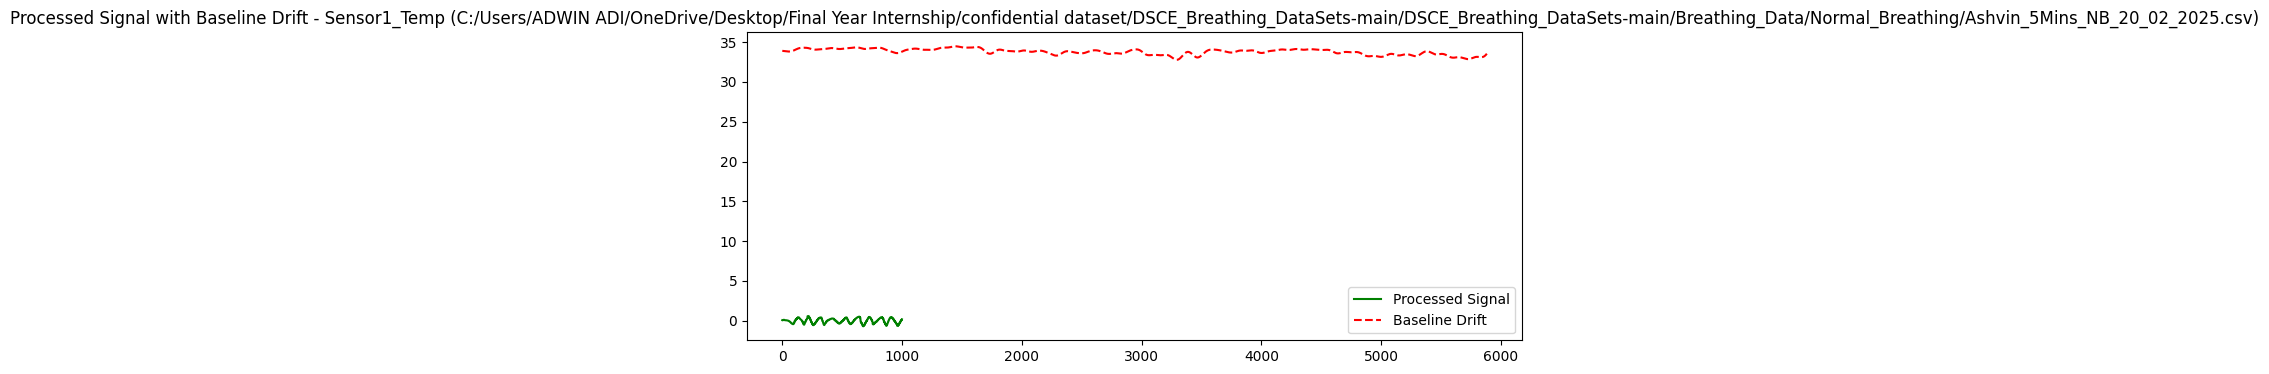

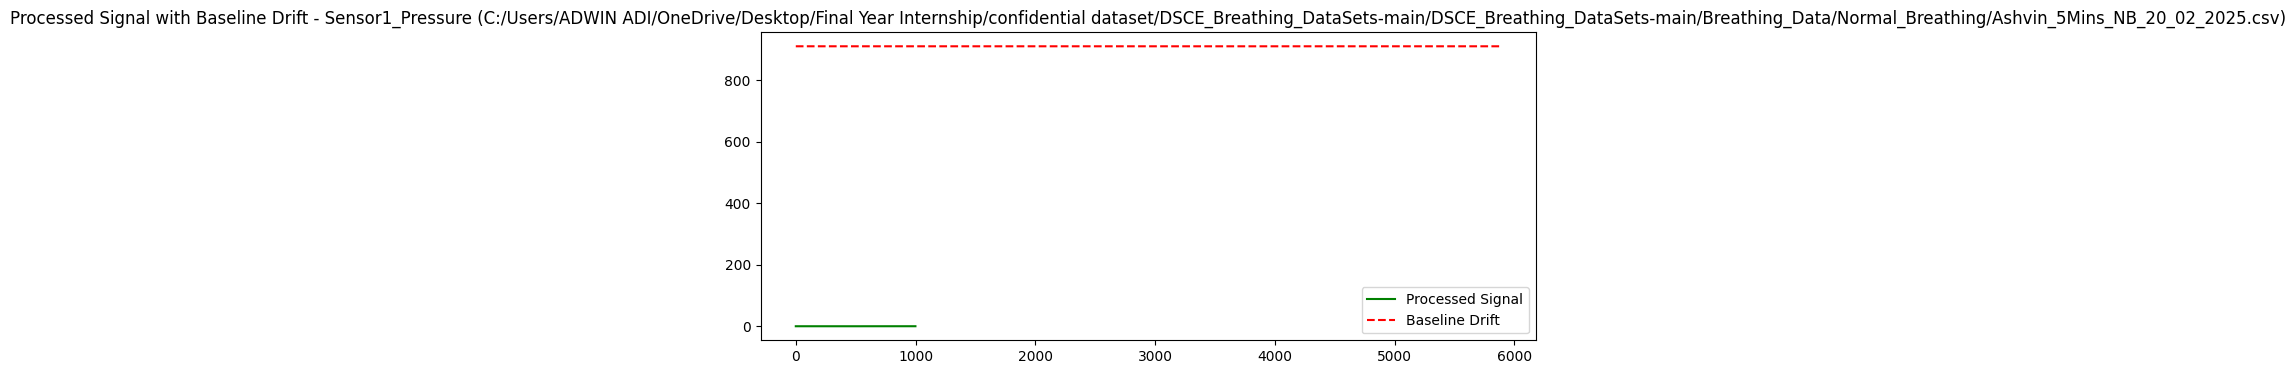

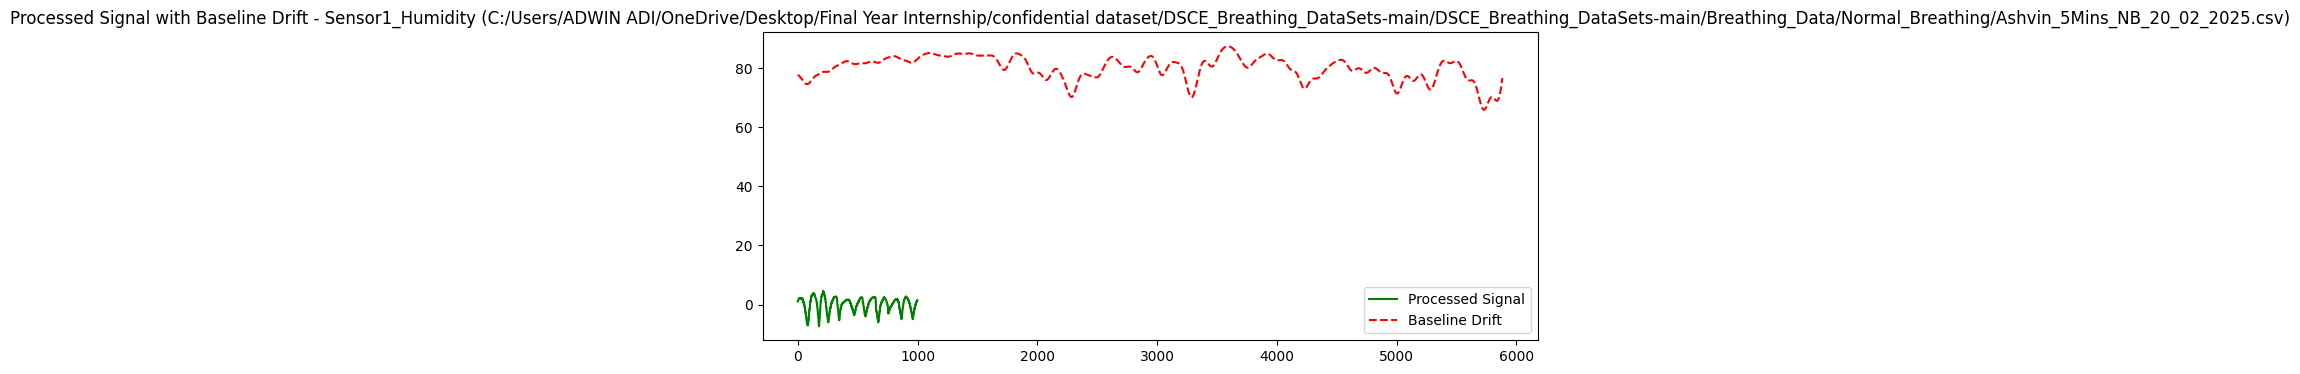

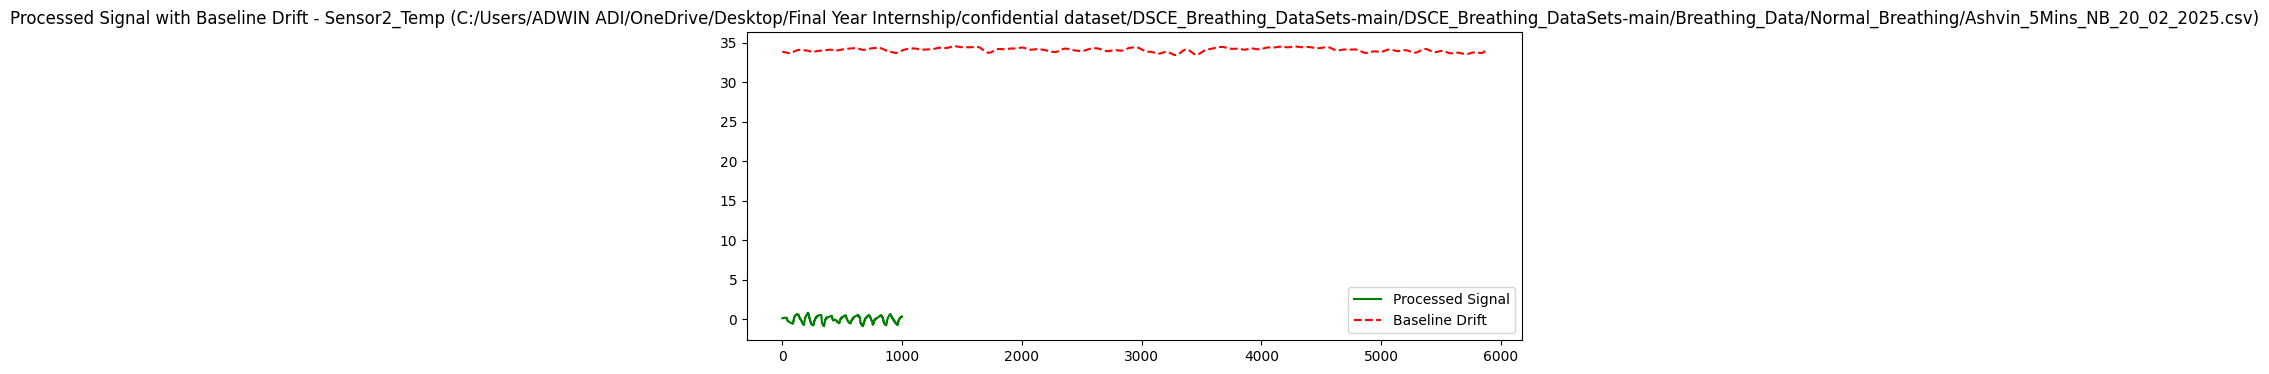

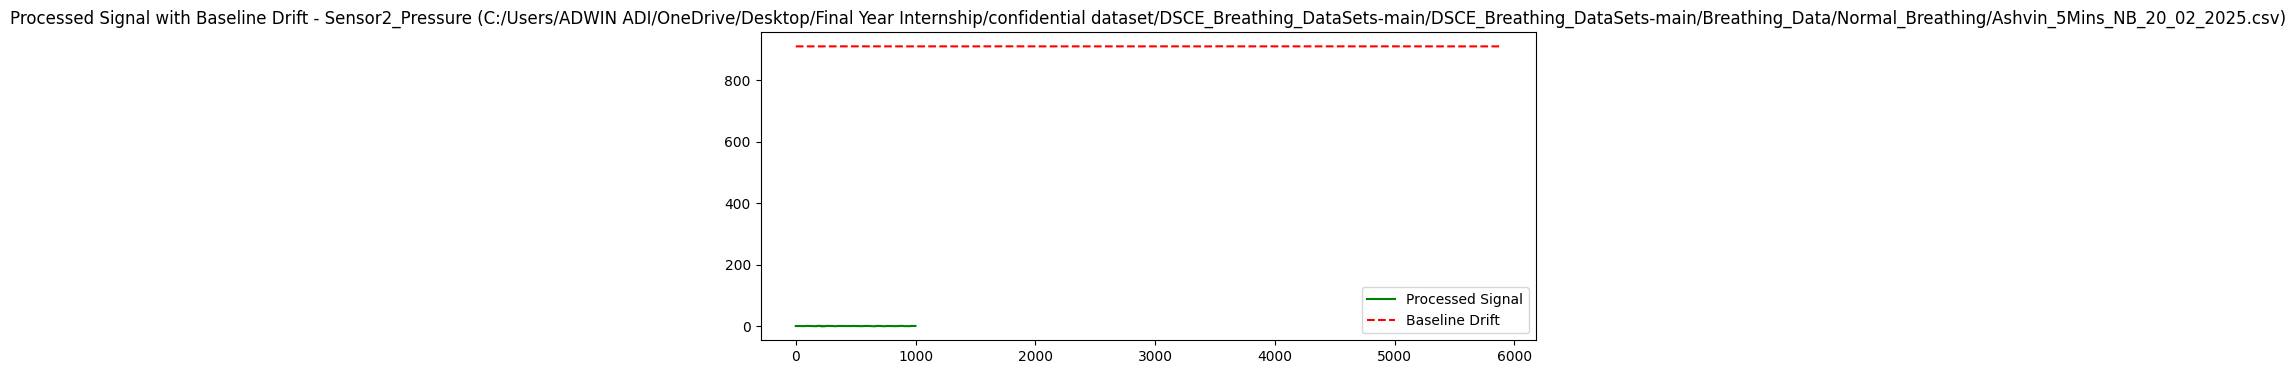

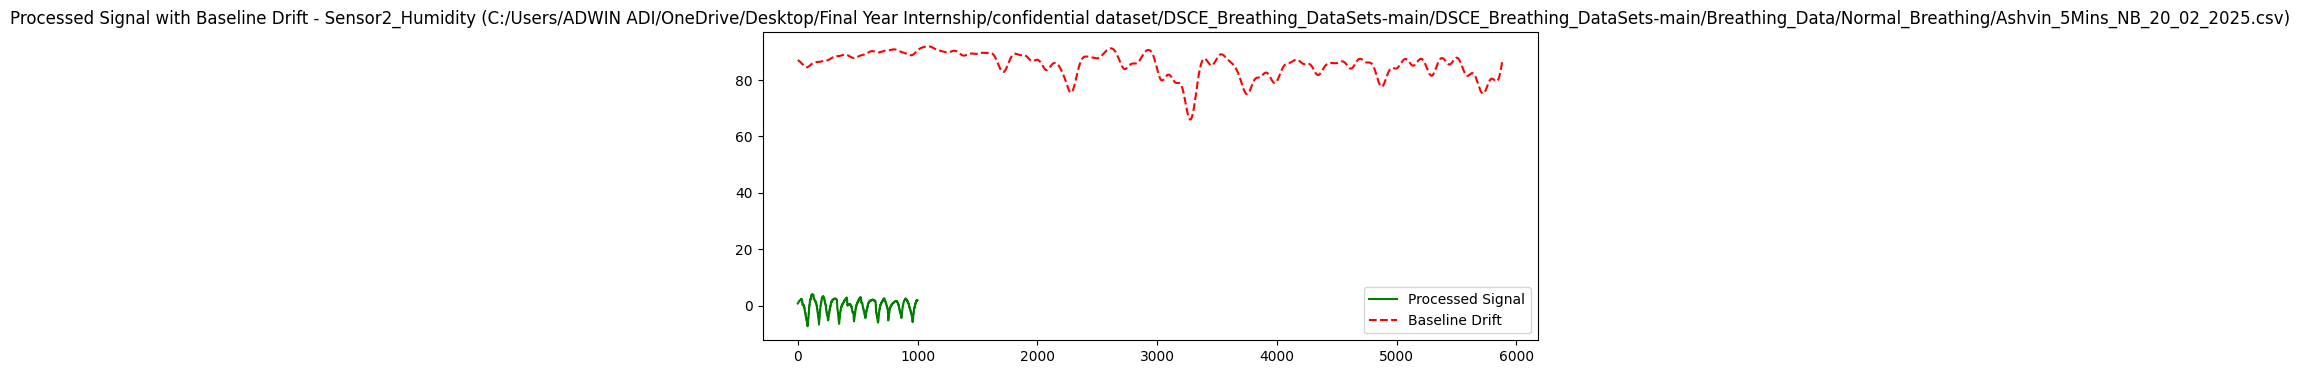


===== Training for 10 epochs on C:/Users/ADWIN ADI/OneDrive/Desktop/Final Year Internship/confidential dataset/DSCE_Breathing_DataSets-main/DSCE_Breathing_DataSets-main/Breathing_Data/Normal_Breathing/Ashvin_5Mins_NB_20_02_2025.csv =====
Epoch 1/10
294/294 [==============================] - 7s 11ms/step - loss: nan - accuracy: 0.9304
Epoch 2/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 3/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 4/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 5/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 6/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 7/10
294/294 [==============================] - 4s 13ms/step - loss: nan - accuracy: 0.9308
Epoch 8/10
294/294 [==============================] - 4s 13ms/step - loss: 

ValueError: Input contains NaN.

In [1]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from torch.nn import Transformer

# Function to load files using Tkinter
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    if not file_paths:
        print("No file selected. Exiting...")
        exit()
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score method
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Function to ensure all signals have exactly 1000 samples
def ensure_1000_samples(df, numeric_columns):
    for col in numeric_columns:
        if len(df[col]) > 1000:
            df[col] = df[col][:1000]  # Trim
        elif len(df[col]) < 1000:
            df[col] = np.pad(df[col], (0, 1000 - len(df[col])), mode='constant')  # Pad
    return df

# Data Preprocessing Function
def preprocess_data(df):
    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    # Fill NaN values using interpolation
    df[numeric_columns] = df[numeric_columns].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
    
    # Detect Baseline Wandering
    baseline_drift = df[numeric_columns].apply(lambda x: x - high_pass_filter(x))
    
    # Remove Baseline Wandering
    df[numeric_columns] = df[numeric_columns].apply(high_pass_filter)
    
    # Detect Outliers
    outliers = df[numeric_columns].apply(lambda x: np.abs(zscore(x)) > 3)
    
    # Remove Outliers
    df[numeric_columns] = df[numeric_columns].apply(remove_outliers)

    # Ensure exactly 1000 samples
    df = ensure_1000_samples(df, numeric_columns)

    return df, numeric_columns, baseline_drift, outliers

# Function to plot signals
def plot_signals(df, numeric_columns, baseline_drift, file_name):
    for col in numeric_columns:
        plt.figure(figsize=(10, 4))
        plt.plot(df[col], label="Processed Signal", color="green")
        plt.plot(baseline_drift[col], label="Baseline Drift", color="red", linestyle="dashed")
        plt.title(f"Processed Signal with Baseline Drift - {col} ({file_name})")
        plt.legend()
        plt.show()

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(50, activation='relu'),
        Dense(input_shape[1], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads=4, hidden_dim=128, num_layers=2):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])  # Get the last time step
        return self.sigmoid(x)

# Function to Calculate Performance Metrics
def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true.flatten(), y_pred_binary.flatten())
    specificity = recall_score(y_true.flatten(), y_pred_binary.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten(), zero_division=1)
    loss = mean_squared_error(y_true.flatten(), y_pred.flatten())  # Correct Loss Calculation
    return accuracy, specificity, f1, loss

# Load and Process Data
file_paths = load_files()
dataframes = [(pd.read_csv(file), file) for file in file_paths]
processed_data = []

for df, file_name in dataframes:
    df, numeric_columns, baseline_drift, _ = preprocess_data(df)
    processed_data.append((df, numeric_columns, baseline_drift, file_name))
    plot_signals(df, numeric_columns, baseline_drift, file_name)

# Training & Performance Evaluation
for df, numeric_columns, _, file_name in processed_data:
    scaler = MinMaxScaler()
    processed_values = scaler.fit_transform(df[numeric_columns])

    X, y = [], []
    seq_length = 10
    for i in range(len(processed_values) - seq_length):
        X.append(processed_values[i:i+seq_length])
        y.append(processed_values[i+seq_length])
    
    X, y = np.array(X), np.array(y)
    y = (y > 0.5).astype(int)  

    train_size = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

    performance_data = []
    epochs_list = [10, 30, 50, 75, 100]

    for num_epochs in epochs_list:
        print(f"\n===== Training for {num_epochs} epochs on {file_name} =====")
        lstm_model = build_lstm_model((seq_length, len(numeric_columns)))
        lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, verbose=1)
        y_pred_lstm = lstm_model.predict(X_test)
        lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)
        performance_data.append([num_epochs, lstm_loss, lstm_acc, lstm_spec, lstm_f1])

    performance_df = pd.DataFrame(performance_data, columns=["Epochs", "LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score"])
    print(performance_df)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_list, performance_df["LSTM Accuracy"], marker='o', label=f"LSTM Accuracy ({file_name})", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
